In [ ]:
# This is an MSc Project on deep learning-based knot topological classification models

In [ ]:
# This part is data preprocessing

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
# Connect to the google conlab
drive.mount('/content/drive')
# Set the dataset path
data_dir = "/content/drive/My Drive/MSc Project/5_Type_Knots"


# Create a label for the original data set and crop it to size 512x512
def create_csv_and_resize_images(data_dir, new_data_dir, csv_file):
    # Create a dictionary to map the knot type to the corresponding integer label
    label_dict = {'Bowline': 0, 'Clove_Hitch': 1, 'Figure_8_Knot': 2, 'Overhand': 3, 'Reef': 4}

    data = []
    if not os.path.exists(new_data_dir):
        os.makedirs(new_data_dir)
    for knot_type in os.listdir(data_dir):
        for light_condition in os.listdir(os.path.join(data_dir, knot_type)):
            for tension_condition in os.listdir(os.path.join(data_dir, knot_type, light_condition)):
                for image_file in os.listdir(os.path.join(data_dir, knot_type, light_condition, tension_condition)):
                    image_path = os.path.join(data_dir, knot_type, light_condition, tension_condition, image_file)
                    image = Image.open(image_path)
                    image = image.resize((512, 512))  # Adjust the image size
                    new_image_dir = os.path.join(new_data_dir, knot_type, light_condition, tension_condition)
                    if not os.path.exists(new_image_dir):
                        os.makedirs(new_image_dir)
                    new_image_path = os.path.join(new_image_dir, image_file)
                    image.save(new_image_path)
                    data.append([image_file, label_dict[knot_type]])  # Use a dictionary to get the corresponding integer label
    df = pd.DataFrame(data, columns=['image_path', 'label'])
    df.to_csv(csv_file, index=False)

new_data_dir = "/content/drive/My Drive/MSc Project/rawdata"  # The new dataset directory
csv_file = "/content/drive/My Drive/MSc Project/rawdata.csv"  # The CSV file directory
create_csv_and_resize_images(data_dir, new_data_dir, csv_file)


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
# Connect to the google conlab
drive.mount('/content/drive')
# Set the dataset path
data_dir = "/content/drive/My Drive/MSc Project/5_Type_Knots"


# Create a label for the test dataset and crop it to size 512x512
def create_csv_and_resize_images_for_testset(data_dir, new_data_dir, csv_file):
    # Create a dictionary to map the knot type to the corresponding integer label
    label_dict = {'Bowline': 0, 'Clove_Hitch': 1, 'Figure_8_Knot': 2, 'Overhand': 3, 'Reef': 4}

    data = []
    # Check if the new directory exists, if not, create it
    if not os.path.exists(new_data_dir):
        os.makedirs(new_data_dir)
    # Loop over all knot types
    for knot_type in os.listdir(data_dir):
        for image_file in os.listdir(os.path.join(data_dir, knot_type)):
            # Open the image
            image_path = os.path.join(data_dir, knot_type, image_file)
            image = Image.open(image_path)
            image = image.resize((512, 512))  # Adjust the image size
            new_image_path = os.path.join(new_data_dir, image_file)
            image.save(new_image_path)
            data.append([image_file, label_dict[knot_type]])  # Use a dictionary to get the corresponding integer label
    df = pd.DataFrame(data, columns=['image_path', 'label'])
    df.to_csv(csv_file, index=False)

test_data_dir = "/content/drive/My Drive/MSc Project/Testset"  # The directory for the test images
new_test_data_dir = "/content/drive/My Drive/MSc Project/testset"  # The new testset directory
csv_file = "/content/drive/My Drive/MSc Project/testset.csv"  # The CSV file directory
create_csv_and_resize_images_for_testset(test_data_dir, new_test_data_dir, csv_file)


In [ ]:
# This part is using ResNet50 and ResNet18 as Baseline. Training on train set and evaluate on validation set

In [ ]:
# Use ResNet50(without hyperparameters tuning) as Baseline
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import time
import copy
from torch.utils.data import Dataset
from torchvision.io import read_image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import random


# Connect to the google conlab
drive.mount('/content/drive')


# Use transforms to do data augmentation and preprocess
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(45),  # Rotate randomly between 0 and 45 degrees
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and scale to 224x224 size
    transforms.Grayscale(num_output_channels=3),  # Grayscale
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalization
])





class Knots_Dataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.data = []
        self.labels = []
        self.label_encoder = LabelEncoder()

        # Loop over all conditions
        for knot_type in os.listdir(img_dir):
            for light_condition in os.listdir(os.path.join(img_dir, knot_type)):
                for tension_condition in os.listdir(os.path.join(img_dir, knot_type, light_condition)):
                    images = os.listdir(os.path.join(img_dir, knot_type, light_condition, tension_condition))
                    random.shuffle(images)  # Shuffle the images
                    for image in images:
                        self.data.append(os.path.join(img_dir, knot_type, light_condition, tension_condition, image))
                        self.labels.append(knot_type)

        # Fit the label encoder and transform the labels
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path)
        image = image.convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


# Create a custom data set
dataset = Knots_Dataset("/content/drive/My Drive/MSc Project/rawdata", transform=data_transforms)

# Split the dataset into training set and validation set
train_dataset = []
val_dataset = []
for i in range(len(dataset)):
    if i % 4 == 0:  # Put 25% of the images in the validation set
        val_dataset.append(dataset[i])
    else:  # Put the rest in the training set
        train_dataset.append(dataset[i])

# Create a Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}



# Check if model can be trained on GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Runing on GPU")
    print("CUDA device count: ", torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print("Runing on CPU")


# Save the model results
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []



def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_preds = None
    best_labels = None

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_preds = []
            running_labels = []

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero(clean) the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_preds.extend(preds.cpu().numpy())
                running_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_acc = epoch_acc.cpu().numpy()  # Move tensor to CPU and convert to numpy(debug)
            epoch_f1_score = f1_score(running_labels, running_preds, average='macro')
            epoch_f1_score = torch.tensor(epoch_f1_score).cpu().numpy()  # Move tensor to CPU and convert to numpy(debug)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                train_f1_scores.append(epoch_f1_score)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                val_f1_scores.append(epoch_f1_score)

            print('{} Loss: {:.5f}  Acc: {:.5f}   F1_Score: {:.5f}'.format(
                phase, epoch_loss, epoch_acc, epoch_f1_score))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_preds = running_preds
                best_labels = running_labels

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:5f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, best_preds, best_labels






# Load a pretrained model(ResNet50)
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)  # Change the fc layer to 5
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train and evaluate
model, best_preds, best_labels = train_model(model, criterion, optimizer, num_epochs=25)





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Runing on GPU
CUDA device count:  1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 1.51498  Acc: 0.32222   F1_Score: 0.32157
val Loss: 1.33088  Acc: 0.51111   F1_Score: 0.45503

Epoch 1/24
----------
train Loss: 0.98809  Acc: 0.74321   F1_Score: 0.74555
val Loss: 0.81113  Acc: 0.70741   F1_Score: 0.70172

Epoch 2/24
----------
train Loss: 0.51945  Acc: 0.88272   F1_Score: 0.88209
val Loss: 0.49731  Acc: 0.85556   F1_Score: 0.85714

Epoch 3/24
----------
train Loss: 0.24784  Acc: 0.95926   F1_Score: 0.95908
val Loss: 0.37527  Acc: 0.88148   F1_Score: 0.88281

Epoch 4/24
----------
train Loss: 0.12681  Acc: 0.99012   F1_Score: 0.99014
val Loss: 0.30372  Acc: 0.89630   F1_Score: 0.89580

Epoch 5/24
----------
train Loss: 0.06729  Acc: 0.99630   F1_Score: 0.99630
val Loss: 0.27303  Acc: 0.91111   F1_Score: 0.91104

Epoch 6/24
----------
train Loss: 0.04273  Acc: 0.99753   F1_Score: 0.99753
val Loss: 0.24729  Acc: 0.91111   F1_Score: 0.91066

Epoch 7/24
----------
train Loss: 0.03316  Acc: 1.00000   F1_Score: 1.00000
val Loss: 0.25114  Ac

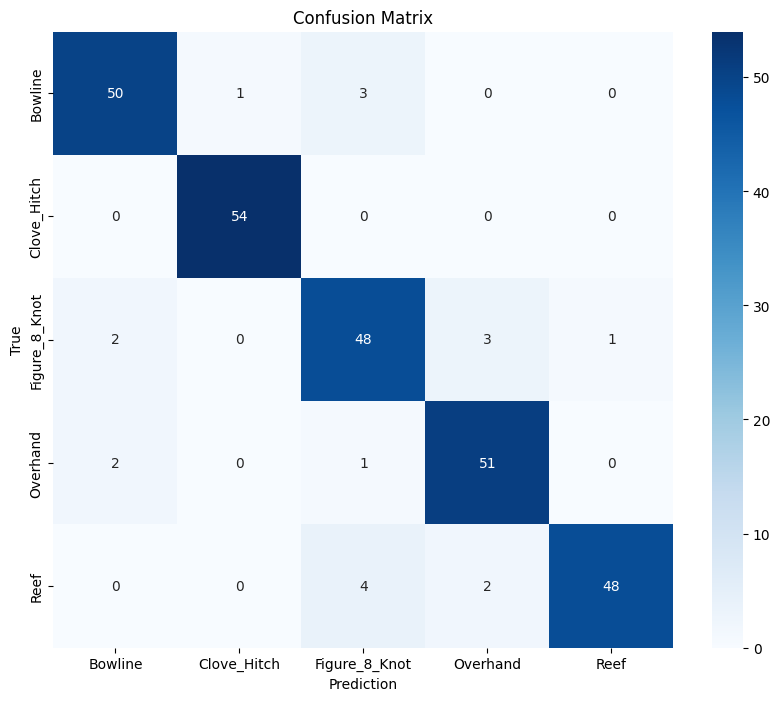

In [ ]:
# Define knot types
knot_types = ['Bowline', 'Clove_Hitch', 'Figure_8_Knot', 'Overhand', 'Reef']

# Plot confusion matrix
confusion_mtx = confusion_matrix(best_labels, best_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=knot_types, yticklabels=knot_types)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

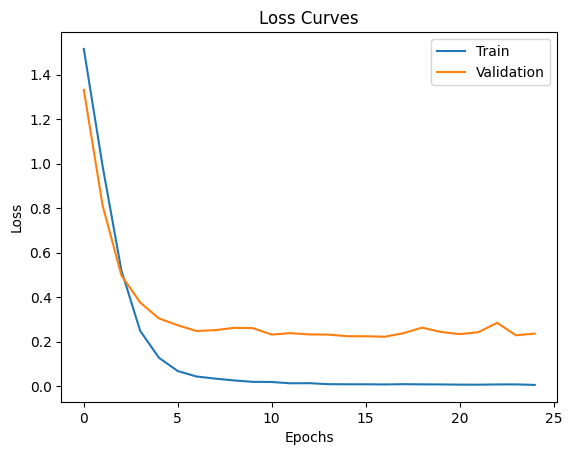

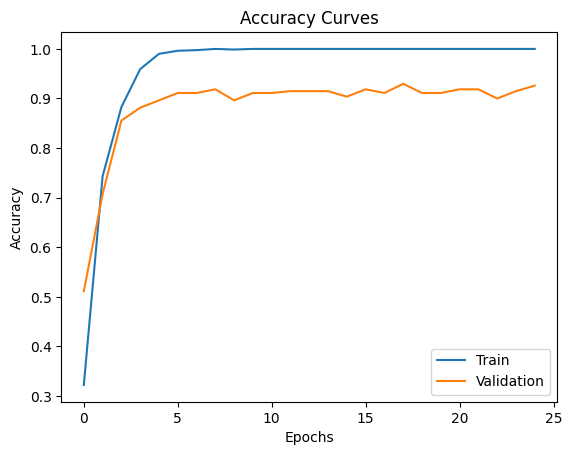

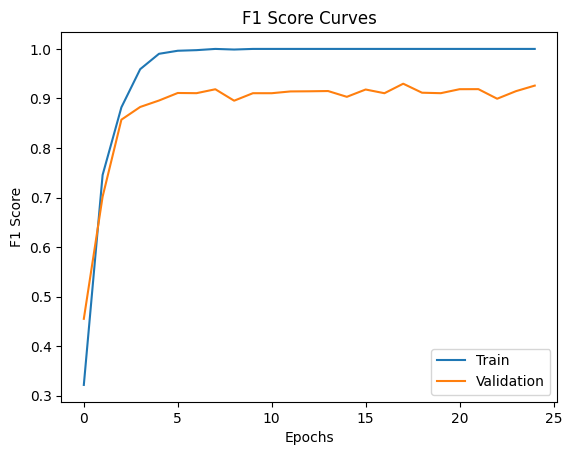

In [ ]:
# Plot loss curves
plt.figure()
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy curves
plt.figure()
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot F1 Score curves
plt.figure()
plt.plot(train_f1_scores, label='Train')
plt.plot(val_f1_scores, label='Validation')
plt.title('F1 Score Curves')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [ ]:
# Use ResNet18(without hyperparameters tuning) as Baseline
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import time
import copy
from torch.utils.data import Dataset
from torchvision.io import read_image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import random


# Connect to the google conlab
drive.mount('/content/drive')


# Use transforms to do data augmentation and preprocess
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(45),  # Rotate randomly between 0 and 45 degrees
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and scale to 224x224 size
    transforms.Grayscale(num_output_channels=3),  # Grayscale
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalization
])





class Knots_Dataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.data = []
        self.labels = []
        self.label_encoder = LabelEncoder()

        # Loop over all conditions
        for knot_type in os.listdir(img_dir):
            for light_condition in os.listdir(os.path.join(img_dir, knot_type)):
                for tension_condition in os.listdir(os.path.join(img_dir, knot_type, light_condition)):
                    images = os.listdir(os.path.join(img_dir, knot_type, light_condition, tension_condition))
                    random.shuffle(images)  # Shuffle the images
                    for image in images:
                        self.data.append(os.path.join(img_dir, knot_type, light_condition, tension_condition, image))
                        self.labels.append(knot_type)

        # Fit the label encoder and transform the labels
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path)
        image = image.convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


# Create a custom data set
dataset = Knots_Dataset("/content/drive/My Drive/MSc Project/rawdata", transform=data_transforms)

# Split the dataset into training set and validation set
train_dataset = []
val_dataset = []
for i in range(len(dataset)):
    if i % 4 == 0:  # Put 25% of the images in the validation set
        val_dataset.append(dataset[i])
    else:  # Put the rest in the training set
        train_dataset.append(dataset[i])

# Create a Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}



# Check if model can be trained on GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Runing on GPU")
    print("CUDA device count: ", torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print("Runing on CPU")


# Save the model results
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []



def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_preds = None
    best_labels = None

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_preds = []
            running_labels = []

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero(clean) the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_preds.extend(preds.cpu().numpy())
                running_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_acc = epoch_acc.cpu().numpy()  # Move tensor to CPU and convert to numpy(debug)
            epoch_f1_score = f1_score(running_labels, running_preds, average='macro')
            epoch_f1_score = torch.tensor(epoch_f1_score).cpu().numpy()  # Move tensor to CPU and convert to numpy(debug)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                train_f1_scores.append(epoch_f1_score)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                val_f1_scores.append(epoch_f1_score)

            print('{} Loss: {:.5f}  Acc: {:.5f}   F1_Score: {:.5f}'.format(
                phase, epoch_loss, epoch_acc, epoch_f1_score))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_preds = running_preds
                best_labels = running_labels

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:5f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, best_preds, best_labels






# Load a pretrained model(ResNet50)
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)  # Change the fc layer to 5
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train and evaluate
model, best_preds, best_labels = train_model(model, criterion, optimizer, num_epochs=25)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Runing on GPU
CUDA device count:  1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 1.43158  Acc: 0.40247   F1_Score: 0.38702
val Loss: 1.15546  Acc: 0.58519   F1_Score: 0.56830

Epoch 1/24
----------
train Loss: 0.80213  Acc: 0.77531   F1_Score: 0.77509
val Loss: 0.77889  Acc: 0.73333   F1_Score: 0.73027

Epoch 2/24
----------
train Loss: 0.47416  Acc: 0.90123   F1_Score: 0.90191
val Loss: 0.53572  Acc: 0.82222   F1_Score: 0.82162

Epoch 3/24
----------
train Loss: 0.25779  Acc: 0.95926   F1_Score: 0.95921
val Loss: 0.42160  Acc: 0.86296   F1_Score: 0.86233

Epoch 4/24
----------
train Loss: 0.14782  Acc: 0.99259   F1_Score: 0.99260
val Loss: 0.34353  Acc: 0.88519   F1_Score: 0.88423

Epoch 5/24
----------
train Loss: 0.10824  Acc: 0.99753   F1_Score: 0.99753
val Loss: 0.30829  Acc: 0.87778   F1_Score: 0.87664

Epoch 6/24
----------
train Loss: 0.06752  Acc: 0.99630   F1_Score: 0.99630
val Loss: 0.30034  Acc: 0.89630   F1_Score: 0.89559

Epoch 7/24
----------
train Loss: 0.05079  Acc: 0.99877   F1_Score: 0.99877
val Loss: 0.25676  Ac

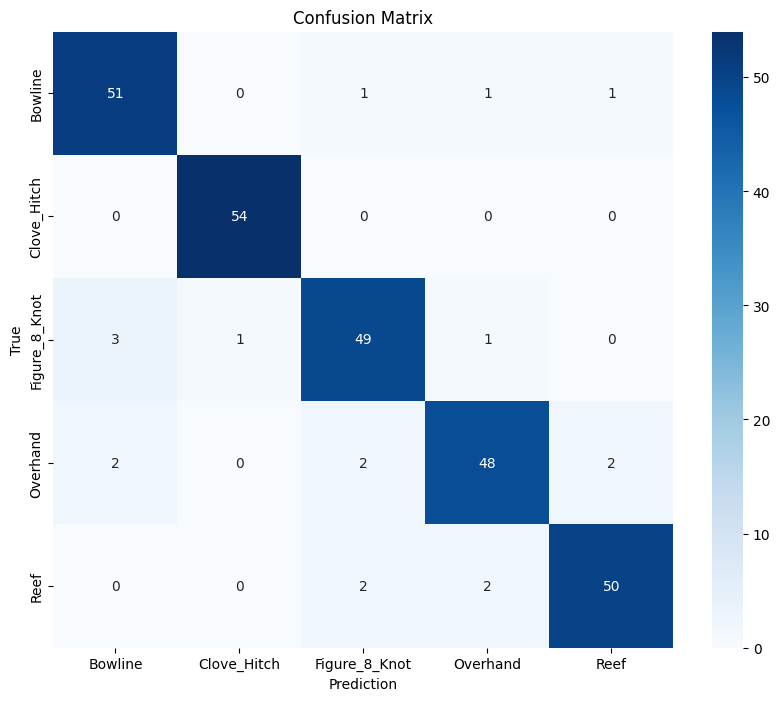

In [ ]:
# Define knot types
knot_types = ['Bowline', 'Clove_Hitch', 'Figure_8_Knot', 'Overhand', 'Reef']

# Plot confusion matrix
confusion_mtx = confusion_matrix(best_labels, best_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=knot_types, yticklabels=knot_types)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

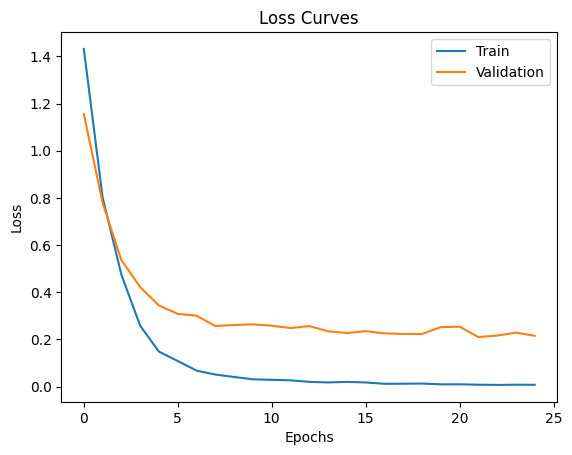

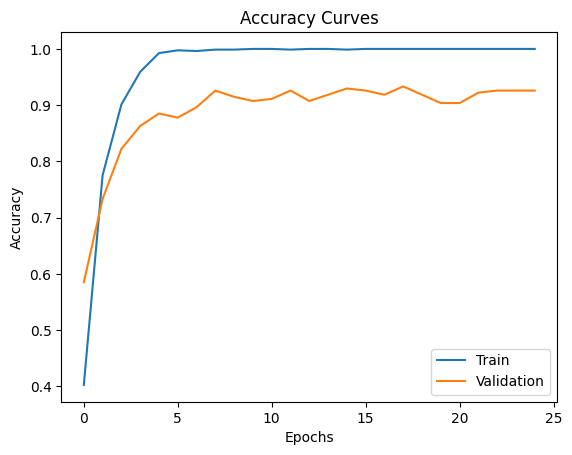

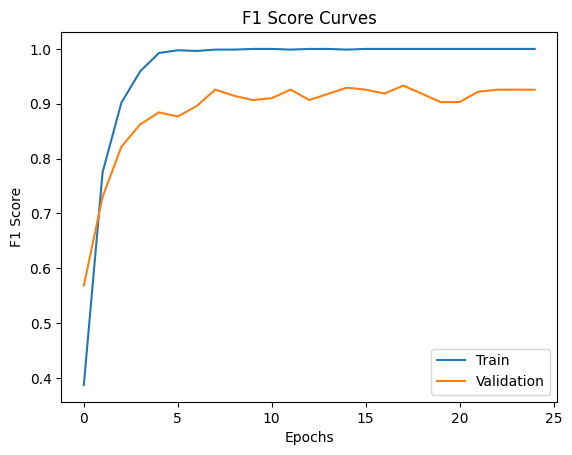

In [ ]:
# Plot loss curves
plt.figure()
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy curves
plt.figure()
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot F1 Score curves
plt.figure()
plt.plot(train_f1_scores, label='Train')
plt.plot(val_f1_scores, label='Validation')
plt.title('F1 Score Curves')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [ ]:
# This part is download the package for the Visual Transformer and EfficientNet

In [1]:
!pip install timm
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
# This part build a ViT modle without/with tuning

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Runing on GPU


Epoch 0/24
----------
train Loss: 1.05823  Acc: 0.61975   F1_Score: 0.61993
val Loss: 0.25266  Acc: 0.90000   F1_Score: 0.89892

Epoch 1/24
----------
train Loss: 0.13359  Acc: 0.95185   F1_Score: 0.95167
val Loss: 0.19998  Acc: 0.95185   F1_Score: 0.95216

Epoch 2/24
----------
train Loss: 0.04201  Acc: 0.98765   F1_Score: 0.98767
val Loss: 0.21361  Acc: 0.93333   F1_Score: 0.93199

Epoch 3/24
----------
train Loss: 0.01646  Acc: 0.99630   F1_Score: 0.99630
val Loss: 0.12682  Acc: 0.96296   F1_Score: 0.96291

Epoch 4/24
----------
train Loss: 0.00218  Acc: 1.00000   F1_Score: 1.00000
val Loss: 0.10921  Acc: 0.95926   F1_Score: 0.95908

Epoch 5/24
----------
train Loss: 0.00061  Acc: 1.00000   F1_Score: 1.00000
val Loss: 0.10636  Acc: 0.97037   F1_Score: 0.97022

Epoch 6/24
----------
train Loss: 0.00036  Acc: 1.00000   F1_Score: 1.00000
val Loss: 0.10515  Acc: 0.97037   F1_Score: 0.97028

Epoch 7/24
----------
train Loss: 0.00030  Acc: 1.00000   F1_Score: 1.00000
val Loss: 0.10425  Ac

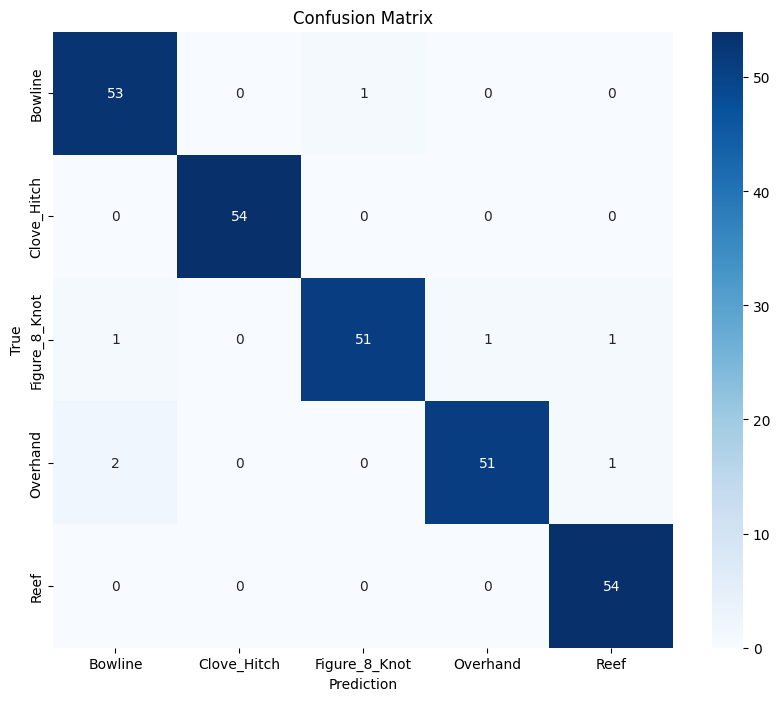

In [ ]:
# Use ViT(vit_large_patch16_224) without tuning
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import time
import copy
from torch.utils.data import Dataset
from torchvision.io import read_image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import random
import timm





# Connect to the google conlab
drive.mount('/content/drive')


# Use transforms to do data augmentation and preprocess
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(45),  # Rotate randomly between 0 and 45 degrees
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and scale to 224x224 size
    transforms.Grayscale(num_output_channels=3),  # Grayscale
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalization
])





class Knots_Dataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.data = []
        self.labels = []
        self.label_encoder = LabelEncoder()

        # Loop over all conditions
        for knot_type in os.listdir(img_dir):
            for light_condition in os.listdir(os.path.join(img_dir, knot_type)):
                for tension_condition in os.listdir(os.path.join(img_dir, knot_type, light_condition)):
                    images = os.listdir(os.path.join(img_dir, knot_type, light_condition, tension_condition))
                    random.shuffle(images)  # Shuffle the images
                    for image in images:
                        self.data.append(os.path.join(img_dir, knot_type, light_condition, tension_condition, image))
                        self.labels.append(knot_type)

        # Fit the label encoder and transform the labels
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path)
        image = image.convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


# Create a custom data set
dataset = Knots_Dataset("/content/drive/My Drive/MSc Project/rawdata", transform=data_transforms)

# Split the dataset into training set and validation set
train_dataset = []
val_dataset = []
for i in range(len(dataset)):
    if i % 4 == 0:  # Put 25% of the images in the validation set
        val_dataset.append(dataset[i])
    else:  # Put the rest in the training set
        train_dataset.append(dataset[i])

# Create a Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}



# Check if model can be trained on GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Runing on GPU")
    print("CUDA device count: ", torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print("Runing on CPU")


# Save the model results
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []



def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0



    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_preds = []
            running_labels = []

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)


                # zero(clean) the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_preds.extend(preds.cpu().numpy())
                running_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_acc = epoch_acc.cpu().numpy()  # Move tensor to CPU and convert to numpy(debug)
            epoch_f1_score = f1_score(running_labels, running_preds, average='macro')
            epoch_f1_score = torch.tensor(epoch_f1_score).cpu().numpy()  # Move tensor to CPU and convert to numpy(debug)



            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                train_f1_scores.append(epoch_f1_score)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                val_f1_scores.append(epoch_f1_score)

            print('{} Loss: {:.5f}  Acc: {:.5f}   F1_Score: {:.5f}'.format(
                phase, epoch_loss, epoch_acc, epoch_f1_score))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:5f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)


    # Define knot types
    knot_types = ['Bowline', 'Clove_Hitch', 'Figure_8_Knot', 'Overhand', 'Reef']

    # Plot confusion matrix
    confusion_mtx = confusion_matrix(running_labels, running_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=knot_types, yticklabels=knot_types)
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


    return model


# Load a pretrained model(ViT)
model = timm.create_model('vit_large_patch16_224', pretrained=True)
num_ftrs = model.head.in_features
model.head = nn.Linear(num_ftrs, 5)  # Change the head layer to 5
model = model.to(device)


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train and evaluate
model = train_model(model, criterion, optimizer, num_epochs=25)



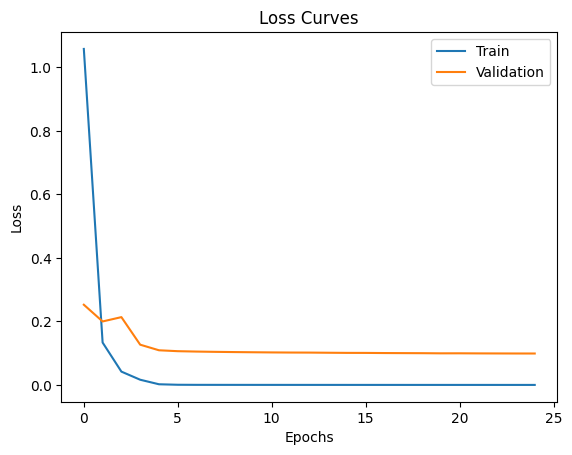

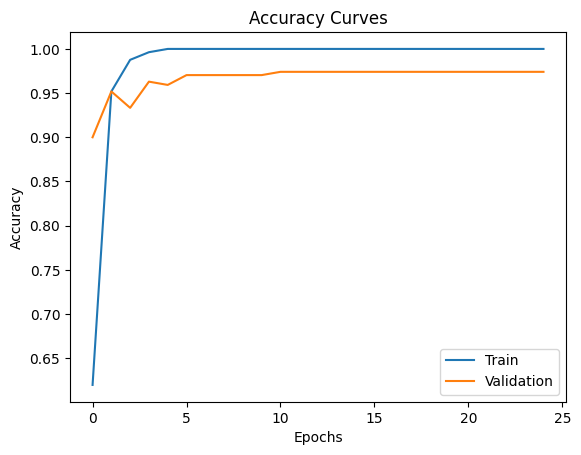

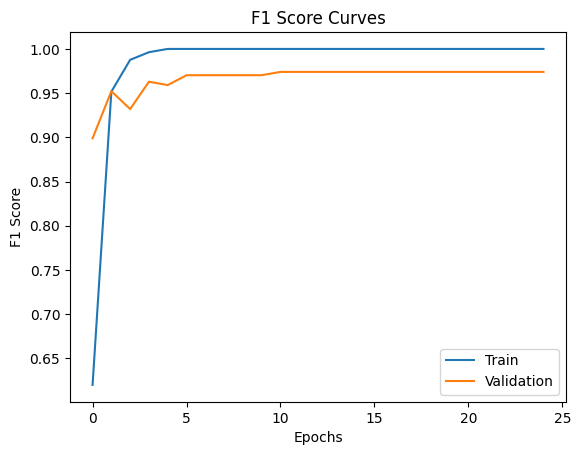

In [ ]:
# Plot loss curves
plt.figure()
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy curves
plt.figure()
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot F1 Score curves
plt.figure()
plt.plot(train_f1_scores, label='Train')
plt.plot(val_f1_scores, label='Validation')
plt.title('F1 Score Curves')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [ ]:
# Use ViT(vit_large_patch16_224) with tuning
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import time
import copy
from torch.utils.data import Dataset
from torchvision.io import read_image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import random
import timm
import optuna

# Connect to the google conlab
drive.mount('/content/drive')

# Use transforms to do data augmentation and preprocess
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(45),  # Rotate randomly between 0 and 45 degrees
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and scale to 224x224 size
    transforms.Grayscale(num_output_channels=3),  # Grayscale
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalization
])

class Knots_Dataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.data = []
        self.labels = []
        self.label_encoder = LabelEncoder()

        # Loop over all conditions
        for knot_type in os.listdir(img_dir):
            for light_condition in os.listdir(os.path.join(img_dir, knot_type)):
                for tension_condition in os.listdir(os.path.join(img_dir, knot_type, light_condition)):
                    images = os.listdir(os.path.join(img_dir, knot_type, light_condition, tension_condition))
                    random.shuffle(images)  # Shuffle the images
                    for image in images:
                        self.data.append(os.path.join(img_dir, knot_type, light_condition, tension_condition, image))
                        self.labels.append(knot_type)

        # Fit the label encoder and transform the labels
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path)
        image = image.convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Create a custom data set
dataset = Knots_Dataset("/content/drive/My Drive/MSc Project/rawdata", transform=data_transforms)

# Split the dataset into training set and validation set
train_dataset = []
val_dataset = []
for i in range(len(dataset)):
    if i % 4 == 0:  # Put 25% of the images in the validation set
        val_dataset.append(dataset[i])
    else:  # Put the rest in the training set
        train_dataset.append(dataset[i])

# Create a Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Check if model can be trained on GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Runing on GPU")
    print("CUDA device count: ", torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print("Runing on CPU")

# Save the model results
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []


def train_model(model, criterion, optimizer, num_epochs=25, accumulation_steps=4):   # Gradient Accumulation to slove the insufficient GPU memory
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_preds = None
    best_labels = None

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_preds = []
            running_labels = []

            # Iterate over data
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs, labels = inputs.to(device), labels.to(device)

                # zero(clean) the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        if (i+1) % accumulation_steps == 0:  # Only update every 'accumulation_steps' steps
                          optimizer.step()
                          optimizer.zero_grad()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_preds.extend(preds.cpu().numpy())
                running_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_acc = epoch_acc.cpu().numpy()  # Move tensor to CPU and convert to numpy(debug)
            epoch_f1_score = f1_score(running_labels, running_preds, average='macro')
            epoch_f1_score = torch.tensor(epoch_f1_score).cpu().numpy()  # Move tensor to CPU and convert to numpy(debug)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                train_f1_scores.append(epoch_f1_score)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                val_f1_scores.append(epoch_f1_score)

            print('{} Loss: {:.5f}  Acc: {:.5f}   F1_Score: {:.5f}'.format(
                phase, epoch_loss, epoch_acc, epoch_f1_score))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_preds = running_preds
                best_labels = running_labels

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:5f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, best_preds, best_labels

# Hyperparameter tune with Optuna
def objective(trial):
    # Suggest values for the hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    optimizer_name = trial.suggest_categorical('optimizer', ['SGD', 'RMSprop']) # AdamW will cause the program collapsed
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)

    # Load a pretrained model(EfficientNet)
    model = timm.create_model('vit_large_patch16_224', pretrained=True)
    num_ftrs = model.head.in_features
    model.head = nn.Linear(num_ftrs, 5)  # Change the head layer to 5
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    # Use the suggested optimizer
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Train and evaluate the model
    model, best_preds, best_labels = train_model(model, criterion, optimizer, num_epochs=25)

    # Return the best validation accuracy
    return max(val_accuracies)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Print the result
# [I 2023-07-21 23:28:59,516] Trial 13 finished with value: 0.9888888888888889
# and parameters: {'lr': 1.0861269711580703e-05, 'optimizer': 'RMSprop', 'weight_decay': 0.000597628202891095}. Best is trial 13 with value: 0.9888888888888889.
best_trial = study.best_trial
print('Best Trial Value: ', best_trial.value)
print('Best Trial Params: ', best_trial.params)

# Use the best hyperparameters to train the model
best_lr = best_trial.params['lr']
best_optimizer_name = best_trial.params['optimizer']
best_weight_decay = best_trial.params['weight_decay']

# Load a pretrained model(EfficientNet)
model = timm.create_model('vit_large_patch16_224', pretrained=True)
num_ftrs = model.head.in_features
model.head = nn.Linear(num_ftrs, 5)  # Change the head layer to 5
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Use the best optimizer
if best_optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
else:
    optimizer = optim.RMSprop(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)

# Train and evaluate the best model
model, best_preds, best_labels = train_model(model, criterion, optimizer, num_epochs=25)



Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[I 2023-07-22 10:13:44,265] A new study created in memory with name: no-name-ed768285-d52d-4a48-a0e1-7b2a7c106a29


Runing on GPU
CUDA device count:  1


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 104.53525  Acc: 0.18148   F1_Score: 0.17447
val Loss: 134.88139  Acc: 0.20000   F1_Score: 0.06667

Epoch 1/24
----------
train Loss: 89.62916  Acc: 0.20864   F1_Score: 0.20446
val Loss: 27.03522  Acc: 0.20000   F1_Score: 0.06667

Epoch 2/24
----------
train Loss: 39.05008  Acc: 0.19259   F1_Score: 0.19048
val Loss: 34.02254  Acc: 0.20000   F1_Score: 0.06667

Epoch 3/24
----------
train Loss: 28.81183  Acc: 0.18395   F1_Score: 0.17941
val Loss: 11.62099  Acc: 0.20000   F1_Score: 0.06667

Epoch 4/24
----------
train Loss: 17.13962  Acc: 0.20123   F1_Score: 0.19874
val Loss: 16.02624  Acc: 0.20000   F1_Score: 0.06667

Epoch 5/24
----------
train Loss: 18.49654  Acc: 0.19506   F1_Score: 0.18119
val Loss: 21.43608  Acc: 0.20000   F1_Score: 0.06667

Epoch 6/24
----------
train Loss: 18.61204  Acc: 0.19753   F1_Score: 0.19121
val Loss: 7.99443  Acc: 0.20000   F1_Score: 0.06667

Epoch 7/24
----------
train Loss: 11.51659  Acc: 0.21111   F1_Score: 0.20526
val L

[I 2023-07-22 10:26:41,957] Trial 0 finished with value: 0.20370370370370372 and parameters: {'lr': 0.00774702127133027, 'optimizer': 'RMSprop', 'weight_decay': 3.022496188853879e-09}. Best is trial 0 with value: 0.20370370370370372.


val Loss: 3.52619  Acc: 0.20000   F1_Score: 0.06667

Training complete in 11m 47s
Best val Acc: 0.203704


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 16.68977  Acc: 0.16790   F1_Score: 0.16243
val Loss: 21.06194  Acc: 0.20000   F1_Score: 0.06667

Epoch 1/24
----------
train Loss: 12.26248  Acc: 0.19136   F1_Score: 0.18659
val Loss: 7.38561  Acc: 0.20000   F1_Score: 0.06667

Epoch 2/24
----------
train Loss: 4.03397  Acc: 0.22222   F1_Score: 0.21886
val Loss: 4.21655  Acc: 0.20000   F1_Score: 0.06667

Epoch 3/24
----------
train Loss: 2.98956  Acc: 0.20988   F1_Score: 0.20581
val Loss: 2.47174  Acc: 0.20370   F1_Score: 0.11613

Epoch 4/24
----------
train Loss: 2.50315  Acc: 0.17284   F1_Score: 0.16356
val Loss: 2.13717  Acc: 0.20000   F1_Score: 0.06667

Epoch 5/24
----------
train Loss: 2.38533  Acc: 0.19877   F1_Score: 0.14335
val Loss: 1.95972  Acc: 0.20000   F1_Score: 0.06667

Epoch 6/24
----------
train Loss: 2.20032  Acc: 0.19753   F1_Score: 0.19503
val Loss: 2.04729  Acc: 0.20000   F1_Score: 0.06667

Epoch 7/24
----------
train Loss: 2.24980  Acc: 0.21358   F1_Score: 0.19866
val Loss: 2.34251 

[I 2023-07-22 10:38:33,245] Trial 1 finished with value: 0.20740740740740743 and parameters: {'lr': 0.0005118353168115592, 'optimizer': 'RMSprop', 'weight_decay': 2.0057330451930757e-06}. Best is trial 1 with value: 0.20740740740740743.


val Loss: 1.86974  Acc: 0.20000   F1_Score: 0.06708

Training complete in 11m 46s
Best val Acc: 0.207407


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 2.00007  Acc: 0.16790   F1_Score: 0.15921
val Loss: 1.88703  Acc: 0.18889   F1_Score: 0.15289

Epoch 1/24
----------
train Loss: 1.74347  Acc: 0.21111   F1_Score: 0.21088
val Loss: 1.65774  Acc: 0.27037   F1_Score: 0.25047

Epoch 2/24
----------
train Loss: 1.57202  Acc: 0.31605   F1_Score: 0.30947
val Loss: 1.50842  Acc: 0.34815   F1_Score: 0.33326

Epoch 3/24
----------
train Loss: 1.43655  Acc: 0.41111   F1_Score: 0.40799
val Loss: 1.41466  Acc: 0.42593   F1_Score: 0.41491

Epoch 4/24
----------
train Loss: 1.31950  Acc: 0.46420   F1_Score: 0.46608
val Loss: 1.32468  Acc: 0.47407   F1_Score: 0.47373

Epoch 5/24
----------
train Loss: 1.21008  Acc: 0.56173   F1_Score: 0.55966
val Loss: 1.24122  Acc: 0.50741   F1_Score: 0.49182

Epoch 6/24
----------
train Loss: 1.12668  Acc: 0.63210   F1_Score: 0.62482
val Loss: 1.16802  Acc: 0.57407   F1_Score: 0.55605

Epoch 7/24
----------
train Loss: 1.04419  Acc: 0.63580   F1_Score: 0.62844
val Loss: 1.06863  Ac

[I 2023-07-22 10:50:27,070] Trial 2 finished with value: 0.8333333333333334 and parameters: {'lr': 0.0003103047323493566, 'optimizer': 'SGD', 'weight_decay': 1.3323055263057714e-07}. Best is trial 2 with value: 0.8333333333333334.


val Loss: 0.50159  Acc: 0.82963   F1_Score: 0.82968

Training complete in 11m 49s
Best val Acc: 0.833333


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 9.66968  Acc: 0.20741   F1_Score: 0.19178
val Loss: 8.00670  Acc: 0.20000   F1_Score: 0.06667

Epoch 1/24
----------
train Loss: 3.15669  Acc: 0.18395   F1_Score: 0.16000
val Loss: 2.12565  Acc: 0.20000   F1_Score: 0.06687

Epoch 2/24
----------
train Loss: 2.07499  Acc: 0.20988   F1_Score: 0.18214
val Loss: 1.85573  Acc: 0.20000   F1_Score: 0.06667

Epoch 3/24
----------
train Loss: 1.79945  Acc: 0.18889   F1_Score: 0.15444
val Loss: 1.83422  Acc: 0.20000   F1_Score: 0.06667

Epoch 4/24
----------
train Loss: 1.79161  Acc: 0.19012   F1_Score: 0.16071
val Loss: 1.68199  Acc: 0.20000   F1_Score: 0.06667

Epoch 5/24
----------
train Loss: 1.74485  Acc: 0.19630   F1_Score: 0.14100
val Loss: 1.80433  Acc: 0.20000   F1_Score: 0.06667

Epoch 6/24
----------
train Loss: 1.76139  Acc: 0.19383   F1_Score: 0.16545
val Loss: 1.62039  Acc: 0.20000   F1_Score: 0.06667

Epoch 7/24
----------
train Loss: 1.65394  Acc: 0.19136   F1_Score: 0.14361
val Loss: 1.67721  Ac

[I 2023-07-22 11:02:18,901] Trial 3 finished with value: 0.8333333333333334 and parameters: {'lr': 6.563922902917936e-05, 'optimizer': 'RMSprop', 'weight_decay': 7.947582476721263e-10}. Best is trial 2 with value: 0.8333333333333334.


val Loss: 1.63536  Acc: 0.20000   F1_Score: 0.06667

Training complete in 11m 47s
Best val Acc: 0.259259


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 1.99031  Acc: 0.27531   F1_Score: 0.27101
val Loss: 1.62522  Acc: 0.37778   F1_Score: 0.29980

Epoch 1/24
----------
train Loss: 1.28037  Acc: 0.49012   F1_Score: 0.49095
val Loss: 1.08417  Acc: 0.61111   F1_Score: 0.56160

Epoch 2/24
----------
train Loss: 0.96321  Acc: 0.64444   F1_Score: 0.64135
val Loss: 1.13483  Acc: 0.59259   F1_Score: 0.51475

Epoch 3/24
----------
train Loss: 0.75713  Acc: 0.70247   F1_Score: 0.70175
val Loss: 0.90927  Acc: 0.65185   F1_Score: 0.61380

Epoch 4/24
----------
train Loss: 0.63590  Acc: 0.76296   F1_Score: 0.75884
val Loss: 0.63468  Acc: 0.78889   F1_Score: 0.79137

Epoch 5/24
----------
train Loss: 0.49452  Acc: 0.82963   F1_Score: 0.83078
val Loss: 0.56118  Acc: 0.79630   F1_Score: 0.79207

Epoch 6/24
----------
train Loss: 0.41370  Acc: 0.88519   F1_Score: 0.88507
val Loss: 0.48002  Acc: 0.84074   F1_Score: 0.83841

Epoch 7/24
----------
train Loss: 0.36156  Acc: 0.89753   F1_Score: 0.89731
val Loss: 0.62123  Ac

[I 2023-07-22 11:14:12,355] Trial 4 finished with value: 0.9370370370370371 and parameters: {'lr': 0.0010522510090843526, 'optimizer': 'SGD', 'weight_decay': 0.000632316503286168}. Best is trial 4 with value: 0.9370370370370371.


val Loss: 0.22847  Acc: 0.93704   F1_Score: 0.93732

Training complete in 11m 49s
Best val Acc: 0.937037


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 1.87240  Acc: 0.25062   F1_Score: 0.24601
val Loss: 1.66674  Acc: 0.30741   F1_Score: 0.27176

Epoch 1/24
----------
train Loss: 1.55858  Acc: 0.34568   F1_Score: 0.34100
val Loss: 1.51545  Acc: 0.40000   F1_Score: 0.36637

Epoch 2/24
----------
train Loss: 1.36436  Acc: 0.43827   F1_Score: 0.42863
val Loss: 1.40795  Acc: 0.43333   F1_Score: 0.39100

Epoch 3/24
----------
train Loss: 1.17652  Acc: 0.55309   F1_Score: 0.54292
val Loss: 1.19628  Acc: 0.53704   F1_Score: 0.52731

Epoch 4/24
----------
train Loss: 1.02507  Acc: 0.61975   F1_Score: 0.61599
val Loss: 1.11892  Acc: 0.55185   F1_Score: 0.54386

Epoch 5/24
----------
train Loss: 0.92677  Acc: 0.67160   F1_Score: 0.66954
val Loss: 1.04225  Acc: 0.61852   F1_Score: 0.61906

Epoch 6/24
----------
train Loss: 0.82295  Acc: 0.73210   F1_Score: 0.73087
val Loss: 0.89442  Acc: 0.68889   F1_Score: 0.68411

Epoch 7/24
----------
train Loss: 0.74315  Acc: 0.76790   F1_Score: 0.76890
val Loss: 0.82419  Ac

[I 2023-07-22 11:26:06,063] Trial 5 finished with value: 0.9370370370370371 and parameters: {'lr': 0.0005320444833431639, 'optimizer': 'SGD', 'weight_decay': 2.982909451327834e-07}. Best is trial 4 with value: 0.9370370370370371.


val Loss: 0.36473  Acc: 0.90370   F1_Score: 0.90338

Training complete in 11m 49s
Best val Acc: 0.903704


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 2.48109  Acc: 0.22469   F1_Score: 0.16200
val Loss: 2.44728  Acc: 0.18519   F1_Score: 0.13365

Epoch 1/24
----------
train Loss: 2.34443  Acc: 0.22593   F1_Score: 0.16641
val Loss: 2.31859  Acc: 0.18889   F1_Score: 0.14532

Epoch 2/24
----------
train Loss: 2.23746  Acc: 0.22593   F1_Score: 0.16980
val Loss: 2.21835  Acc: 0.19630   F1_Score: 0.15192

Epoch 3/24
----------
train Loss: 2.15149  Acc: 0.22716   F1_Score: 0.17631
val Loss: 2.14118  Acc: 0.20741   F1_Score: 0.16100

Epoch 4/24
----------
train Loss: 2.08501  Acc: 0.23580   F1_Score: 0.18781
val Loss: 2.08296  Acc: 0.20741   F1_Score: 0.16978

Epoch 5/24
----------
train Loss: 2.03284  Acc: 0.23580   F1_Score: 0.19199
val Loss: 2.03625  Acc: 0.21852   F1_Score: 0.17695

Epoch 6/24
----------
train Loss: 1.98761  Acc: 0.23951   F1_Score: 0.19621
val Loss: 1.99336  Acc: 0.21852   F1_Score: 0.17737

Epoch 7/24
----------
train Loss: 1.95043  Acc: 0.22840   F1_Score: 0.19167
val Loss: 1.94594  Ac

[I 2023-07-22 11:38:00,612] Trial 6 finished with value: 0.9370370370370371 and parameters: {'lr': 1.9973298657573678e-05, 'optimizer': 'SGD', 'weight_decay': 1.4830391985122842e-06}. Best is trial 4 with value: 0.9370370370370371.


val Loss: 1.69051  Acc: 0.23704   F1_Score: 0.23555

Training complete in 11m 49s
Best val Acc: 0.237037


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 10.23327  Acc: 0.20864   F1_Score: 0.20495
val Loss: 11.14990  Acc: 0.25926   F1_Score: 0.14901

Epoch 1/24
----------
train Loss: 6.78742  Acc: 0.17654   F1_Score: 0.17653
val Loss: 4.90526  Acc: 0.20000   F1_Score: 0.06667

Epoch 2/24
----------
train Loss: 6.90649  Acc: 0.20864   F1_Score: 0.20749
val Loss: 2.56565  Acc: 0.20000   F1_Score: 0.06667

Epoch 3/24
----------
train Loss: 2.05977  Acc: 0.20864   F1_Score: 0.20741
val Loss: 1.65982  Acc: 0.20000   F1_Score: 0.06667

Epoch 4/24
----------
train Loss: 1.67722  Acc: 0.21852   F1_Score: 0.17992
val Loss: 1.65364  Acc: 0.20000   F1_Score: 0.06667

Epoch 5/24
----------
train Loss: 1.67621  Acc: 0.22716   F1_Score: 0.20858
val Loss: 1.63026  Acc: 0.20000   F1_Score: 0.06687

Epoch 6/24
----------
train Loss: 1.58071  Acc: 0.30988   F1_Score: 0.27251
val Loss: 1.54784  Acc: 0.40000   F1_Score: 0.26737

Epoch 7/24
----------
train Loss: 1.30397  Acc: 0.44321   F1_Score: 0.43171
val Loss: 1.19722  

[I 2023-07-22 11:49:55,285] Trial 7 finished with value: 0.9407407407407408 and parameters: {'lr': 0.007878881630176653, 'optimizer': 'SGD', 'weight_decay': 1.7681779488551472e-09}. Best is trial 7 with value: 0.9407407407407408.


val Loss: 0.16734  Acc: 0.94074   F1_Score: 0.93946

Training complete in 11m 49s
Best val Acc: 0.940741


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 6.82406  Acc: 0.23210   F1_Score: 0.23090
val Loss: 4.05526  Acc: 0.30741   F1_Score: 0.17476

Epoch 1/24
----------
train Loss: 2.29268  Acc: 0.44568   F1_Score: 0.44147
val Loss: 0.90567  Acc: 0.68519   F1_Score: 0.66180

Epoch 2/24
----------
train Loss: 0.56904  Acc: 0.79630   F1_Score: 0.79538
val Loss: 0.54303  Acc: 0.79630   F1_Score: 0.80026

Epoch 3/24
----------
train Loss: 0.34823  Acc: 0.87037   F1_Score: 0.87081
val Loss: 0.40583  Acc: 0.82963   F1_Score: 0.83188

Epoch 4/24
----------
train Loss: 0.22597  Acc: 0.93210   F1_Score: 0.93241
val Loss: 0.35693  Acc: 0.87407   F1_Score: 0.87060

Epoch 5/24
----------
train Loss: 0.15651  Acc: 0.95679   F1_Score: 0.95661
val Loss: 0.29207  Acc: 0.90370   F1_Score: 0.90475

Epoch 6/24
----------
train Loss: 0.13595  Acc: 0.96790   F1_Score: 0.96792
val Loss: 0.26808  Acc: 0.90000   F1_Score: 0.89924

Epoch 7/24
----------
train Loss: 0.08303  Acc: 0.98765   F1_Score: 0.98766
val Loss: 0.24064  Ac

[I 2023-07-22 12:01:49,690] Trial 8 finished with value: 0.9444444444444445 and parameters: {'lr': 0.003450921911300035, 'optimizer': 'SGD', 'weight_decay': 2.2338362463374648e-05}. Best is trial 8 with value: 0.9444444444444445.


val Loss: 0.16629  Acc: 0.94074   F1_Score: 0.94003

Training complete in 11m 49s
Best val Acc: 0.944444


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 1.97921  Acc: 0.18519   F1_Score: 0.17665
val Loss: 1.82893  Acc: 0.18519   F1_Score: 0.18321

Epoch 1/24
----------
train Loss: 1.78912  Acc: 0.22099   F1_Score: 0.21867
val Loss: 1.72311  Acc: 0.23333   F1_Score: 0.21772

Epoch 2/24
----------
train Loss: 1.65930  Acc: 0.26420   F1_Score: 0.26428
val Loss: 1.65270  Acc: 0.28519   F1_Score: 0.27217

Epoch 3/24
----------
train Loss: 1.56852  Acc: 0.31605   F1_Score: 0.31819
val Loss: 1.55387  Acc: 0.31481   F1_Score: 0.31725

Epoch 4/24
----------
train Loss: 1.48105  Acc: 0.36296   F1_Score: 0.36320
val Loss: 1.48134  Acc: 0.35926   F1_Score: 0.35383

Epoch 5/24
----------
train Loss: 1.40144  Acc: 0.41605   F1_Score: 0.41159
val Loss: 1.41739  Acc: 0.38889   F1_Score: 0.37937

Epoch 6/24
----------
train Loss: 1.33844  Acc: 0.45309   F1_Score: 0.43618
val Loss: 1.40528  Acc: 0.46667   F1_Score: 0.42902

Epoch 7/24
----------
train Loss: 1.28534  Acc: 0.48889   F1_Score: 0.48119
val Loss: 1.32663  Ac

[I 2023-07-22 12:13:44,465] Trial 9 finished with value: 0.9444444444444445 and parameters: {'lr': 0.00017113149688124273, 'optimizer': 'SGD', 'weight_decay': 7.948069755429873e-10}. Best is trial 8 with value: 0.9444444444444445.


val Loss: 0.76976  Acc: 0.75926   F1_Score: 0.75733

Training complete in 11m 49s
Best val Acc: 0.759259


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 26.31952  Acc: 0.20494   F1_Score: 0.17159
val Loss: 42.98281  Acc: 0.20000   F1_Score: 0.06667

Epoch 1/24
----------
train Loss: 32.72121  Acc: 0.22716   F1_Score: 0.22411
val Loss: 23.83505  Acc: 0.20000   F1_Score: 0.06667

Epoch 2/24
----------
train Loss: 14.84996  Acc: 0.19259   F1_Score: 0.18783
val Loss: 19.16714  Acc: 0.20000   F1_Score: 0.06667

Epoch 3/24
----------
train Loss: 10.66261  Acc: 0.17531   F1_Score: 0.17180
val Loss: 8.47321  Acc: 0.20000   F1_Score: 0.06667

Epoch 4/24
----------
train Loss: 8.53257  Acc: 0.21111   F1_Score: 0.20459
val Loss: 10.75328  Acc: 0.20000   F1_Score: 0.06667

Epoch 5/24
----------
train Loss: 5.66204  Acc: 0.19630   F1_Score: 0.18611
val Loss: 7.92814  Acc: 0.20000   F1_Score: 0.06667

Epoch 6/24
----------
train Loss: 6.27668  Acc: 0.19753   F1_Score: 0.18627
val Loss: 3.78500  Acc: 0.20000   F1_Score: 0.06667

Epoch 7/24
----------
train Loss: 5.00389  Acc: 0.20123   F1_Score: 0.17375
val Loss: 6.8

[I 2023-07-22 12:25:34,844] Trial 10 finished with value: 0.9444444444444445 and parameters: {'lr': 0.002127853638493345, 'optimizer': 'RMSprop', 'weight_decay': 0.000174178505839386}. Best is trial 8 with value: 0.9444444444444445.


val Loss: 2.18734  Acc: 0.20000   F1_Score: 0.06667

Training complete in 11m 45s
Best val Acc: 0.200000


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 2.15972  Acc: 0.18889   F1_Score: 0.15731
val Loss: 1.92062  Acc: 0.15556   F1_Score: 0.14429

Epoch 1/24
----------
train Loss: 1.84066  Acc: 0.20988   F1_Score: 0.20592
val Loss: 1.78071  Acc: 0.22222   F1_Score: 0.20675

Epoch 2/24
----------
train Loss: 1.71311  Acc: 0.24198   F1_Score: 0.23976
val Loss: 1.68999  Acc: 0.26667   F1_Score: 0.25688

Epoch 3/24
----------
train Loss: 1.63430  Acc: 0.25679   F1_Score: 0.25067
val Loss: 1.62031  Acc: 0.27407   F1_Score: 0.27144

Epoch 4/24
----------
train Loss: 1.55086  Acc: 0.30988   F1_Score: 0.30811
val Loss: 1.54534  Acc: 0.32593   F1_Score: 0.32008

Epoch 5/24
----------
train Loss: 1.48033  Acc: 0.35309   F1_Score: 0.35454
val Loss: 1.49504  Acc: 0.36296   F1_Score: 0.36567

Epoch 6/24
----------
train Loss: 1.41497  Acc: 0.40370   F1_Score: 0.40108
val Loss: 1.43169  Acc: 0.42963   F1_Score: 0.41783

Epoch 7/24
----------
train Loss: 1.35956  Acc: 0.43580   F1_Score: 0.43217
val Loss: 1.38454  Ac

[I 2023-07-22 12:37:29,652] Trial 11 finished with value: 0.9444444444444445 and parameters: {'lr': 0.0001603623203200698, 'optimizer': 'SGD', 'weight_decay': 2.92506026395324e-10}. Best is trial 8 with value: 0.9444444444444445.


val Loss: 0.82676  Acc: 0.73704   F1_Score: 0.73216

Training complete in 11m 49s
Best val Acc: 0.762963


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 3.81874  Acc: 0.25432   F1_Score: 0.25333
val Loss: 3.02515  Acc: 0.43704   F1_Score: 0.37920

Epoch 1/24
----------
train Loss: 2.24376  Acc: 0.44815   F1_Score: 0.44246
val Loss: 2.74141  Acc: 0.41852   F1_Score: 0.34938

Epoch 2/24
----------
train Loss: 1.18094  Acc: 0.64568   F1_Score: 0.64464
val Loss: 0.63177  Acc: 0.72963   F1_Score: 0.72876

Epoch 3/24
----------
train Loss: 0.41137  Acc: 0.86296   F1_Score: 0.86352
val Loss: 0.59047  Acc: 0.74444   F1_Score: 0.73159

Epoch 4/24
----------
train Loss: 0.29520  Acc: 0.90247   F1_Score: 0.90228
val Loss: 0.42199  Acc: 0.82963   F1_Score: 0.83151

Epoch 5/24
----------
train Loss: 0.20032  Acc: 0.95185   F1_Score: 0.95188
val Loss: 0.29023  Acc: 0.90000   F1_Score: 0.90166

Epoch 6/24
----------
train Loss: 0.14304  Acc: 0.97531   F1_Score: 0.97531
val Loss: 0.25764  Acc: 0.92593   F1_Score: 0.92655

Epoch 7/24
----------
train Loss: 0.10887  Acc: 0.98519   F1_Score: 0.98522
val Loss: 0.22636  Ac

[I 2023-07-22 12:49:24,359] Trial 12 finished with value: 0.9555555555555556 and parameters: {'lr': 0.002348302389165827, 'optimizer': 'SGD', 'weight_decay': 1.0700688938483759e-10}. Best is trial 12 with value: 0.9555555555555556.


val Loss: 0.13425  Acc: 0.94815   F1_Score: 0.94810

Training complete in 11m 50s
Best val Acc: 0.955556


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 5.19882  Acc: 0.24568   F1_Score: 0.24396
val Loss: 2.45046  Acc: 0.34444   F1_Score: 0.27580

Epoch 1/24
----------
train Loss: 2.09036  Acc: 0.44938   F1_Score: 0.45420
val Loss: 1.27641  Acc: 0.62593   F1_Score: 0.57827

Epoch 2/24
----------
train Loss: 0.87683  Acc: 0.73704   F1_Score: 0.73740
val Loss: 0.78331  Acc: 0.71852   F1_Score: 0.68098

Epoch 3/24
----------
train Loss: 0.42504  Acc: 0.85556   F1_Score: 0.85491
val Loss: 0.43426  Acc: 0.83704   F1_Score: 0.83166

Epoch 4/24
----------
train Loss: 0.22445  Acc: 0.93827   F1_Score: 0.93810
val Loss: 0.31850  Acc: 0.87778   F1_Score: 0.87921

Epoch 5/24
----------
train Loss: 0.18241  Acc: 0.95185   F1_Score: 0.95181
val Loss: 0.26476  Acc: 0.90000   F1_Score: 0.90063

Epoch 6/24
----------
train Loss: 0.13619  Acc: 0.96790   F1_Score: 0.96783
val Loss: 0.24320  Acc: 0.92222   F1_Score: 0.92167

Epoch 7/24
----------
train Loss: 0.10627  Acc: 0.97901   F1_Score: 0.97898
val Loss: 0.23412  Ac

[I 2023-07-22 13:01:19,492] Trial 13 finished with value: 0.9740740740740741 and parameters: {'lr': 0.002627175153271954, 'optimizer': 'SGD', 'weight_decay': 1.3534122650251788e-08}. Best is trial 13 with value: 0.9740740740740741.


val Loss: 0.13060  Acc: 0.97037   F1_Score: 0.97042

Training complete in 11m 50s
Best val Acc: 0.974074


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 4.04966  Acc: 0.21481   F1_Score: 0.21323
val Loss: 4.29017  Acc: 0.34815   F1_Score: 0.22362

Epoch 1/24
----------
train Loss: 2.87726  Acc: 0.40000   F1_Score: 0.39127
val Loss: 1.81106  Acc: 0.37778   F1_Score: 0.32966

Epoch 2/24
----------
train Loss: 1.41542  Acc: 0.56667   F1_Score: 0.57358
val Loss: 0.72593  Acc: 0.73704   F1_Score: 0.73297

Epoch 3/24
----------
train Loss: 0.54758  Acc: 0.80988   F1_Score: 0.80943
val Loss: 0.54215  Acc: 0.80741   F1_Score: 0.80842

Epoch 4/24
----------
train Loss: 0.44241  Acc: 0.84938   F1_Score: 0.85056
val Loss: 0.40508  Acc: 0.88148   F1_Score: 0.88300

Epoch 5/24
----------
train Loss: 0.26853  Acc: 0.92469   F1_Score: 0.92412
val Loss: 0.39314  Acc: 0.85926   F1_Score: 0.86205

Epoch 6/24
----------
train Loss: 0.21266  Acc: 0.93951   F1_Score: 0.93943
val Loss: 0.32895  Acc: 0.90000   F1_Score: 0.90062

Epoch 7/24
----------
train Loss: 0.18274  Acc: 0.95309   F1_Score: 0.95279
val Loss: 0.34049  Ac

[I 2023-07-22 13:13:14,685] Trial 14 finished with value: 0.9740740740740741 and parameters: {'lr': 0.0019514369625945034, 'optimizer': 'SGD', 'weight_decay': 1.4064016643800358e-10}. Best is trial 13 with value: 0.9740740740740741.


val Loss: 0.16846  Acc: 0.94815   F1_Score: 0.94838

Training complete in 11m 50s
Best val Acc: 0.955556


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 2.33726  Acc: 0.24074   F1_Score: 0.23335
val Loss: 2.60891  Acc: 0.22963   F1_Score: 0.12814

Epoch 1/24
----------
train Loss: 1.78859  Acc: 0.37407   F1_Score: 0.38105
val Loss: 1.53617  Acc: 0.54074   F1_Score: 0.49080

Epoch 2/24
----------
train Loss: 1.46618  Acc: 0.51235   F1_Score: 0.50420
val Loss: 0.87287  Acc: 0.66667   F1_Score: 0.65795

Epoch 3/24
----------
train Loss: 0.88327  Acc: 0.66790   F1_Score: 0.66719
val Loss: 0.74055  Acc: 0.78519   F1_Score: 0.77501

Epoch 4/24
----------
train Loss: 0.63434  Acc: 0.79259   F1_Score: 0.79197
val Loss: 0.68636  Acc: 0.76667   F1_Score: 0.74281

Epoch 5/24
----------
train Loss: 0.54896  Acc: 0.84074   F1_Score: 0.83993
val Loss: 0.53069  Acc: 0.85556   F1_Score: 0.85361

Epoch 6/24
----------
train Loss: 0.46169  Acc: 0.85432   F1_Score: 0.85480
val Loss: 0.44765  Acc: 0.87407   F1_Score: 0.87465

Epoch 7/24
----------
train Loss: 0.32945  Acc: 0.93086   F1_Score: 0.93053
val Loss: 0.40724  Ac

[I 2023-07-22 13:25:09,955] Trial 15 finished with value: 0.9740740740740741 and parameters: {'lr': 0.0011435925318483452, 'optimizer': 'SGD', 'weight_decay': 1.779640113428584e-08}. Best is trial 13 with value: 0.9740740740740741.


val Loss: 0.16433  Acc: 0.94815   F1_Score: 0.94808

Training complete in 11m 50s
Best val Acc: 0.955556


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 13.03329  Acc: 0.21728   F1_Score: 0.19247
val Loss: 21.16531  Acc: 0.20000   F1_Score: 0.06667

Epoch 1/24
----------
train Loss: 12.57091  Acc: 0.19877   F1_Score: 0.17674
val Loss: 11.03031  Acc: 0.20000   F1_Score: 0.06667

Epoch 2/24
----------
train Loss: 6.25732  Acc: 0.21481   F1_Score: 0.20522
val Loss: 6.33959  Acc: 0.21481   F1_Score: 0.12172

Epoch 3/24
----------
train Loss: 3.93491  Acc: 0.23704   F1_Score: 0.23592
val Loss: 3.00189  Acc: 0.20000   F1_Score: 0.06667

Epoch 4/24
----------
train Loss: 2.14745  Acc: 0.22222   F1_Score: 0.22166
val Loss: 1.79772  Acc: 0.20000   F1_Score: 0.06667

Epoch 5/24
----------
train Loss: 1.75203  Acc: 0.19506   F1_Score: 0.17091
val Loss: 1.60801  Acc: 0.23704   F1_Score: 0.14712

Epoch 6/24
----------
train Loss: 1.58438  Acc: 0.25556   F1_Score: 0.23070
val Loss: 1.60416  Acc: 0.26667   F1_Score: 0.17743

Epoch 7/24
----------
train Loss: 1.58490  Acc: 0.28642   F1_Score: 0.27003
val Loss: 1.65294

[I 2023-07-22 13:37:04,784] Trial 16 finished with value: 0.9740740740740741 and parameters: {'lr': 0.00953821990943573, 'optimizer': 'SGD', 'weight_decay': 8.505861380520668e-09}. Best is trial 13 with value: 0.9740740740740741.


val Loss: 0.27590  Acc: 0.90000   F1_Score: 0.89878

Training complete in 11m 49s
Best val Acc: 0.900000


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 5.85023  Acc: 0.21111   F1_Score: 0.21043
val Loss: 5.49244  Acc: 0.37037   F1_Score: 0.30351

Epoch 1/24
----------
train Loss: 2.48156  Acc: 0.49136   F1_Score: 0.48160
val Loss: 0.78917  Acc: 0.67778   F1_Score: 0.68562

Epoch 2/24
----------
train Loss: 0.55176  Acc: 0.79630   F1_Score: 0.79560
val Loss: 0.51320  Acc: 0.82222   F1_Score: 0.81971

Epoch 3/24
----------
train Loss: 0.34923  Acc: 0.87901   F1_Score: 0.87840
val Loss: 0.53922  Acc: 0.77778   F1_Score: 0.78410

Epoch 4/24
----------
train Loss: 0.28498  Acc: 0.90494   F1_Score: 0.90543
val Loss: 0.37296  Acc: 0.85926   F1_Score: 0.85779

Epoch 5/24
----------
train Loss: 0.18376  Acc: 0.95185   F1_Score: 0.95169
val Loss: 0.29471  Acc: 0.88148   F1_Score: 0.88097

Epoch 6/24
----------
train Loss: 0.14115  Acc: 0.96543   F1_Score: 0.96523
val Loss: 0.28512  Acc: 0.90741   F1_Score: 0.90660

Epoch 7/24
----------
train Loss: 0.11895  Acc: 0.97284   F1_Score: 0.97289
val Loss: 0.25474  Ac

[I 2023-07-22 13:48:59,047] Trial 17 finished with value: 0.9740740740740741 and parameters: {'lr': 0.0025984895772912815, 'optimizer': 'SGD', 'weight_decay': 1.0074338756815418e-10}. Best is trial 13 with value: 0.9740740740740741.


val Loss: 0.14583  Acc: 0.95185   F1_Score: 0.95162

Training complete in 11m 49s
Best val Acc: 0.951852


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 64.92696  Acc: 0.17407   F1_Score: 0.15405
val Loss: 109.17261  Acc: 0.20000   F1_Score: 0.06667

Epoch 1/24
----------
train Loss: 60.34906  Acc: 0.20370   F1_Score: 0.19914
val Loss: 37.69012  Acc: 0.20000   F1_Score: 0.06667

Epoch 2/24
----------
train Loss: 26.84239  Acc: 0.19259   F1_Score: 0.18889
val Loss: 24.09792  Acc: 0.20000   F1_Score: 0.06667

Epoch 3/24
----------
train Loss: 16.48381  Acc: 0.19877   F1_Score: 0.17035
val Loss: 11.28337  Acc: 0.20000   F1_Score: 0.06667

Epoch 4/24
----------
train Loss: 15.00868  Acc: 0.21728   F1_Score: 0.21258
val Loss: 10.80165  Acc: 0.20000   F1_Score: 0.06667

Epoch 5/24
----------
train Loss: 12.08681  Acc: 0.17160   F1_Score: 0.16723
val Loss: 13.83510  Acc: 0.20000   F1_Score: 0.06667

Epoch 6/24
----------
train Loss: 10.49558  Acc: 0.19877   F1_Score: 0.19586
val Loss: 7.59443  Acc: 0.20000   F1_Score: 0.06667

Epoch 7/24
----------
train Loss: 7.59218  Acc: 0.23333   F1_Score: 0.22974
val Los

[I 2023-07-22 14:00:47,198] Trial 18 finished with value: 0.9740740740740741 and parameters: {'lr': 0.004666072660651149, 'optimizer': 'RMSprop', 'weight_decay': 3.060670766613808e-08}. Best is trial 13 with value: 0.9740740740740741.


val Loss: 2.39582  Acc: 0.20000   F1_Score: 0.06667

Training complete in 11m 42s
Best val Acc: 0.200000


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 2.53209  Acc: 0.21852   F1_Score: 0.21655
val Loss: 2.40302  Acc: 0.23333   F1_Score: 0.13897

Epoch 1/24
----------
train Loss: 1.78453  Acc: 0.35062   F1_Score: 0.35396
val Loss: 1.19916  Acc: 0.47037   F1_Score: 0.46803

Epoch 2/24
----------
train Loss: 1.08887  Acc: 0.58519   F1_Score: 0.58971
val Loss: 1.09221  Acc: 0.55926   F1_Score: 0.51589

Epoch 3/24
----------
train Loss: 0.72695  Acc: 0.76296   F1_Score: 0.76358
val Loss: 0.81097  Acc: 0.68148   F1_Score: 0.67312

Epoch 4/24
----------
train Loss: 0.62504  Acc: 0.79753   F1_Score: 0.79541
val Loss: 0.64416  Acc: 0.81111   F1_Score: 0.81766

Epoch 5/24
----------
train Loss: 0.53294  Acc: 0.82716   F1_Score: 0.82820
val Loss: 0.57788  Acc: 0.80370   F1_Score: 0.80625

Epoch 6/24
----------
train Loss: 0.38060  Acc: 0.91235   F1_Score: 0.91217
val Loss: 0.49448  Acc: 0.86296   F1_Score: 0.86053

Epoch 7/24
----------
train Loss: 0.32330  Acc: 0.92099   F1_Score: 0.92054
val Loss: 0.43535  Ac

[I 2023-07-22 14:12:42,261] Trial 19 finished with value: 0.9740740740740741 and parameters: {'lr': 0.0010938775919524589, 'optimizer': 'SGD', 'weight_decay': 4.6405242846221985e-09}. Best is trial 13 with value: 0.9740740740740741.


val Loss: 0.19084  Acc: 0.95556   F1_Score: 0.95549

Training complete in 11m 49s
Best val Acc: 0.959259


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 7.89914  Acc: 0.21852   F1_Score: 0.21548
val Loss: 5.60225  Acc: 0.30741   F1_Score: 0.22217

Epoch 1/24
----------
train Loss: 4.01943  Acc: 0.39012   F1_Score: 0.39455
val Loss: 2.51651  Acc: 0.54074   F1_Score: 0.43927

Epoch 2/24
----------
train Loss: 1.04157  Acc: 0.73457   F1_Score: 0.73324
val Loss: 0.71193  Acc: 0.75926   F1_Score: 0.75538

Epoch 3/24
----------
train Loss: 0.39367  Acc: 0.86790   F1_Score: 0.86842
val Loss: 0.33626  Acc: 0.87407   F1_Score: 0.87619

Epoch 4/24
----------
train Loss: 0.20135  Acc: 0.92469   F1_Score: 0.92504
val Loss: 0.26899  Acc: 0.89630   F1_Score: 0.89579

Epoch 5/24
----------
train Loss: 0.16689  Acc: 0.93951   F1_Score: 0.93993
val Loss: 0.27240  Acc: 0.89630   F1_Score: 0.89546

Epoch 6/24
----------
train Loss: 0.13269  Acc: 0.95926   F1_Score: 0.95920
val Loss: 0.28477  Acc: 0.88889   F1_Score: 0.88991

Epoch 7/24
----------
train Loss: 0.07965  Acc: 0.97901   F1_Score: 0.97902
val Loss: 0.21486  Ac

[I 2023-07-22 14:24:36,997] Trial 20 finished with value: 0.9740740740740741 and parameters: {'lr': 0.0048237977682885815, 'optimizer': 'SGD', 'weight_decay': 4.1294910618077035e-08}. Best is trial 13 with value: 0.9740740740740741.


val Loss: 0.15424  Acc: 0.93333   F1_Score: 0.93222

Training complete in 11m 50s
Best val Acc: 0.951852


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 2.55711  Acc: 0.19259   F1_Score: 0.18379
val Loss: 2.02848  Acc: 0.25556   F1_Score: 0.18406

Epoch 1/24
----------
train Loss: 1.93790  Acc: 0.31605   F1_Score: 0.30502
val Loss: 1.99243  Acc: 0.33704   F1_Score: 0.29180

Epoch 2/24
----------
train Loss: 1.32550  Acc: 0.51235   F1_Score: 0.51145
val Loss: 1.46568  Acc: 0.61481   F1_Score: 0.55266

Epoch 3/24
----------
train Loss: 1.15929  Acc: 0.61605   F1_Score: 0.60622
val Loss: 0.82821  Acc: 0.69259   F1_Score: 0.70109

Epoch 4/24
----------
train Loss: 0.73920  Acc: 0.71728   F1_Score: 0.71939
val Loss: 0.80610  Acc: 0.66667   F1_Score: 0.64155

Epoch 5/24
----------
train Loss: 0.63061  Acc: 0.77901   F1_Score: 0.77742
val Loss: 0.60268  Acc: 0.77407   F1_Score: 0.77465

Epoch 6/24
----------
train Loss: 0.44113  Acc: 0.85926   F1_Score: 0.86010
val Loss: 0.49776  Acc: 0.87778   F1_Score: 0.87670

Epoch 7/24
----------
train Loss: 0.32413  Acc: 0.92346   F1_Score: 0.92291
val Loss: 0.48042  Ac

[I 2023-07-22 14:36:32,141] Trial 21 finished with value: 0.9740740740740741 and parameters: {'lr': 0.0012441969523331016, 'optimizer': 'SGD', 'weight_decay': 1.9775990476430365e-08}. Best is trial 13 with value: 0.9740740740740741.


val Loss: 0.22765  Acc: 0.93333   F1_Score: 0.93283

Training complete in 11m 50s
Best val Acc: 0.933333


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 3.06992  Acc: 0.22222   F1_Score: 0.21735
val Loss: 3.06808  Acc: 0.24074   F1_Score: 0.13226

Epoch 1/24
----------
train Loss: 2.42809  Acc: 0.35309   F1_Score: 0.35490
val Loss: 1.34733  Acc: 0.46667   F1_Score: 0.44139

Epoch 2/24
----------
train Loss: 0.97197  Acc: 0.62716   F1_Score: 0.62765
val Loss: 0.75548  Acc: 0.71481   F1_Score: 0.69852

Epoch 3/24
----------
train Loss: 0.54333  Acc: 0.82346   F1_Score: 0.82266
val Loss: 0.52670  Acc: 0.84815   F1_Score: 0.84783

Epoch 4/24
----------
train Loss: 0.43001  Acc: 0.85802   F1_Score: 0.85923
val Loss: 0.46426  Acc: 0.85556   F1_Score: 0.85682

Epoch 5/24
----------
train Loss: 0.31078  Acc: 0.90988   F1_Score: 0.90993
val Loss: 0.39561  Acc: 0.88519   F1_Score: 0.88590

Epoch 6/24
----------
train Loss: 0.22257  Acc: 0.95432   F1_Score: 0.95453
val Loss: 0.38807  Acc: 0.88519   F1_Score: 0.88997

Epoch 7/24
----------
train Loss: 0.19990  Acc: 0.95185   F1_Score: 0.95212
val Loss: 0.30986  Ac

[I 2023-07-22 14:48:26,533] Trial 22 finished with value: 0.9740740740740741 and parameters: {'lr': 0.0015982584200050776, 'optimizer': 'SGD', 'weight_decay': 6.230149214554327e-09}. Best is trial 13 with value: 0.9740740740740741.


val Loss: 0.16866  Acc: 0.94815   F1_Score: 0.94874

Training complete in 11m 49s
Best val Acc: 0.951852


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 1.61808  Acc: 0.36667   F1_Score: 0.35162
val Loss: 1.57872  Acc: 0.33704   F1_Score: 0.29445

Epoch 1/24
----------
train Loss: 1.41438  Acc: 0.45802   F1_Score: 0.44277
val Loss: 1.18153  Acc: 0.57407   F1_Score: 0.53543

Epoch 2/24
----------
train Loss: 1.01926  Acc: 0.61975   F1_Score: 0.61820
val Loss: 1.16676  Acc: 0.52222   F1_Score: 0.45997

Epoch 3/24
----------
train Loss: 0.88526  Acc: 0.70247   F1_Score: 0.69647
val Loss: 0.86931  Acc: 0.67037   F1_Score: 0.65222

Epoch 4/24
----------
train Loss: 0.69941  Acc: 0.79630   F1_Score: 0.79392
val Loss: 0.74081  Acc: 0.76296   F1_Score: 0.76309

Epoch 5/24
----------
train Loss: 0.57040  Acc: 0.84074   F1_Score: 0.84037
val Loss: 0.63743  Acc: 0.81481   F1_Score: 0.81347

Epoch 6/24
----------
train Loss: 0.50456  Acc: 0.84815   F1_Score: 0.84834
val Loss: 0.63638  Acc: 0.77407   F1_Score: 0.77764

Epoch 7/24
----------
train Loss: 0.43604  Acc: 0.88395   F1_Score: 0.88382
val Loss: 0.62699  Ac

[I 2023-07-22 15:00:21,137] Trial 23 finished with value: 0.9740740740740741 and parameters: {'lr': 0.0007811513609497555, 'optimizer': 'SGD', 'weight_decay': 1.1337654787057608e-09}. Best is trial 13 with value: 0.9740740740740741.


val Loss: 0.24176  Acc: 0.93333   F1_Score: 0.93283

Training complete in 11m 49s
Best val Acc: 0.937037


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 3.27293  Acc: 0.29012   F1_Score: 0.28569
val Loss: 2.72131  Acc: 0.50741   F1_Score: 0.39683

Epoch 1/24
----------
train Loss: 1.71765  Acc: 0.48272   F1_Score: 0.47600
val Loss: 1.26128  Acc: 0.55926   F1_Score: 0.53650

Epoch 2/24
----------
train Loss: 0.91481  Acc: 0.64321   F1_Score: 0.63813
val Loss: 0.60369  Acc: 0.79630   F1_Score: 0.78935

Epoch 3/24
----------
train Loss: 0.61225  Acc: 0.76914   F1_Score: 0.77014
val Loss: 0.51498  Acc: 0.84074   F1_Score: 0.83576

Epoch 4/24
----------
train Loss: 0.37837  Acc: 0.89506   F1_Score: 0.89494
val Loss: 0.43278  Acc: 0.86667   F1_Score: 0.86810

Epoch 5/24
----------
train Loss: 0.30361  Acc: 0.91605   F1_Score: 0.91623
val Loss: 0.36357  Acc: 0.90370   F1_Score: 0.90321

Epoch 6/24
----------
train Loss: 0.23371  Acc: 0.94568   F1_Score: 0.94561
val Loss: 0.38469  Acc: 0.84815   F1_Score: 0.85274

Epoch 7/24
----------
train Loss: 0.20401  Acc: 0.95432   F1_Score: 0.95444
val Loss: 0.32333  Ac

[I 2023-07-22 15:12:15,876] Trial 24 finished with value: 0.9740740740740741 and parameters: {'lr': 0.0018289298939218048, 'optimizer': 'SGD', 'weight_decay': 6.703450299339427e-08}. Best is trial 13 with value: 0.9740740740740741.


val Loss: 0.15092  Acc: 0.95926   F1_Score: 0.95908

Training complete in 11m 49s
Best val Acc: 0.959259


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 4.43030  Acc: 0.27037   F1_Score: 0.26575
val Loss: 5.13374  Acc: 0.20741   F1_Score: 0.08137

Epoch 1/24
----------
train Loss: 3.47717  Acc: 0.45185   F1_Score: 0.45605
val Loss: 0.68277  Acc: 0.70741   F1_Score: 0.71215

Epoch 2/24
----------
train Loss: 1.02746  Acc: 0.69877   F1_Score: 0.70048
val Loss: 0.86589  Acc: 0.71481   F1_Score: 0.71318

Epoch 3/24
----------
train Loss: 0.36732  Acc: 0.88765   F1_Score: 0.88775
val Loss: 0.30734  Acc: 0.89259   F1_Score: 0.88885

Epoch 4/24
----------
train Loss: 0.21105  Acc: 0.92963   F1_Score: 0.92974
val Loss: 0.23208  Acc: 0.90741   F1_Score: 0.90556

Epoch 5/24
----------
train Loss: 0.15698  Acc: 0.94815   F1_Score: 0.94796
val Loss: 0.25531  Acc: 0.89630   F1_Score: 0.89103

Epoch 6/24
----------
train Loss: 0.12322  Acc: 0.95926   F1_Score: 0.95899
val Loss: 0.23325  Acc: 0.89630   F1_Score: 0.89722

Epoch 7/24
----------
train Loss: 0.08148  Acc: 0.98642   F1_Score: 0.98641
val Loss: 0.16570  Ac

[I 2023-07-22 15:24:10,394] Trial 25 finished with value: 0.9740740740740741 and parameters: {'lr': 0.0034050595015103933, 'optimizer': 'SGD', 'weight_decay': 1.6074528757885395e-08}. Best is trial 13 with value: 0.9740740740740741.


val Loss: 0.09631  Acc: 0.96667   F1_Score: 0.96651

Training complete in 11m 49s
Best val Acc: 0.974074


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 26.29896  Acc: 0.19383   F1_Score: 0.17891
val Loss: 30.75480  Acc: 0.20000   F1_Score: 0.06667

Epoch 1/24
----------
train Loss: 20.12443  Acc: 0.20123   F1_Score: 0.19655
val Loss: 9.45796  Acc: 0.20000   F1_Score: 0.06667

Epoch 2/24
----------
train Loss: 9.42631  Acc: 0.20741   F1_Score: 0.20185
val Loss: 7.82889  Acc: 0.20000   F1_Score: 0.06667

Epoch 3/24
----------
train Loss: 7.26391  Acc: 0.19877   F1_Score: 0.19246
val Loss: 3.91193  Acc: 0.20000   F1_Score: 0.06667

Epoch 4/24
----------
train Loss: 4.28708  Acc: 0.20494   F1_Score: 0.18757
val Loss: 4.73290  Acc: 0.20000   F1_Score: 0.06667

Epoch 5/24
----------
train Loss: 5.82998  Acc: 0.20494   F1_Score: 0.20226
val Loss: 6.78847  Acc: 0.20000   F1_Score: 0.06667

Epoch 6/24
----------
train Loss: 4.62873  Acc: 0.18272   F1_Score: 0.17019
val Loss: 5.04759  Acc: 0.20000   F1_Score: 0.06667

Epoch 7/24
----------
train Loss: 4.30244  Acc: 0.20370   F1_Score: 0.17821
val Loss: 3.09114 

[I 2023-07-22 15:35:59,681] Trial 26 finished with value: 0.9740740740740741 and parameters: {'lr': 0.001768974485460274, 'optimizer': 'RMSprop', 'weight_decay': 4.1426557355662876e-10}. Best is trial 13 with value: 0.9740740740740741.


val Loss: 1.93782  Acc: 0.20000   F1_Score: 0.06667

Training complete in 11m 43s
Best val Acc: 0.200000


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 1.89821  Acc: 0.21358   F1_Score: 0.21173
val Loss: 1.72212  Acc: 0.25926   F1_Score: 0.21916

Epoch 1/24
----------
train Loss: 1.68734  Acc: 0.31605   F1_Score: 0.31102
val Loss: 1.46511  Acc: 0.42593   F1_Score: 0.38821

Epoch 2/24
----------
train Loss: 1.31715  Acc: 0.47778   F1_Score: 0.47706
val Loss: 1.29721  Acc: 0.48148   F1_Score: 0.42060

Epoch 3/24
----------
train Loss: 1.03309  Acc: 0.62469   F1_Score: 0.61435
val Loss: 1.16767  Acc: 0.46296   F1_Score: 0.46458

Epoch 4/24
----------
train Loss: 0.95142  Acc: 0.66420   F1_Score: 0.66533
val Loss: 0.97080  Acc: 0.68148   F1_Score: 0.65210

Epoch 5/24
----------
train Loss: 0.76978  Acc: 0.73951   F1_Score: 0.73465
val Loss: 0.83194  Acc: 0.73704   F1_Score: 0.72763

Epoch 6/24
----------
train Loss: 0.67358  Acc: 0.80864   F1_Score: 0.80568
val Loss: 0.74058  Acc: 0.76296   F1_Score: 0.76685

Epoch 7/24
----------
train Loss: 0.58845  Acc: 0.84815   F1_Score: 0.84777
val Loss: 0.69795  Ac

[I 2023-07-22 15:47:54,314] Trial 27 finished with value: 0.9740740740740741 and parameters: {'lr': 0.0006991192079787241, 'optimizer': 'SGD', 'weight_decay': 2.7075223408391055e-09}. Best is trial 13 with value: 0.9740740740740741.


val Loss: 0.29371  Acc: 0.92963   F1_Score: 0.93028

Training complete in 11m 49s
Best val Acc: 0.940741


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 2.40688  Acc: 0.25062   F1_Score: 0.25481
val Loss: 2.12598  Acc: 0.35556   F1_Score: 0.25701

Epoch 1/24
----------
train Loss: 1.59078  Acc: 0.41235   F1_Score: 0.40968
val Loss: 2.17996  Acc: 0.37037   F1_Score: 0.29739

Epoch 2/24
----------
train Loss: 1.20419  Acc: 0.59012   F1_Score: 0.59237
val Loss: 1.17915  Acc: 0.51852   F1_Score: 0.48104

Epoch 3/24
----------
train Loss: 0.77630  Acc: 0.71975   F1_Score: 0.72151
val Loss: 0.73316  Acc: 0.68889   F1_Score: 0.69104

Epoch 4/24
----------
train Loss: 0.51398  Acc: 0.85926   F1_Score: 0.86022
val Loss: 0.57609  Acc: 0.78148   F1_Score: 0.77636

Epoch 5/24
----------
train Loss: 0.46483  Acc: 0.84321   F1_Score: 0.84291
val Loss: 0.51499  Acc: 0.83333   F1_Score: 0.83048

Epoch 6/24
----------
train Loss: 0.36446  Acc: 0.89630   F1_Score: 0.89578
val Loss: 0.76590  Acc: 0.68889   F1_Score: 0.67566

Epoch 7/24
----------
train Loss: 0.39699  Acc: 0.87407   F1_Score: 0.87415
val Loss: 0.41353  Ac

[I 2023-07-22 15:59:49,498] Trial 28 finished with value: 0.9740740740740741 and parameters: {'lr': 0.0012528100522140298, 'optimizer': 'SGD', 'weight_decay': 8.346838017196673e-09}. Best is trial 13 with value: 0.9740740740740741.


val Loss: 0.18786  Acc: 0.94444   F1_Score: 0.94426

Training complete in 11m 50s
Best val Acc: 0.944444


<ipython-input-2-12658e923c75>:202: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-2-12658e923c75>:204: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


Epoch 0/24
----------
train Loss: 58.04682  Acc: 0.18642   F1_Score: 0.17083
val Loss: 36.81021  Acc: 0.20000   F1_Score: 0.06667

Epoch 1/24
----------
train Loss: 34.68432  Acc: 0.18889   F1_Score: 0.18295
val Loss: 32.76365  Acc: 0.20000   F1_Score: 0.06667

Epoch 2/24
----------
train Loss: 16.97537  Acc: 0.19012   F1_Score: 0.18427
val Loss: 9.38952  Acc: 0.20000   F1_Score: 0.06667

Epoch 3/24
----------
train Loss: 11.29561  Acc: 0.19383   F1_Score: 0.19024
val Loss: 12.82008  Acc: 0.20000   F1_Score: 0.06667

Epoch 4/24
----------
train Loss: 10.24889  Acc: 0.19753   F1_Score: 0.19240
val Loss: 8.08413  Acc: 0.20000   F1_Score: 0.06667

Epoch 5/24
----------
train Loss: 6.14306  Acc: 0.19877   F1_Score: 0.19213
val Loss: 3.23501  Acc: 0.20000   F1_Score: 0.06667

Epoch 6/24
----------
train Loss: 6.13248  Acc: 0.18889   F1_Score: 0.18416
val Loss: 6.19550  Acc: 0.20000   F1_Score: 0.06667

Epoch 7/24
----------
train Loss: 5.31516  Acc: 0.20000   F1_Score: 0.19498
val Loss: 3.2

[I 2023-07-22 16:11:37,252] Trial 29 finished with value: 0.9740740740740741 and parameters: {'lr': 0.0037944476303627466, 'optimizer': 'RMSprop', 'weight_decay': 2.433667512767691e-09}. Best is trial 13 with value: 0.9740740740740741.


val Loss: 2.20212  Acc: 0.20000   F1_Score: 0.06667

Training complete in 11m 43s
Best val Acc: 0.200000
Best Trial Value:  0.9740740740740741
Best Trial Params:  {'lr': 0.002627175153271954, 'optimizer': 'SGD', 'weight_decay': 1.3534122650251788e-08}
Epoch 0/24
----------
train Loss: 4.69567  Acc: 0.22222   F1_Score: 0.21238
val Loss: 2.71964  Acc: 0.30741   F1_Score: 0.22361

Epoch 1/24
----------
train Loss: 2.17937  Acc: 0.47407   F1_Score: 0.48558
val Loss: 3.72406  Acc: 0.42222   F1_Score: 0.33741

Epoch 2/24
----------
train Loss: 1.21644  Acc: 0.71481   F1_Score: 0.71280
val Loss: 0.43887  Acc: 0.82963   F1_Score: 0.82866

Epoch 3/24
----------
train Loss: 0.30973  Acc: 0.89506   F1_Score: 0.89558
val Loss: 0.33435  Acc: 0.89259   F1_Score: 0.89003

Epoch 4/24
----------
train Loss: 0.27881  Acc: 0.89136   F1_Score: 0.89135
val Loss: 0.29634  Acc: 0.88519   F1_Score: 0.88338

Epoch 5/24
----------
train Loss: 0.12288  Acc: 0.97284   F1_Score: 0.97269
val Loss: 0.25632  Acc: 0.9

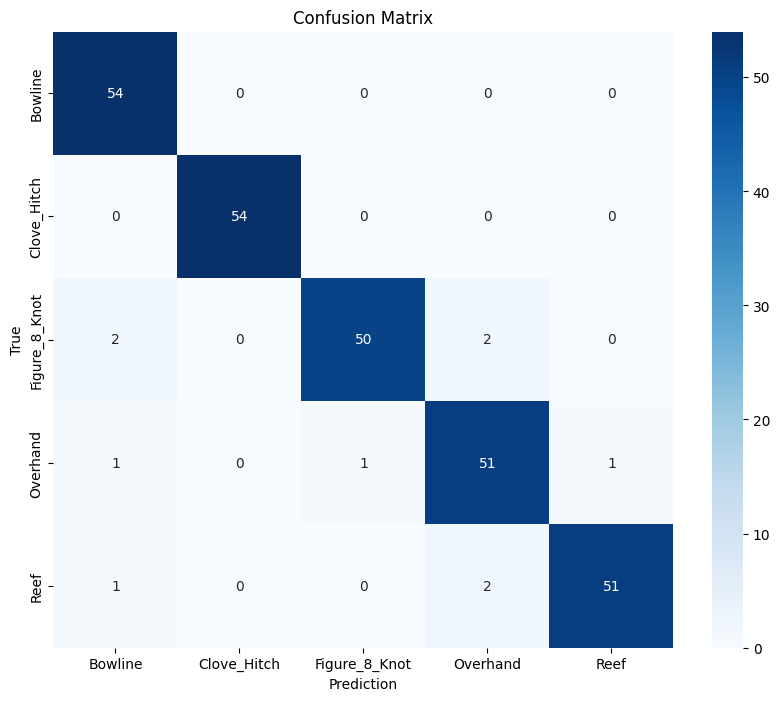

In [ ]:
# Define knot types
knot_types = ['Bowline', 'Clove_Hitch', 'Figure_8_Knot', 'Overhand', 'Reef']

# Plot confusion matrix
confusion_mtx = confusion_matrix(best_labels, best_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=knot_types, yticklabels=knot_types)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

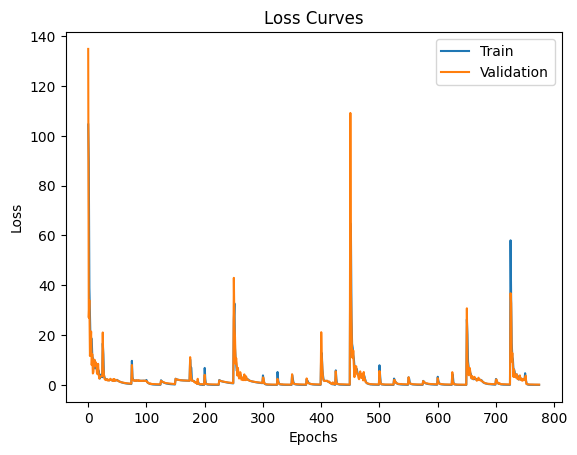

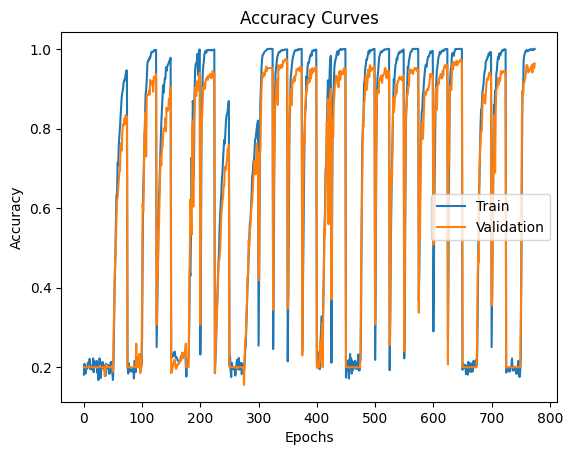

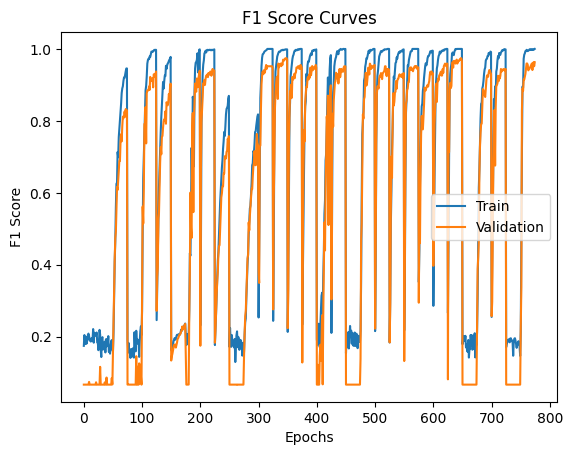

In [ ]:
# Plot loss curves
plt.figure()
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy curves
plt.figure()
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot F1 Score curves
plt.figure()
plt.plot(train_f1_scores, label='Train')
plt.plot(val_f1_scores, label='Validation')
plt.title('F1 Score Curves')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Runing on GPU
CUDA device count:  1


Epoch 0/24
----------
train Loss: 4.17480  Acc: 0.26914   F1_Score: 0.25608
val Loss: 1.24571  Acc: 0.46667   F1_Score: 0.44037

Epoch 1/24
----------
train Loss: 1.01779  Acc: 0.61728   F1_Score: 0.61120
val Loss: 0.73686  Acc: 0.77037   F1_Score: 0.77414

Epoch 2/24
----------
train Loss: 0.59759  Acc: 0.82963   F1_Score: 0.83014
val Loss: 0.59094  Acc: 0.77778   F1_Score: 0.76972

Epoch 3/24
----------
train Loss: 0.42343  Acc: 0.87778   F1_Score: 0.87845
val Loss: 0.59573  Acc: 0.74815   F1_Score: 0.74245

Epoch 4/24
----------
train Loss: 0.49110  Acc: 0.82346   F1_Score: 0.82277
val Loss: 0.24435  Acc: 0.93333   F1_Score: 0.93350

Epoch 5/24
----------
train Loss: 0.19705  Acc: 0.94568   F1_Score: 0.94556
val Loss: 0.16355  Acc: 0.97778   F1_Score: 0.97760

Epoch 6/24
----------
train Loss: 0.11705  Acc: 0.97284   F1_Score: 0.97283
val Loss: 0.12820  Acc: 0.96667   F1_Score: 0.96653

Epoch 7/24
----------
train Loss: 0.08644  Acc: 0.97778   F1_Score: 0.97779
val Loss: 0.16096  Ac

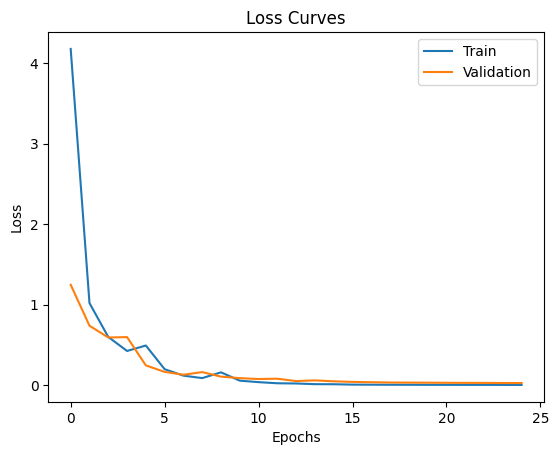

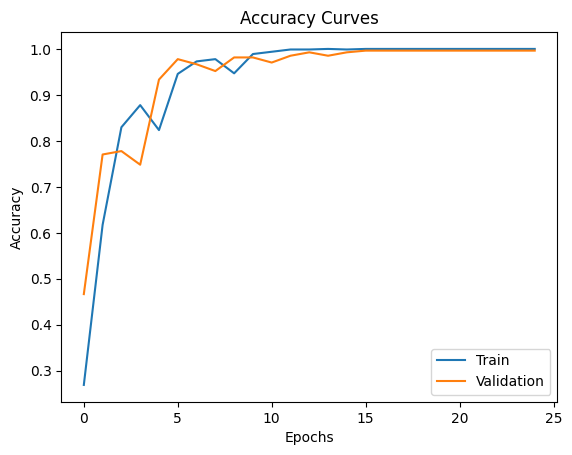

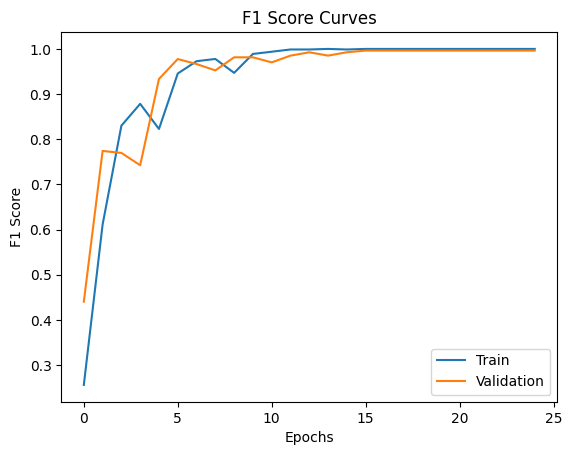

In [2]:
# Use ViT(vit_large_patch16_224) draw the curves with best hyperparameters

import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import time
import copy
from torch.utils.data import Dataset
from torchvision.io import read_image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import random
import timm
import optuna

# Connect to the google conlab
drive.mount('/content/drive')

# Use transforms to do data augmentation and preprocess
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(45),  # Rotate randomly between 0 and 45 degrees
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and scale to 224x224 size
    transforms.Grayscale(num_output_channels=3),  # Grayscale
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalization
])

class Knots_Dataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.data = []
        self.labels = []
        self.label_encoder = LabelEncoder()

        # Loop over all conditions
        for knot_type in os.listdir(img_dir):
            for light_condition in os.listdir(os.path.join(img_dir, knot_type)):
                for tension_condition in os.listdir(os.path.join(img_dir, knot_type, light_condition)):
                    images = os.listdir(os.path.join(img_dir, knot_type, light_condition, tension_condition))
                    random.shuffle(images)  # Shuffle the images
                    for image in images:
                        self.data.append(os.path.join(img_dir, knot_type, light_condition, tension_condition, image))
                        self.labels.append(knot_type)

        # Fit the label encoder and transform the labels
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path)
        image = image.convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Create a custom data set
dataset = Knots_Dataset("/content/drive/My Drive/MSc Project/rawdata", transform=data_transforms)

# Split the dataset into training set and validation set
train_dataset = []
val_dataset = []
for i in range(len(dataset)):
    if i % 4 == 0:  # Put 25% of the images in the validation set
        val_dataset.append(dataset[i])
    else:  # Put the rest in the training set
        train_dataset.append(dataset[i])

# Create a Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Check if model can be trained on GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Runing on GPU")
    print("CUDA device count: ", torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print("Runing on CPU")

# Save the model results
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []


def train_model(model, criterion, optimizer, num_epochs=25, accumulation_steps=4):   # Gradient Accumulation to slove the insufficient GPU memory
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_preds = None
    best_labels = None

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_preds = []
            running_labels = []

            # Iterate over data
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs, labels = inputs.to(device), labels.to(device)

                # zero(clean) the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        if (i+1) % accumulation_steps == 0:  # Only update every 'accumulation_steps' steps
                          optimizer.step()
                          optimizer.zero_grad()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_preds.extend(preds.cpu().numpy())
                running_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_acc = epoch_acc.cpu().numpy()  # Move tensor to CPU and convert to numpy(debug)
            epoch_f1_score = f1_score(running_labels, running_preds, average='macro')
            epoch_f1_score = torch.tensor(epoch_f1_score).cpu().numpy()  # Move tensor to CPU and convert to numpy(debug)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                train_f1_scores.append(epoch_f1_score)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                val_f1_scores.append(epoch_f1_score)

            print('{} Loss: {:.5f}  Acc: {:.5f}   F1_Score: {:.5f}'.format(
                phase, epoch_loss, epoch_acc, epoch_f1_score))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_preds = running_preds
                best_labels = running_labels

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:5f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, best_preds, best_labels

# [I 2023-07-21 23:28:59,516] Trial 13 finished with value: 0.9888888888888889
# and parameters: {'lr': 1.0861269711580703e-05, 'optimizer': 'RMSprop', 'weight_decay': 0.000597628202891095}. Best is trial 13 with value: 0.9888888888888889.
# [I 2023-07-22 13:01:19,492] Trial 13 finished with value: 0.9740740740740741
# and parameters: {'lr': 0.002627175153271954, 'optimizer': 'SGD', 'weight_decay': 1.3534122650251788e-08}. Best is trial 13 with value: 0.9740740740740741.

# Use the best hyperparameters to train the model
best_lr = 1.0861269711580703e-05
best_optimizer_name = 'RMSprop'
best_weight_decay = 0.000597628202891095

# Load a pretrained model(EfficientNet)
model = timm.create_model('vit_large_patch16_224', pretrained=True)
num_ftrs = model.head.in_features
model.head = nn.Linear(num_ftrs, 5)  # Change the head layer to 5
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Use the best optimizer
if best_optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
else:
    optimizer = optim.RMSprop(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)

# Train and evaluate the best model
model, best_preds, best_labels = train_model(model, criterion, optimizer, num_epochs=25)

# Plot loss curves
plt.figure()
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy curves
plt.figure()
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot F1 Score curves
plt.figure()
plt.plot(train_f1_scores, label='Train')
plt.plot(val_f1_scores, label='Validation')
plt.title('F1 Score Curves')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [ ]:
# This part build a EfficientNet model without/with tuning

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Runing on GPU
CUDA device count:  1


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.60529  Acc: 0.25432   F1_Score: 0.24039
val Loss: 1.56981  Acc: 0.36667   F1_Score: 0.34498

Epoch 1/24
----------
train Loss: 1.49511  Acc: 0.48519   F1_Score: 0.46342
val Loss: 1.49464  Acc: 0.53333   F1_Score: 0.51327

Epoch 2/24
----------
train Loss: 1.36122  Acc: 0.62716   F1_Score: 0.61199
val Loss: 1.38542  Acc: 0.54074   F1_Score: 0.52137

Epoch 3/24
----------
train Loss: 1.22274  Acc: 0.69753   F1_Score: 0.68524
val Loss: 1.28023  Acc: 0.63333   F1_Score: 0.61576

Epoch 4/24
----------
train Loss: 1.06264  Acc: 0.76173   F1_Score: 0.75426
val Loss: 1.14919  Acc: 0.65556   F1_Score: 0.63608

Epoch 5/24
----------
train Loss: 0.91342  Acc: 0.82593   F1_Score: 0.82363
val Loss: 1.03396  Acc: 0.71852   F1_Score: 0.70822

Epoch 6/24
----------
train Loss: 0.78698  Acc: 0.85926   F1_Score: 0.85791
val Loss: 0.92406  Acc: 0.76667   F1_Score: 0.76135

Epoch 7/24
----------
train Loss: 0.67003  Acc: 0.89136   F1_Score: 0.88977
val Loss: 0.84857  Ac

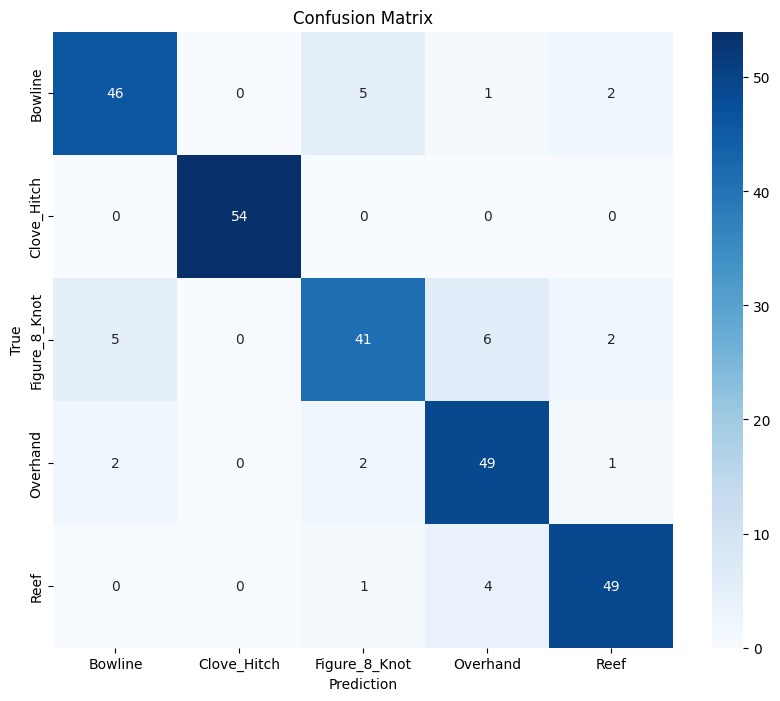

In [ ]:
# Use EfficientNet(tf_efficientnet_b5_ns) without tuning
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import time
import copy
from torch.utils.data import Dataset
from torchvision.io import read_image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import random
import timm





# Connect to the google conlab
drive.mount('/content/drive')


# Use transforms to do data augmentation and preprocess
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(45),  # Rotate randomly between 0 and 45 degrees
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and scale to 224x224 size
    transforms.Grayscale(num_output_channels=3),  # Grayscale
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalization
])





class Knots_Dataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.data = []
        self.labels = []
        self.label_encoder = LabelEncoder()

        # Loop over all conditions
        for knot_type in os.listdir(img_dir):
            for light_condition in os.listdir(os.path.join(img_dir, knot_type)):
                for tension_condition in os.listdir(os.path.join(img_dir, knot_type, light_condition)):
                    images = os.listdir(os.path.join(img_dir, knot_type, light_condition, tension_condition))
                    random.shuffle(images)  # Shuffle the images
                    for image in images:
                        self.data.append(os.path.join(img_dir, knot_type, light_condition, tension_condition, image))
                        self.labels.append(knot_type)

        # Fit the label encoder and transform the labels
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path)
        image = image.convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


# Create a custom data set
dataset = Knots_Dataset("/content/drive/My Drive/MSc Project/rawdata", transform=data_transforms)

# Split the dataset into training set and validation set
train_dataset = []
val_dataset = []
for i in range(len(dataset)):
    if i % 4 == 0:  # Put 25% of the images in the validation set
        val_dataset.append(dataset[i])
    else:  # Put the rest in the training set
        train_dataset.append(dataset[i])

# Create a Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}



# Check if model can be trained on GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Runing on GPU")
    print("CUDA device count: ", torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print("Runing on CPU")


# Save the model results
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []



def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0



    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_preds = []
            running_labels = []

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)


                # zero(clean) the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_preds.extend(preds.cpu().numpy())
                running_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_acc = epoch_acc.cpu().numpy()  # Move tensor to CPU and convert to numpy(debug)
            epoch_f1_score = f1_score(running_labels, running_preds, average='macro')
            epoch_f1_score = torch.tensor(epoch_f1_score).cpu().numpy()  # Move tensor to CPU and convert to numpy(debug)



            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                train_f1_scores.append(epoch_f1_score)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                val_f1_scores.append(epoch_f1_score)

            print('{} Loss: {:.5f}  Acc: {:.5f}   F1_Score: {:.5f}'.format(
                phase, epoch_loss, epoch_acc, epoch_f1_score))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:5f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)


    # Define knot types
    knot_types = ['Bowline', 'Clove_Hitch', 'Figure_8_Knot', 'Overhand', 'Reef']

    # Plot confusion matrix
    confusion_mtx = confusion_matrix(running_labels, running_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=knot_types, yticklabels=knot_types)
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


    return model


# Load a pretrained model(EfficientNet)
model = timm.create_model('tf_efficientnet_b5_ns', pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 5)  # Change the classifier layer to 5
model = model.to(device)


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train and evaluate
model = train_model(model, criterion, optimizer, num_epochs=25)



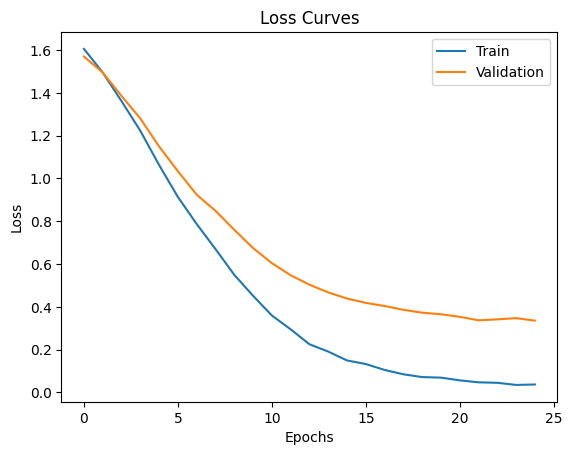

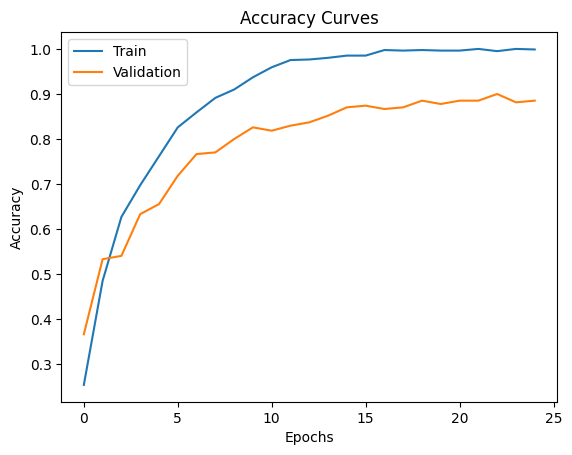

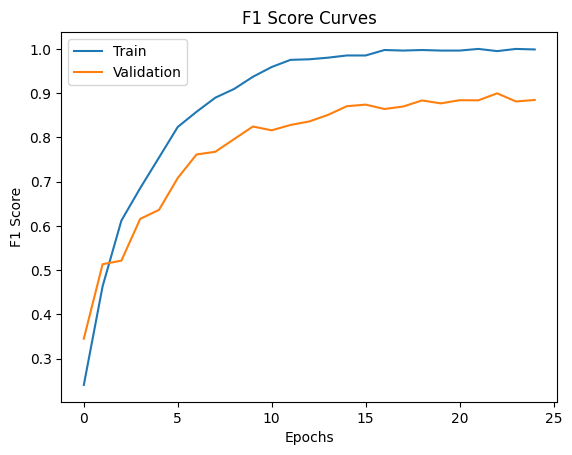

In [ ]:
# Plot loss curves
plt.figure()
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy curves
plt.figure()
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot F1 Score curves
plt.figure()
plt.plot(train_f1_scores, label='Train')
plt.plot(val_f1_scores, label='Validation')
plt.title('F1 Score Curves')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [ ]:
# Use EfficientNet(tf_efficientnet_b5_ns) with tuning
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import time
import copy
from torch.utils.data import Dataset
from torchvision.io import read_image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import random
import timm
import optuna

# Connect to the google conlab
drive.mount('/content/drive')

# Use transforms to do data augmentation and preprocess
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(45),  # Rotate randomly between 0 and 45 degrees
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and scale to 224x224 size
    transforms.Grayscale(num_output_channels=3),  # Grayscale
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalization
])

class Knots_Dataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.data = []
        self.labels = []
        self.label_encoder = LabelEncoder()

        # Loop over all conditions
        for knot_type in os.listdir(img_dir):
            for light_condition in os.listdir(os.path.join(img_dir, knot_type)):
                for tension_condition in os.listdir(os.path.join(img_dir, knot_type, light_condition)):
                    images = os.listdir(os.path.join(img_dir, knot_type, light_condition, tension_condition))
                    random.shuffle(images)  # Shuffle the images
                    for image in images:
                        self.data.append(os.path.join(img_dir, knot_type, light_condition, tension_condition, image))
                        self.labels.append(knot_type)

        # Fit the label encoder and transform the labels
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path)
        image = image.convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Create a custom data set
dataset = Knots_Dataset("/content/drive/My Drive/MSc Project/rawdata", transform=data_transforms)

# Split the dataset into training set and validation set
train_dataset = []
val_dataset = []
for i in range(len(dataset)):
    if i % 4 == 0:  # Put 25% of the images in the validation set
        val_dataset.append(dataset[i])
    else:  # Put the rest in the training set
        train_dataset.append(dataset[i])

# Create a Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Check if model can be trained on GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Runing on GPU")
    print("CUDA device count: ", torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print("Runing on CPU")

# Save the model results
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []

def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_preds = None
    best_labels = None

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_preds = []
            running_labels = []

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero(clean) the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_preds.extend(preds.cpu().numpy())
                running_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_acc = epoch_acc.cpu().numpy()  # Move tensor to CPU and convert to numpy(debug)
            epoch_f1_score = f1_score(running_labels, running_preds, average='macro')
            epoch_f1_score = torch.tensor(epoch_f1_score).cpu().numpy()  # Move tensor to CPU and convert to numpy(debug)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                train_f1_scores.append(epoch_f1_score)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                val_f1_scores.append(epoch_f1_score)

            print('{} Loss: {:.5f}  Acc: {:.5f}   F1_Score: {:.5f}'.format(
                phase, epoch_loss, epoch_acc, epoch_f1_score))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_preds = running_preds
                best_labels = running_labels

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:5f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, best_preds, best_labels

# Hyperparameter tune with Optuna
def objective(trial):
    # Suggest values for the hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    optimizer_name = trial.suggest_categorical('optimizer', ['SGD', 'Adam', 'RMSprop'])
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)

    # Load a pretrained model(EfficientNet)
    model = timm.create_model('tf_efficientnet_b5_ns', pretrained=True)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, 5)  # Change the classifier layer to 5
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    # Use the suggested optimizer
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Train and evaluate the model
    model, best_preds, best_labels = train_model(model, criterion, optimizer, num_epochs=25)

    # Return the best validation accuracy
    return max(val_accuracies)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the result
best_trial = study.best_trial
# [I 2023-07-17 23:56:05,319] Trial 76 finished with value: 0.9814814814814815
# and parameters: {'lr': 0.00015697122494777685, 'optimizer': 'Adam', 'weight_decay': 1.380942093496389e-07}. Best is trial 76 with value: 0.9814814814814815.
# [I 2023-07-18 19:35:10,874] Trial 49 finished with value: 0.9851851851851853
# and parameters: {'lr': 0.00021305939437836783, 'optimizer': 'RMSprop', 'weight_decay': 2.0510689201040282e-10}. Best is trial 49 with value: 0.9851851851851853.
print('Best Trial Value: ', best_trial.value)
print('Best Trial Params: ', best_trial.params)

# Use the best hyperparameters to train the model
best_lr = best_trial.params['lr']
best_optimizer_name = best_trial.params['optimizer']
best_weight_decay = best_trial.params['weight_decay']

# Load a pretrained model(EfficientNet)
model = timm.create_model('tf_efficientnet_b5_ns', pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 5)  # Change the classifier layer to 5
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Use the best optimizer
if best_optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
elif best_optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
else:
    optimizer = optim.RMSprop(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)

# Train and evaluate the best model
model, best_preds, best_labels = train_model(model, criterion, optimizer, num_epochs=25)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[I 2023-07-18 17:35:53,598] A new study created in memory with name: no-name-73e22793-6f7a-4ff7-aa87-d4e77c7c358f


Runing on GPU
CUDA device count:  1


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.42184  Acc: 0.53580   F1_Score: 0.51862
val Loss: 1.30802  Acc: 0.66296   F1_Score: 0.65873

Epoch 1/24
----------
train Loss: 0.98503  Acc: 0.85556   F1_Score: 0.85275
val Loss: 1.02030  Acc: 0.78148   F1_Score: 0.77739

Epoch 2/24
----------
train Loss: 0.73117  Acc: 0.92716   F1_Score: 0.92722
val Loss: 0.78404  Acc: 0.84074   F1_Score: 0.84020

Epoch 3/24
----------
train Loss: 0.52424  Acc: 0.95679   F1_Score: 0.95679
val Loss: 0.64968  Acc: 0.87778   F1_Score: 0.87704

Epoch 4/24
----------
train Loss: 0.36627  Acc: 0.97531   F1_Score: 0.97531
val Loss: 0.53240  Acc: 0.88889   F1_Score: 0.88702

Epoch 5/24
----------
train Loss: 0.24757  Acc: 0.98889   F1_Score: 0.98890
val Loss: 0.45906  Acc: 0.89630   F1_Score: 0.89569

Epoch 6/24
----------
train Loss: 0.16493  Acc: 0.99383   F1_Score: 0.99383
val Loss: 0.40746  Acc: 0.90370   F1_Score: 0.90282

Epoch 7/24
----------
train Loss: 0.12115  Acc: 0.99383   F1_Score: 0.99382
val Loss: 0.36116  Ac

[I 2023-07-18 17:38:33,635] Trial 0 finished with value: 0.9296296296296297 and parameters: {'lr': 1.4111583638902528e-05, 'optimizer': 'RMSprop', 'weight_decay': 1.0976616013797271e-08}. Best is trial 0 with value: 0.9296296296296297.


val Loss: 0.22106  Acc: 0.92593   F1_Score: 0.92485

Training complete in 2m 31s
Best val Acc: 0.929630


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.22812  Acc: 0.63086   F1_Score: 0.62484
val Loss: 0.97257  Acc: 0.84074   F1_Score: 0.83988

Epoch 1/24
----------
train Loss: 0.51574  Acc: 0.95679   F1_Score: 0.95671
val Loss: 0.57041  Acc: 0.87037   F1_Score: 0.87053

Epoch 2/24
----------
train Loss: 0.22383  Acc: 0.97778   F1_Score: 0.97770
val Loss: 0.36586  Acc: 0.92222   F1_Score: 0.92189

Epoch 3/24
----------
train Loss: 0.10109  Acc: 0.99506   F1_Score: 0.99506
val Loss: 0.29155  Acc: 0.92222   F1_Score: 0.92131

Epoch 4/24
----------
train Loss: 0.06063  Acc: 0.99753   F1_Score: 0.99753
val Loss: 0.27701  Acc: 0.91481   F1_Score: 0.91397

Epoch 5/24
----------
train Loss: 0.04600  Acc: 0.99877   F1_Score: 0.99877
val Loss: 0.25622  Acc: 0.92963   F1_Score: 0.92910

Epoch 6/24
----------
train Loss: 0.02072  Acc: 1.00000   F1_Score: 1.00000
val Loss: 0.22969  Acc: 0.93333   F1_Score: 0.93221

Epoch 7/24
----------
train Loss: 0.01657  Acc: 1.00000   F1_Score: 1.00000
val Loss: 0.23050  Ac

[I 2023-07-18 17:40:56,635] Trial 1 finished with value: 0.9592592592592593 and parameters: {'lr': 2.8718260437449566e-05, 'optimizer': 'RMSprop', 'weight_decay': 7.351805732303871e-09}. Best is trial 1 with value: 0.9592592592592593.


val Loss: 0.20172  Acc: 0.93333   F1_Score: 0.93376

Training complete in 2m 22s
Best val Acc: 0.959259


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.81781  Acc: 0.24074   F1_Score: 0.24028
val Loss: 1.78186  Acc: 0.20741   F1_Score: 0.13549

Epoch 1/24
----------
train Loss: 1.44618  Acc: 0.33827   F1_Score: 0.32428
val Loss: 1.56108  Acc: 0.22963   F1_Score: 0.12576

Epoch 2/24
----------
train Loss: 1.25884  Acc: 0.42099   F1_Score: 0.41149
val Loss: 1.58550  Acc: 0.27407   F1_Score: 0.21158

Epoch 3/24
----------
train Loss: 1.28635  Acc: 0.38889   F1_Score: 0.37921
val Loss: 1.63989  Acc: 0.30000   F1_Score: 0.21212

Epoch 4/24
----------
train Loss: 1.21037  Acc: 0.42716   F1_Score: 0.41846
val Loss: 1.79771  Acc: 0.35185   F1_Score: 0.24594

Epoch 5/24
----------
train Loss: 1.19569  Acc: 0.43580   F1_Score: 0.42327
val Loss: 1.40140  Acc: 0.39630   F1_Score: 0.32782

Epoch 6/24
----------
train Loss: 1.17075  Acc: 0.42963   F1_Score: 0.42483
val Loss: 1.80440  Acc: 0.37407   F1_Score: 0.24006

Epoch 7/24
----------
train Loss: 1.12379  Acc: 0.46914   F1_Score: 0.45971
val Loss: 1.87692  Ac

[I 2023-07-18 17:43:20,070] Trial 2 finished with value: 0.9592592592592593 and parameters: {'lr': 0.006832371434116082, 'optimizer': 'Adam', 'weight_decay': 0.0004688409690746446}. Best is trial 1 with value: 0.9592592592592593.


val Loss: 1.96664  Acc: 0.45556   F1_Score: 0.37386

Training complete in 2m 23s
Best val Acc: 0.592593


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.60984  Acc: 0.20000   F1_Score: 0.19145
val Loss: 1.61396  Acc: 0.22222   F1_Score: 0.21627

Epoch 1/24
----------
train Loss: 1.59906  Acc: 0.22469   F1_Score: 0.21287
val Loss: 1.60248  Acc: 0.22222   F1_Score: 0.22453

Epoch 2/24
----------
train Loss: 1.58621  Acc: 0.28272   F1_Score: 0.27628
val Loss: 1.61049  Acc: 0.20000   F1_Score: 0.19825

Epoch 3/24
----------
train Loss: 1.57978  Acc: 0.30741   F1_Score: 0.29681
val Loss: 1.59958  Acc: 0.23333   F1_Score: 0.23218

Epoch 4/24
----------
train Loss: 1.56932  Acc: 0.31235   F1_Score: 0.30271
val Loss: 1.59434  Acc: 0.27778   F1_Score: 0.27476

Epoch 5/24
----------
train Loss: 1.56588  Acc: 0.32716   F1_Score: 0.31944
val Loss: 1.58686  Acc: 0.27778   F1_Score: 0.27071

Epoch 6/24
----------
train Loss: 1.55761  Acc: 0.35802   F1_Score: 0.34971
val Loss: 1.57902  Acc: 0.31111   F1_Score: 0.30558

Epoch 7/24
----------
train Loss: 1.54387  Acc: 0.39506   F1_Score: 0.38774
val Loss: 1.57083  Ac

[I 2023-07-18 17:45:41,635] Trial 3 finished with value: 0.9592592592592593 and parameters: {'lr': 0.0007324813062492914, 'optimizer': 'SGD', 'weight_decay': 0.000135913329205013}. Best is trial 1 with value: 0.9592592592592593.


val Loss: 1.45255  Acc: 0.55185   F1_Score: 0.53205

Training complete in 2m 21s
Best val Acc: 0.551852


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 26.71116  Acc: 0.24321   F1_Score: 0.24310
val Loss: 39.10104  Acc: 0.18519   F1_Score: 0.09968

Epoch 1/24
----------
train Loss: 3.75491  Acc: 0.29259   F1_Score: 0.29588
val Loss: 2.79935  Acc: 0.22222   F1_Score: 0.14988

Epoch 2/24
----------
train Loss: 2.28925  Acc: 0.30988   F1_Score: 0.30578
val Loss: 2.92818  Acc: 0.28148   F1_Score: 0.18186

Epoch 3/24
----------
train Loss: 1.88144  Acc: 0.32593   F1_Score: 0.32153
val Loss: 2.36938  Acc: 0.22593   F1_Score: 0.12262

Epoch 4/24
----------
train Loss: 1.45989  Acc: 0.39630   F1_Score: 0.39299
val Loss: 1.69405  Acc: 0.28519   F1_Score: 0.25767

Epoch 5/24
----------
train Loss: 1.42754  Acc: 0.36667   F1_Score: 0.36701
val Loss: 4.72093  Acc: 0.22593   F1_Score: 0.11222

Epoch 6/24
----------
train Loss: 1.50547  Acc: 0.37901   F1_Score: 0.37130
val Loss: 1.68394  Acc: 0.41111   F1_Score: 0.30572

Epoch 7/24
----------
train Loss: 1.26512  Acc: 0.43827   F1_Score: 0.43490
val Loss: 1.65149  

[I 2023-07-18 17:48:03,590] Trial 4 finished with value: 0.9592592592592593 and parameters: {'lr': 0.021395648698693256, 'optimizer': 'RMSprop', 'weight_decay': 3.367106298196784e-10}. Best is trial 1 with value: 0.9592592592592593.


val Loss: 8.66044  Acc: 0.20741   F1_Score: 0.12009

Training complete in 2m 21s
Best val Acc: 0.470370


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 8.36549  Acc: 0.19383   F1_Score: 0.19402
val Loss: 283.40882  Acc: 0.19630   F1_Score: 0.06563

Epoch 1/24
----------
train Loss: 2.22518  Acc: 0.20864   F1_Score: 0.20501
val Loss: 10.77516  Acc: 0.20000   F1_Score: 0.06667

Epoch 2/24
----------
train Loss: 1.84171  Acc: 0.20123   F1_Score: 0.19728
val Loss: 3.81617  Acc: 0.20000   F1_Score: 0.06667

Epoch 3/24
----------
train Loss: 1.74420  Acc: 0.22840   F1_Score: 0.22295
val Loss: 3.78885  Acc: 0.20000   F1_Score: 0.06667

Epoch 4/24
----------
train Loss: 1.72044  Acc: 0.20864   F1_Score: 0.20375
val Loss: 2.19561  Acc: 0.20000   F1_Score: 0.06667

Epoch 5/24
----------
train Loss: 1.72012  Acc: 0.18889   F1_Score: 0.18739
val Loss: 3.59034  Acc: 0.20000   F1_Score: 0.06667

Epoch 6/24
----------
train Loss: 1.67067  Acc: 0.23704   F1_Score: 0.23445
val Loss: 3.13260  Acc: 0.20000   F1_Score: 0.06667

Epoch 7/24
----------
train Loss: 1.66267  Acc: 0.21852   F1_Score: 0.21476
val Loss: 5.20046 

[I 2023-07-18 17:50:26,063] Trial 5 finished with value: 0.9592592592592593 and parameters: {'lr': 0.08098801970848868, 'optimizer': 'Adam', 'weight_decay': 0.0004435028129372865}. Best is trial 1 with value: 0.9592592592592593.


val Loss: 1.65881  Acc: 0.20000   F1_Score: 0.06667

Training complete in 2m 21s
Best val Acc: 0.200000


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 0.80563  Acc: 0.69753   F1_Score: 0.69574
val Loss: 0.56160  Acc: 0.81481   F1_Score: 0.81614

Epoch 1/24
----------
train Loss: 0.17050  Acc: 0.94568   F1_Score: 0.94574
val Loss: 0.40846  Acc: 0.87778   F1_Score: 0.87817

Epoch 2/24
----------
train Loss: 0.08678  Acc: 0.97778   F1_Score: 0.97781
val Loss: 0.24904  Acc: 0.93704   F1_Score: 0.93555

Epoch 3/24
----------
train Loss: 0.04397  Acc: 0.99012   F1_Score: 0.99010
val Loss: 0.15704  Acc: 0.94815   F1_Score: 0.94743

Epoch 4/24
----------
train Loss: 0.02027  Acc: 0.99383   F1_Score: 0.99383
val Loss: 0.20746  Acc: 0.93704   F1_Score: 0.93556

Epoch 5/24
----------
train Loss: 0.02001  Acc: 0.99506   F1_Score: 0.99506
val Loss: 0.14163  Acc: 0.94815   F1_Score: 0.94770

Epoch 6/24
----------
train Loss: 0.01528  Acc: 0.99506   F1_Score: 0.99505
val Loss: 0.14529  Acc: 0.95556   F1_Score: 0.95526

Epoch 7/24
----------
train Loss: 0.01126  Acc: 0.99753   F1_Score: 0.99753
val Loss: 0.33572  Ac

[I 2023-07-18 17:52:47,985] Trial 6 finished with value: 0.962962962962963 and parameters: {'lr': 0.00016521919279004405, 'optimizer': 'RMSprop', 'weight_decay': 2.7492380666052233e-09}. Best is trial 6 with value: 0.962962962962963.


val Loss: 0.15839  Acc: 0.95556   F1_Score: 0.95564

Training complete in 2m 21s
Best val Acc: 0.962963


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.60451  Acc: 0.20494   F1_Score: 0.20049
val Loss: 1.60524  Acc: 0.20370   F1_Score: 0.19853

Epoch 1/24
----------
train Loss: 1.58593  Acc: 0.27407   F1_Score: 0.27106
val Loss: 1.58894  Acc: 0.28148   F1_Score: 0.25931

Epoch 2/24
----------
train Loss: 1.55815  Acc: 0.34444   F1_Score: 0.33692
val Loss: 1.57113  Acc: 0.35556   F1_Score: 0.33683

Epoch 3/24
----------
train Loss: 1.52687  Acc: 0.42716   F1_Score: 0.41259
val Loss: 1.55657  Acc: 0.38889   F1_Score: 0.37526

Epoch 4/24
----------
train Loss: 1.51217  Acc: 0.48025   F1_Score: 0.46260
val Loss: 1.53600  Acc: 0.43704   F1_Score: 0.41257

Epoch 5/24
----------
train Loss: 1.48588  Acc: 0.52346   F1_Score: 0.50734
val Loss: 1.52087  Acc: 0.44074   F1_Score: 0.40877

Epoch 6/24
----------
train Loss: 1.45888  Acc: 0.58025   F1_Score: 0.56475
val Loss: 1.50346  Acc: 0.50000   F1_Score: 0.47719

Epoch 7/24
----------
train Loss: 1.43781  Acc: 0.60494   F1_Score: 0.58435
val Loss: 1.47789  Ac

[I 2023-07-18 17:55:09,644] Trial 7 finished with value: 0.962962962962963 and parameters: {'lr': 0.0020001115643569533, 'optimizer': 'SGD', 'weight_decay': 3.5257173564858104e-08}. Best is trial 6 with value: 0.962962962962963.


val Loss: 1.07148  Acc: 0.73704   F1_Score: 0.73085

Training complete in 2m 21s
Best val Acc: 0.737037


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 4.67208  Acc: 0.20247   F1_Score: 0.20148
val Loss: 1.80548  Acc: 0.21481   F1_Score: 0.09597

Epoch 1/24
----------
train Loss: 1.67234  Acc: 0.16790   F1_Score: 0.16739
val Loss: 2.01702  Acc: 0.20000   F1_Score: 0.06667

Epoch 2/24
----------
train Loss: 1.65864  Acc: 0.20123   F1_Score: 0.19321
val Loss: 11.26819  Acc: 0.20000   F1_Score: 0.10352

Epoch 3/24
----------
train Loss: 1.61541  Acc: 0.23827   F1_Score: 0.22712
val Loss: 1.76549  Acc: 0.20370   F1_Score: 0.13780

Epoch 4/24
----------
train Loss: 1.39129  Acc: 0.34074   F1_Score: 0.33883
val Loss: 1.50141  Acc: 0.30741   F1_Score: 0.21182

Epoch 5/24
----------
train Loss: 1.30273  Acc: 0.37778   F1_Score: 0.37082
val Loss: 1.37017  Acc: 0.37407   F1_Score: 0.29660

Epoch 6/24
----------
train Loss: 1.31501  Acc: 0.37407   F1_Score: 0.37051
val Loss: 1.86431  Acc: 0.34074   F1_Score: 0.23186

Epoch 7/24
----------
train Loss: 1.22247  Acc: 0.43333   F1_Score: 0.43051
val Loss: 1.37362  A

[I 2023-07-18 17:57:31,650] Trial 8 finished with value: 0.962962962962963 and parameters: {'lr': 0.006190469357153377, 'optimizer': 'RMSprop', 'weight_decay': 4.699507712601607e-10}. Best is trial 6 with value: 0.962962962962963.


val Loss: 2.01651  Acc: 0.50000   F1_Score: 0.47107

Training complete in 2m 21s
Best val Acc: 0.537037


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.60010  Acc: 0.23580   F1_Score: 0.22524
val Loss: 1.59667  Acc: 0.24074   F1_Score: 0.24109

Epoch 1/24
----------
train Loss: 1.59953  Acc: 0.23580   F1_Score: 0.22198
val Loss: 1.59773  Acc: 0.24074   F1_Score: 0.22252

Epoch 2/24
----------
train Loss: 1.59444  Acc: 0.24198   F1_Score: 0.23014
val Loss: 1.60469  Acc: 0.22963   F1_Score: 0.21529

Epoch 3/24
----------
train Loss: 1.59407  Acc: 0.24198   F1_Score: 0.23685
val Loss: 1.60451  Acc: 0.20741   F1_Score: 0.19680

Epoch 4/24
----------
train Loss: 1.58972  Acc: 0.26049   F1_Score: 0.25445
val Loss: 1.60177  Acc: 0.21481   F1_Score: 0.20793

Epoch 5/24
----------
train Loss: 1.58199  Acc: 0.29012   F1_Score: 0.28591
val Loss: 1.59743  Acc: 0.24074   F1_Score: 0.23132

Epoch 6/24
----------
train Loss: 1.58239  Acc: 0.28272   F1_Score: 0.28384
val Loss: 1.59616  Acc: 0.24074   F1_Score: 0.23654

Epoch 7/24
----------
train Loss: 1.57625  Acc: 0.30864   F1_Score: 0.30569
val Loss: 1.59645  Ac

[I 2023-07-18 17:59:52,907] Trial 9 finished with value: 0.962962962962963 and parameters: {'lr': 0.00023437353557442293, 'optimizer': 'SGD', 'weight_decay': 4.82195724121114e-09}. Best is trial 6 with value: 0.962962962962963.


val Loss: 1.55914  Acc: 0.36296   F1_Score: 0.36538

Training complete in 2m 20s
Best val Acc: 0.362963


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 0.71338  Acc: 0.73086   F1_Score: 0.73151
val Loss: 0.41778  Acc: 0.83333   F1_Score: 0.82464

Epoch 1/24
----------
train Loss: 0.15909  Acc: 0.94074   F1_Score: 0.94083
val Loss: 0.60561  Acc: 0.80741   F1_Score: 0.80598

Epoch 2/24
----------
train Loss: 0.06965  Acc: 0.98025   F1_Score: 0.98025
val Loss: 0.23788  Acc: 0.92222   F1_Score: 0.92134

Epoch 3/24
----------
train Loss: 0.01154  Acc: 0.99877   F1_Score: 0.99877
val Loss: 0.22805  Acc: 0.93704   F1_Score: 0.93698

Epoch 4/24
----------
train Loss: 0.01420  Acc: 0.99630   F1_Score: 0.99630
val Loss: 0.27895  Acc: 0.91852   F1_Score: 0.91759

Epoch 5/24
----------
train Loss: 0.04778  Acc: 0.98889   F1_Score: 0.98888
val Loss: 0.55987  Acc: 0.81852   F1_Score: 0.81623

Epoch 6/24
----------
train Loss: 0.06976  Acc: 0.97901   F1_Score: 0.97901
val Loss: 0.22689  Acc: 0.92963   F1_Score: 0.92935

Epoch 7/24
----------
train Loss: 0.01523  Acc: 0.99753   F1_Score: 0.99753
val Loss: 0.19975  Ac

[I 2023-07-18 18:02:15,714] Trial 10 finished with value: 0.962962962962963 and parameters: {'lr': 0.0001549844942189156, 'optimizer': 'RMSprop', 'weight_decay': 1.1445533297180263e-06}. Best is trial 6 with value: 0.962962962962963.


val Loss: 0.20704  Acc: 0.94074   F1_Score: 0.94049

Training complete in 2m 22s
Best val Acc: 0.955556


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.61327  Acc: 0.21358   F1_Score: 0.20480
val Loss: 1.60592  Acc: 0.17778   F1_Score: 0.16382

Epoch 1/24
----------
train Loss: 1.59250  Acc: 0.25185   F1_Score: 0.24869
val Loss: 1.59250  Acc: 0.25185   F1_Score: 0.23861

Epoch 2/24
----------
train Loss: 1.56538  Acc: 0.34815   F1_Score: 0.34343
val Loss: 1.57919  Acc: 0.27778   F1_Score: 0.27312

Epoch 3/24
----------
train Loss: 1.54297  Acc: 0.39753   F1_Score: 0.39075
val Loss: 1.56547  Acc: 0.33333   F1_Score: 0.32594

Epoch 4/24
----------
train Loss: 1.52404  Acc: 0.44444   F1_Score: 0.43425
val Loss: 1.54853  Acc: 0.37778   F1_Score: 0.37068

Epoch 5/24
----------
train Loss: 1.50953  Acc: 0.49877   F1_Score: 0.49133
val Loss: 1.53028  Acc: 0.43333   F1_Score: 0.42306

Epoch 6/24
----------
train Loss: 1.48600  Acc: 0.52840   F1_Score: 0.51943
val Loss: 1.52415  Acc: 0.42222   F1_Score: 0.40814

Epoch 7/24
----------
train Loss: 1.46410  Acc: 0.57654   F1_Score: 0.56529
val Loss: 1.50710  Ac

[I 2023-07-18 18:04:37,562] Trial 11 finished with value: 0.962962962962963 and parameters: {'lr': 0.0017613061289784742, 'optimizer': 'SGD', 'weight_decay': 8.93871808562859e-08}. Best is trial 6 with value: 0.962962962962963.


val Loss: 1.13964  Acc: 0.69630   F1_Score: 0.68964

Training complete in 2m 21s
Best val Acc: 0.714815


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.60727  Acc: 0.23210   F1_Score: 0.22121
val Loss: 1.60188  Acc: 0.23704   F1_Score: 0.22969

Epoch 1/24
----------
train Loss: 1.60446  Acc: 0.25432   F1_Score: 0.24675
val Loss: 1.60144  Acc: 0.24074   F1_Score: 0.23072

Epoch 2/24
----------
train Loss: 1.60679  Acc: 0.24444   F1_Score: 0.22907
val Loss: 1.60911  Acc: 0.24074   F1_Score: 0.22603

Epoch 3/24
----------
train Loss: 1.60080  Acc: 0.24321   F1_Score: 0.23326
val Loss: 1.61071  Acc: 0.28148   F1_Score: 0.26341

Epoch 4/24
----------
train Loss: 1.60035  Acc: 0.23827   F1_Score: 0.22546
val Loss: 1.61075  Acc: 0.25185   F1_Score: 0.23293

Epoch 5/24
----------
train Loss: 1.60461  Acc: 0.23704   F1_Score: 0.22356
val Loss: 1.60842  Acc: 0.27037   F1_Score: 0.24886

Epoch 6/24
----------
train Loss: 1.60358  Acc: 0.25432   F1_Score: 0.24107
val Loss: 1.60699  Acc: 0.24444   F1_Score: 0.22507

Epoch 7/24
----------
train Loss: 1.59778  Acc: 0.25309   F1_Score: 0.23744
val Loss: 1.60509  Ac

[I 2023-07-18 18:06:58,961] Trial 12 finished with value: 0.962962962962963 and parameters: {'lr': 0.00010288530392830012, 'optimizer': 'SGD', 'weight_decay': 1.0351463825995796e-10}. Best is trial 6 with value: 0.962962962962963.


val Loss: 1.58431  Acc: 0.27037   F1_Score: 0.24579

Training complete in 2m 21s
Best val Acc: 0.300000


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.61028  Acc: 0.19877   F1_Score: 0.19446
val Loss: 1.60482  Acc: 0.18889   F1_Score: 0.19345

Epoch 1/24
----------
train Loss: 1.60258  Acc: 0.22840   F1_Score: 0.22772
val Loss: 1.60547  Acc: 0.22963   F1_Score: 0.23109

Epoch 2/24
----------
train Loss: 1.59384  Acc: 0.25556   F1_Score: 0.25390
val Loss: 1.59820  Acc: 0.21111   F1_Score: 0.20346

Epoch 3/24
----------
train Loss: 1.57892  Acc: 0.27407   F1_Score: 0.27615
val Loss: 1.58490  Acc: 0.25556   F1_Score: 0.25166

Epoch 4/24
----------
train Loss: 1.57266  Acc: 0.30864   F1_Score: 0.30917
val Loss: 1.58781  Acc: 0.24444   F1_Score: 0.23805

Epoch 5/24
----------
train Loss: 1.56387  Acc: 0.33457   F1_Score: 0.33323
val Loss: 1.57693  Acc: 0.28889   F1_Score: 0.28326

Epoch 6/24
----------
train Loss: 1.55748  Acc: 0.34568   F1_Score: 0.34598
val Loss: 1.57387  Acc: 0.27407   F1_Score: 0.26893

Epoch 7/24
----------
train Loss: 1.54934  Acc: 0.37531   F1_Score: 0.37402
val Loss: 1.56829  Ac

[I 2023-07-18 18:09:20,897] Trial 13 finished with value: 0.962962962962963 and parameters: {'lr': 0.0006913200855828051, 'optimizer': 'SGD', 'weight_decay': 3.1326207438164953e-07}. Best is trial 6 with value: 0.962962962962963.


val Loss: 1.46843  Acc: 0.52963   F1_Score: 0.51398

Training complete in 2m 21s
Best val Acc: 0.529630


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.48467  Acc: 0.49877   F1_Score: 0.49123
val Loss: 1.38508  Acc: 0.64444   F1_Score: 0.63811

Epoch 1/24
----------
train Loss: 0.95706  Acc: 0.88642   F1_Score: 0.88635
val Loss: 0.88193  Acc: 0.80741   F1_Score: 0.80424

Epoch 2/24
----------
train Loss: 0.43793  Acc: 0.95432   F1_Score: 0.95430
val Loss: 0.45498  Acc: 0.88889   F1_Score: 0.88790

Epoch 3/24
----------
train Loss: 0.15763  Acc: 0.98642   F1_Score: 0.98642
val Loss: 0.32677  Acc: 0.90370   F1_Score: 0.90320

Epoch 4/24
----------
train Loss: 0.06357  Acc: 0.99506   F1_Score: 0.99506
val Loss: 0.29332  Acc: 0.91481   F1_Score: 0.91471

Epoch 5/24
----------
train Loss: 0.03620  Acc: 0.99877   F1_Score: 0.99877
val Loss: 0.28348  Acc: 0.88889   F1_Score: 0.88818

Epoch 6/24
----------
train Loss: 0.03178  Acc: 0.99630   F1_Score: 0.99630
val Loss: 0.29417  Acc: 0.89630   F1_Score: 0.89556

Epoch 7/24
----------
train Loss: 0.01890  Acc: 0.99877   F1_Score: 0.99877
val Loss: 0.28085  Ac

[I 2023-07-18 18:11:44,631] Trial 14 finished with value: 0.962962962962963 and parameters: {'lr': 5.417195795246779e-05, 'optimizer': 'Adam', 'weight_decay': 5.922305419186869e-08}. Best is trial 6 with value: 0.962962962962963.


val Loss: 0.20466  Acc: 0.92963   F1_Score: 0.92993

Training complete in 2m 23s
Best val Acc: 0.937037


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.06012  Acc: 0.58148   F1_Score: 0.57955
val Loss: 0.65534  Acc: 0.78889   F1_Score: 0.79118

Epoch 1/24
----------
train Loss: 0.43540  Acc: 0.85185   F1_Score: 0.85241
val Loss: 0.39678  Acc: 0.83704   F1_Score: 0.83762

Epoch 2/24
----------
train Loss: 0.14560  Acc: 0.95062   F1_Score: 0.95050
val Loss: 0.52639  Acc: 0.86667   F1_Score: 0.86598

Epoch 3/24
----------
train Loss: 0.10401  Acc: 0.96914   F1_Score: 0.96922
val Loss: 0.34765  Acc: 0.90370   F1_Score: 0.90146

Epoch 4/24
----------
train Loss: 0.04106  Acc: 0.98889   F1_Score: 0.98889
val Loss: 0.28318  Acc: 0.90741   F1_Score: 0.90282

Epoch 5/24
----------
train Loss: 0.05756  Acc: 0.98395   F1_Score: 0.98396
val Loss: 1.86820  Acc: 0.60370   F1_Score: 0.58424

Epoch 6/24
----------
train Loss: 0.20988  Acc: 0.93210   F1_Score: 0.93203
val Loss: 0.31226  Acc: 0.90370   F1_Score: 0.90406

Epoch 7/24
----------
train Loss: 0.04187  Acc: 0.98765   F1_Score: 0.98769
val Loss: 0.92490  Ac

[I 2023-07-18 18:14:07,312] Trial 15 finished with value: 0.962962962962963 and parameters: {'lr': 0.0003131265713954633, 'optimizer': 'RMSprop', 'weight_decay': 2.674196824003326e-06}. Best is trial 6 with value: 0.962962962962963.


val Loss: 0.18023  Acc: 0.94444   F1_Score: 0.94497

Training complete in 2m 22s
Best val Acc: 0.951852


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.61149  Acc: 0.22222   F1_Score: 0.21007
val Loss: 1.60830  Acc: 0.18519   F1_Score: 0.16641

Epoch 1/24
----------
train Loss: 1.58926  Acc: 0.29753   F1_Score: 0.28995
val Loss: 1.58546  Acc: 0.27037   F1_Score: 0.26234

Epoch 2/24
----------
train Loss: 1.57342  Acc: 0.30247   F1_Score: 0.29414
val Loss: 1.57108  Acc: 0.31481   F1_Score: 0.31200

Epoch 3/24
----------
train Loss: 1.55048  Acc: 0.38889   F1_Score: 0.37834
val Loss: 1.55959  Acc: 0.36296   F1_Score: 0.36063

Epoch 4/24
----------
train Loss: 1.53470  Acc: 0.44691   F1_Score: 0.42993
val Loss: 1.55652  Acc: 0.36667   F1_Score: 0.35739

Epoch 5/24
----------
train Loss: 1.51833  Acc: 0.49630   F1_Score: 0.48376
val Loss: 1.53665  Acc: 0.43704   F1_Score: 0.42282

Epoch 6/24
----------
train Loss: 1.50445  Acc: 0.51481   F1_Score: 0.50294
val Loss: 1.52549  Acc: 0.50000   F1_Score: 0.48910

Epoch 7/24
----------
train Loss: 1.48158  Acc: 0.58889   F1_Score: 0.57986
val Loss: 1.50367  Ac

[I 2023-07-18 18:16:29,478] Trial 16 finished with value: 0.962962962962963 and parameters: {'lr': 0.0015280127538046652, 'optimizer': 'SGD', 'weight_decay': 1.9019606021264995e-09}. Best is trial 6 with value: 0.962962962962963.


val Loss: 1.22380  Acc: 0.72963   F1_Score: 0.72213

Training complete in 2m 21s
Best val Acc: 0.733333


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.48762  Acc: 0.51481   F1_Score: 0.50974
val Loss: 1.44765  Acc: 0.66296   F1_Score: 0.65980

Epoch 1/24
----------
train Loss: 1.18986  Acc: 0.81111   F1_Score: 0.80833
val Loss: 1.23827  Acc: 0.74444   F1_Score: 0.74056

Epoch 2/24
----------
train Loss: 0.95899  Acc: 0.89630   F1_Score: 0.89581
val Loss: 1.00497  Acc: 0.79630   F1_Score: 0.79492

Epoch 3/24
----------
train Loss: 0.78046  Acc: 0.91605   F1_Score: 0.91598
val Loss: 0.88068  Acc: 0.80370   F1_Score: 0.80363

Epoch 4/24
----------
train Loss: 0.62615  Acc: 0.95062   F1_Score: 0.95052
val Loss: 0.78019  Acc: 0.84444   F1_Score: 0.84424

Epoch 5/24
----------
train Loss: 0.48513  Acc: 0.94938   F1_Score: 0.94926
val Loss: 0.67339  Acc: 0.85556   F1_Score: 0.85509

Epoch 6/24
----------
train Loss: 0.37809  Acc: 0.97284   F1_Score: 0.97280
val Loss: 0.60106  Acc: 0.84815   F1_Score: 0.84754

Epoch 7/24
----------
train Loss: 0.30146  Acc: 0.97778   F1_Score: 0.97773
val Loss: 0.52744  Ac

[I 2023-07-18 18:18:52,586] Trial 17 finished with value: 0.962962962962963 and parameters: {'lr': 1.0988691344405047e-05, 'optimizer': 'RMSprop', 'weight_decay': 3.462066987479997e-08}. Best is trial 6 with value: 0.962962962962963.


val Loss: 0.25120  Acc: 0.91481   F1_Score: 0.91417

Training complete in 2m 22s
Best val Acc: 0.925926


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.60790  Acc: 0.22222   F1_Score: 0.21102
val Loss: 1.62375  Acc: 0.16667   F1_Score: 0.16046

Epoch 1/24
----------
train Loss: 1.61021  Acc: 0.21235   F1_Score: 0.19720
val Loss: 1.61401  Acc: 0.19259   F1_Score: 0.19625

Epoch 2/24
----------
train Loss: 1.61403  Acc: 0.21852   F1_Score: 0.20266
val Loss: 1.61848  Acc: 0.17778   F1_Score: 0.17334

Epoch 3/24
----------
train Loss: 1.61023  Acc: 0.21852   F1_Score: 0.20399
val Loss: 1.61653  Acc: 0.17037   F1_Score: 0.16579

Epoch 4/24
----------
train Loss: 1.61259  Acc: 0.21605   F1_Score: 0.20697
val Loss: 1.61503  Acc: 0.16667   F1_Score: 0.16567

Epoch 5/24
----------
train Loss: 1.61047  Acc: 0.21852   F1_Score: 0.20482
val Loss: 1.61319  Acc: 0.16667   F1_Score: 0.16482

Epoch 6/24
----------
train Loss: 1.60714  Acc: 0.21728   F1_Score: 0.20445
val Loss: 1.61468  Acc: 0.17037   F1_Score: 0.16355

Epoch 7/24
----------
train Loss: 1.60726  Acc: 0.21852   F1_Score: 0.20842
val Loss: 1.61412  Ac

[I 2023-07-18 18:21:13,702] Trial 18 finished with value: 0.962962962962963 and parameters: {'lr': 5.764189378488785e-05, 'optimizer': 'SGD', 'weight_decay': 1.1671537983917657e-09}. Best is trial 6 with value: 0.962962962962963.


val Loss: 1.60651  Acc: 0.20370   F1_Score: 0.20364

Training complete in 2m 20s
Best val Acc: 0.229630


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 0.79531  Acc: 0.69877   F1_Score: 0.69700
val Loss: 0.29857  Acc: 0.90370   F1_Score: 0.90199

Epoch 1/24
----------
train Loss: 0.22496  Acc: 0.91852   F1_Score: 0.91822
val Loss: 0.39972  Acc: 0.86296   F1_Score: 0.86256

Epoch 2/24
----------
train Loss: 0.08946  Acc: 0.96543   F1_Score: 0.96543
val Loss: 0.23590  Acc: 0.92222   F1_Score: 0.92143

Epoch 3/24
----------
train Loss: 0.13321  Acc: 0.95679   F1_Score: 0.95683
val Loss: 0.32897  Acc: 0.89630   F1_Score: 0.89563

Epoch 4/24
----------
train Loss: 0.09544  Acc: 0.97284   F1_Score: 0.97285
val Loss: 0.34872  Acc: 0.91111   F1_Score: 0.90603

Epoch 5/24
----------
train Loss: 0.05933  Acc: 0.98148   F1_Score: 0.98148
val Loss: 0.28631  Acc: 0.94444   F1_Score: 0.94320

Epoch 6/24
----------
train Loss: 0.10245  Acc: 0.96914   F1_Score: 0.96913
val Loss: 0.13727  Acc: 0.96296   F1_Score: 0.96281

Epoch 7/24
----------
train Loss: 0.04858  Acc: 0.98642   F1_Score: 0.98646
val Loss: 0.16654  Ac

[I 2023-07-18 18:23:36,952] Trial 19 finished with value: 0.9666666666666667 and parameters: {'lr': 0.00038327296434061413, 'optimizer': 'Adam', 'weight_decay': 1.1431287519740368e-08}. Best is trial 19 with value: 0.9666666666666667.


val Loss: 0.18227  Acc: 0.94444   F1_Score: 0.94431

Training complete in 2m 22s
Best val Acc: 0.966667


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 0.81529  Acc: 0.74198   F1_Score: 0.73916
val Loss: 0.31718  Acc: 0.87407   F1_Score: 0.87520

Epoch 1/24
----------
train Loss: 0.18035  Acc: 0.95679   F1_Score: 0.95687
val Loss: 0.46981  Acc: 0.86667   F1_Score: 0.85922

Epoch 2/24
----------
train Loss: 0.12339  Acc: 0.96543   F1_Score: 0.96542
val Loss: 0.33897  Acc: 0.91111   F1_Score: 0.91116

Epoch 3/24
----------
train Loss: 0.10424  Acc: 0.96790   F1_Score: 0.96788
val Loss: 0.26788  Acc: 0.88889   F1_Score: 0.88980

Epoch 4/24
----------
train Loss: 0.09498  Acc: 0.96667   F1_Score: 0.96661
val Loss: 0.18111  Acc: 0.94074   F1_Score: 0.94097

Epoch 5/24
----------
train Loss: 0.02678  Acc: 0.99259   F1_Score: 0.99259
val Loss: 0.35312  Acc: 0.90370   F1_Score: 0.90259

Epoch 6/24
----------
train Loss: 0.06550  Acc: 0.98025   F1_Score: 0.98026
val Loss: 0.42962  Acc: 0.90370   F1_Score: 0.90199

Epoch 7/24
----------
train Loss: 0.05792  Acc: 0.98519   F1_Score: 0.98518
val Loss: 0.38494  Ac

[I 2023-07-18 18:26:00,609] Trial 20 finished with value: 0.9666666666666667 and parameters: {'lr': 0.000339903956278332, 'optimizer': 'Adam', 'weight_decay': 1.884367656339203e-09}. Best is trial 19 with value: 0.9666666666666667.



Training complete in 2m 23s
Best val Acc: 0.955556


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 0.83382  Acc: 0.69259   F1_Score: 0.68632
val Loss: 0.29388  Acc: 0.89259   F1_Score: 0.89337

Epoch 1/24
----------
train Loss: 0.15383  Acc: 0.95679   F1_Score: 0.95675
val Loss: 0.49045  Acc: 0.84444   F1_Score: 0.84599

Epoch 2/24
----------
train Loss: 0.11743  Acc: 0.96790   F1_Score: 0.96803
val Loss: 0.13374  Acc: 0.95926   F1_Score: 0.95895

Epoch 3/24
----------
train Loss: 0.04813  Acc: 0.98395   F1_Score: 0.98394
val Loss: 0.24394  Acc: 0.93704   F1_Score: 0.93617

Epoch 4/24
----------
train Loss: 0.08549  Acc: 0.97284   F1_Score: 0.97282
val Loss: 0.19151  Acc: 0.93333   F1_Score: 0.93221

Epoch 5/24
----------
train Loss: 0.09369  Acc: 0.96420   F1_Score: 0.96416
val Loss: 0.25443  Acc: 0.90741   F1_Score: 0.90761

Epoch 6/24
----------
train Loss: 0.05536  Acc: 0.98642   F1_Score: 0.98641
val Loss: 0.27466  Acc: 0.92593   F1_Score: 0.92607

Epoch 7/24
----------
train Loss: 0.03122  Acc: 0.99012   F1_Score: 0.99012
val Loss: 0.23085  Ac

[I 2023-07-18 18:28:23,606] Trial 21 finished with value: 0.9703703703703704 and parameters: {'lr': 0.00034879090036982945, 'optimizer': 'Adam', 'weight_decay': 3.376539733500035e-09}. Best is trial 21 with value: 0.9703703703703704.


val Loss: 0.16083  Acc: 0.94074   F1_Score: 0.93943

Training complete in 2m 22s
Best val Acc: 0.970370


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 0.86340  Acc: 0.70370   F1_Score: 0.69959
val Loss: 0.32589  Acc: 0.90000   F1_Score: 0.89892

Epoch 1/24
----------
train Loss: 0.20597  Acc: 0.92716   F1_Score: 0.92740
val Loss: 0.32479  Acc: 0.88519   F1_Score: 0.88182

Epoch 2/24
----------
train Loss: 0.12006  Acc: 0.96173   F1_Score: 0.96179
val Loss: 0.15664  Acc: 0.95185   F1_Score: 0.95106

Epoch 3/24
----------
train Loss: 0.04985  Acc: 0.98642   F1_Score: 0.98643
val Loss: 0.34147  Acc: 0.90000   F1_Score: 0.89967

Epoch 4/24
----------
train Loss: 0.04100  Acc: 0.98519   F1_Score: 0.98518
val Loss: 0.22801  Acc: 0.92963   F1_Score: 0.92919

Epoch 5/24
----------
train Loss: 0.05926  Acc: 0.98395   F1_Score: 0.98400
val Loss: 0.21910  Acc: 0.92222   F1_Score: 0.92088

Epoch 6/24
----------
train Loss: 0.03391  Acc: 0.98889   F1_Score: 0.98889
val Loss: 0.27736  Acc: 0.93333   F1_Score: 0.93300

Epoch 7/24
----------
train Loss: 0.15547  Acc: 0.95926   F1_Score: 0.95924
val Loss: 0.25249  Ac

[I 2023-07-18 18:30:46,561] Trial 22 finished with value: 0.9703703703703704 and parameters: {'lr': 0.0003314813838248596, 'optimizer': 'Adam', 'weight_decay': 9.484664771221166e-10}. Best is trial 21 with value: 0.9703703703703704.


val Loss: 0.22081  Acc: 0.95926   F1_Score: 0.95928

Training complete in 2m 22s
Best val Acc: 0.959259


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 0.77516  Acc: 0.72716   F1_Score: 0.72445
val Loss: 0.49517  Acc: 0.85185   F1_Score: 0.85168

Epoch 1/24
----------
train Loss: 0.29160  Acc: 0.90494   F1_Score: 0.90503
val Loss: 0.28389  Acc: 0.91852   F1_Score: 0.91931

Epoch 2/24
----------
train Loss: 0.16316  Acc: 0.94444   F1_Score: 0.94448
val Loss: 0.28763  Acc: 0.91111   F1_Score: 0.90958

Epoch 3/24
----------
train Loss: 0.10172  Acc: 0.97160   F1_Score: 0.97166
val Loss: 0.26765  Acc: 0.90741   F1_Score: 0.90683

Epoch 4/24
----------
train Loss: 0.07079  Acc: 0.97407   F1_Score: 0.97403
val Loss: 0.24694  Acc: 0.91111   F1_Score: 0.91206

Epoch 5/24
----------
train Loss: 0.08287  Acc: 0.97654   F1_Score: 0.97652
val Loss: 0.19055  Acc: 0.94815   F1_Score: 0.94750

Epoch 6/24
----------
train Loss: 0.09880  Acc: 0.97284   F1_Score: 0.97294
val Loss: 0.32523  Acc: 0.92222   F1_Score: 0.91869

Epoch 7/24
----------
train Loss: 0.03379  Acc: 0.99136   F1_Score: 0.99136
val Loss: 0.37336  Ac

[I 2023-07-18 18:33:09,419] Trial 23 finished with value: 0.9703703703703704 and parameters: {'lr': 0.00045273072416340327, 'optimizer': 'Adam', 'weight_decay': 1.1696137346327045e-10}. Best is trial 21 with value: 0.9703703703703704.


val Loss: 0.18754  Acc: 0.94815   F1_Score: 0.94793

Training complete in 2m 22s
Best val Acc: 0.962963


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 0.75174  Acc: 0.72840   F1_Score: 0.72698
val Loss: 0.37693  Acc: 0.85926   F1_Score: 0.86198

Epoch 1/24
----------
train Loss: 0.28569  Acc: 0.89877   F1_Score: 0.89927
val Loss: 0.24987  Acc: 0.92593   F1_Score: 0.92506

Epoch 2/24
----------
train Loss: 0.18737  Acc: 0.93951   F1_Score: 0.93940
val Loss: 0.52154  Acc: 0.87778   F1_Score: 0.87548

Epoch 3/24
----------
train Loss: 0.13149  Acc: 0.95802   F1_Score: 0.95807
val Loss: 0.47031  Acc: 0.84815   F1_Score: 0.85230

Epoch 4/24
----------
train Loss: 0.23750  Acc: 0.93457   F1_Score: 0.93472
val Loss: 0.34834  Acc: 0.89630   F1_Score: 0.89553

Epoch 5/24
----------
train Loss: 0.12673  Acc: 0.96296   F1_Score: 0.96298
val Loss: 0.35517  Acc: 0.91111   F1_Score: 0.91039

Epoch 6/24
----------
train Loss: 0.15860  Acc: 0.95556   F1_Score: 0.95549
val Loss: 0.28521  Acc: 0.91481   F1_Score: 0.91521

Epoch 7/24
----------
train Loss: 0.09882  Acc: 0.96914   F1_Score: 0.96914
val Loss: 0.43401  Ac

[I 2023-07-18 18:35:31,787] Trial 24 finished with value: 0.9703703703703704 and parameters: {'lr': 0.0006232938217071919, 'optimizer': 'Adam', 'weight_decay': 1.0085007066322903e-10}. Best is trial 21 with value: 0.9703703703703704.


val Loss: 0.15801  Acc: 0.95926   F1_Score: 0.95910

Training complete in 2m 22s
Best val Acc: 0.959259


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.38722  Acc: 0.55679   F1_Score: 0.55188
val Loss: 1.11160  Acc: 0.70741   F1_Score: 0.70906

Epoch 1/24
----------
train Loss: 0.65254  Acc: 0.93210   F1_Score: 0.93219
val Loss: 0.55030  Acc: 0.88148   F1_Score: 0.88030

Epoch 2/24
----------
train Loss: 0.18241  Acc: 0.98272   F1_Score: 0.98271
val Loss: 0.25750  Acc: 0.92593   F1_Score: 0.92498

Epoch 3/24
----------
train Loss: 0.04572  Acc: 0.99877   F1_Score: 0.99877
val Loss: 0.23608  Acc: 0.92222   F1_Score: 0.92144

Epoch 4/24
----------
train Loss: 0.01824  Acc: 0.99877   F1_Score: 0.99877
val Loss: 0.20914  Acc: 0.94074   F1_Score: 0.94062

Epoch 5/24
----------
train Loss: 0.01686  Acc: 0.99877   F1_Score: 0.99877
val Loss: 0.21770  Acc: 0.92963   F1_Score: 0.92802

Epoch 6/24
----------
train Loss: 0.01508  Acc: 0.99753   F1_Score: 0.99753
val Loss: 0.18292  Acc: 0.94074   F1_Score: 0.94019

Epoch 7/24
----------
train Loss: 0.02740  Acc: 0.99136   F1_Score: 0.99138
val Loss: 0.19991  Ac

[I 2023-07-18 18:37:54,210] Trial 25 finished with value: 0.9703703703703704 and parameters: {'lr': 8.282509936849266e-05, 'optimizer': 'Adam', 'weight_decay': 3.9842083875011104e-10}. Best is trial 21 with value: 0.9703703703703704.


val Loss: 0.34227  Acc: 0.89630   F1_Score: 0.89563

Training complete in 2m 22s
Best val Acc: 0.944444


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.14757  Acc: 0.64568   F1_Score: 0.64605
val Loss: 0.62320  Acc: 0.84815   F1_Score: 0.83804

Epoch 1/24
----------
train Loss: 0.23657  Acc: 0.93827   F1_Score: 0.93817
val Loss: 0.28977  Acc: 0.90370   F1_Score: 0.89858

Epoch 2/24
----------
train Loss: 0.07525  Acc: 0.97531   F1_Score: 0.97530
val Loss: 0.15421  Acc: 0.95556   F1_Score: 0.95527

Epoch 3/24
----------
train Loss: 0.07306  Acc: 0.98148   F1_Score: 0.98148
val Loss: 0.19193  Acc: 0.94074   F1_Score: 0.94114

Epoch 4/24
----------
train Loss: 0.04008  Acc: 0.99630   F1_Score: 0.99630
val Loss: 0.12854  Acc: 0.97407   F1_Score: 0.97359

Epoch 5/24
----------
train Loss: 0.01349  Acc: 0.99877   F1_Score: 0.99877
val Loss: 0.12352  Acc: 0.96667   F1_Score: 0.96652

Epoch 6/24
----------
train Loss: 0.01281  Acc: 0.99630   F1_Score: 0.99630
val Loss: 0.14287  Acc: 0.95556   F1_Score: 0.95551

Epoch 7/24
----------
train Loss: 0.02618  Acc: 0.99259   F1_Score: 0.99260
val Loss: 0.21197  Ac

[I 2023-07-18 18:40:16,432] Trial 26 finished with value: 0.9740740740740741 and parameters: {'lr': 0.00015375715556545638, 'optimizer': 'Adam', 'weight_decay': 5.052862725306251e-10}. Best is trial 26 with value: 0.9740740740740741.


val Loss: 0.17986  Acc: 0.94444   F1_Score: 0.94487

Training complete in 2m 21s
Best val Acc: 0.974074


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.15462  Acc: 0.60988   F1_Score: 0.60710
val Loss: 0.58349  Acc: 0.85556   F1_Score: 0.85415

Epoch 1/24
----------
train Loss: 0.21296  Acc: 0.95556   F1_Score: 0.95549
val Loss: 0.28447  Acc: 0.89630   F1_Score: 0.89233

Epoch 2/24
----------
train Loss: 0.05215  Acc: 0.99012   F1_Score: 0.99013
val Loss: 0.24478  Acc: 0.92963   F1_Score: 0.92931

Epoch 3/24
----------
train Loss: 0.02874  Acc: 0.99506   F1_Score: 0.99506
val Loss: 0.24786  Acc: 0.91852   F1_Score: 0.91824

Epoch 4/24
----------
train Loss: 0.03423  Acc: 0.99259   F1_Score: 0.99259
val Loss: 0.16627  Acc: 0.93333   F1_Score: 0.93415

Epoch 5/24
----------
train Loss: 0.02562  Acc: 0.99012   F1_Score: 0.99014
val Loss: 0.16426  Acc: 0.94074   F1_Score: 0.94007

Epoch 6/24
----------
train Loss: 0.01633  Acc: 0.99630   F1_Score: 0.99629
val Loss: 0.25806  Acc: 0.91852   F1_Score: 0.91943

Epoch 7/24
----------
train Loss: 0.03552  Acc: 0.99259   F1_Score: 0.99258
val Loss: 0.23023  Ac

[I 2023-07-18 18:42:38,900] Trial 27 finished with value: 0.9740740740740741 and parameters: {'lr': 0.00016120775502290036, 'optimizer': 'Adam', 'weight_decay': 8.328790174890488e-10}. Best is trial 26 with value: 0.9740740740740741.


val Loss: 0.24808  Acc: 0.91481   F1_Score: 0.91462

Training complete in 2m 22s
Best val Acc: 0.959259


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.27114  Acc: 0.66049   F1_Score: 0.65679
val Loss: 0.86600  Acc: 0.78519   F1_Score: 0.78367

Epoch 1/24
----------
train Loss: 0.36142  Acc: 0.94568   F1_Score: 0.94532
val Loss: 0.35927  Acc: 0.87037   F1_Score: 0.86636

Epoch 2/24
----------
train Loss: 0.07237  Acc: 0.98272   F1_Score: 0.98273
val Loss: 0.28880  Acc: 0.90741   F1_Score: 0.90487

Epoch 3/24
----------
train Loss: 0.04180  Acc: 0.98889   F1_Score: 0.98889
val Loss: 0.22553  Acc: 0.90741   F1_Score: 0.90627

Epoch 4/24
----------
train Loss: 0.01752  Acc: 0.99877   F1_Score: 0.99877
val Loss: 0.18549  Acc: 0.93704   F1_Score: 0.93622

Epoch 5/24
----------
train Loss: 0.02133  Acc: 0.99383   F1_Score: 0.99383
val Loss: 0.25542  Acc: 0.91852   F1_Score: 0.91742

Epoch 6/24
----------
train Loss: 0.01542  Acc: 0.99630   F1_Score: 0.99630
val Loss: 0.22216  Acc: 0.91481   F1_Score: 0.91335

Epoch 7/24
----------
train Loss: 0.03026  Acc: 0.99012   F1_Score: 0.99015
val Loss: 0.32568  Ac

[I 2023-07-18 18:45:01,612] Trial 28 finished with value: 0.9740740740740741 and parameters: {'lr': 0.00011726724682222227, 'optimizer': 'Adam', 'weight_decay': 5.447466252075342e-10}. Best is trial 26 with value: 0.9740740740740741.


val Loss: 0.20555  Acc: 0.93333   F1_Score: 0.93438

Training complete in 2m 22s
Best val Acc: 0.962963


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.55726  Acc: 0.35185   F1_Score: 0.34334
val Loss: 1.53516  Acc: 0.41111   F1_Score: 0.39409

Epoch 1/24
----------
train Loss: 1.33098  Acc: 0.76296   F1_Score: 0.76078
val Loss: 1.36497  Acc: 0.64815   F1_Score: 0.63542

Epoch 2/24
----------
train Loss: 1.03545  Acc: 0.89136   F1_Score: 0.89099
val Loss: 1.05501  Acc: 0.77778   F1_Score: 0.77571

Epoch 3/24
----------
train Loss: 0.72479  Acc: 0.93333   F1_Score: 0.93317
val Loss: 0.82479  Acc: 0.83333   F1_Score: 0.83214

Epoch 4/24
----------
train Loss: 0.47122  Acc: 0.96543   F1_Score: 0.96541
val Loss: 0.62498  Acc: 0.85556   F1_Score: 0.85254

Epoch 5/24
----------
train Loss: 0.28376  Acc: 0.98519   F1_Score: 0.98518
val Loss: 0.49315  Acc: 0.88519   F1_Score: 0.88285

Epoch 6/24
----------
train Loss: 0.19568  Acc: 0.97407   F1_Score: 0.97403
val Loss: 0.41635  Acc: 0.88519   F1_Score: 0.88158

Epoch 7/24
----------
train Loss: 0.10806  Acc: 0.99753   F1_Score: 0.99753
val Loss: 0.34983  Ac

[I 2023-07-18 18:47:24,517] Trial 29 finished with value: 0.9740740740740741 and parameters: {'lr': 2.4671153149840765e-05, 'optimizer': 'Adam', 'weight_decay': 4.23976993413011e-10}. Best is trial 26 with value: 0.9740740740740741.


val Loss: 0.24135  Acc: 0.93333   F1_Score: 0.93265

Training complete in 2m 22s
Best val Acc: 0.933333


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.31387  Acc: 0.58519   F1_Score: 0.57937
val Loss: 0.92455  Acc: 0.75926   F1_Score: 0.75895

Epoch 1/24
----------
train Loss: 0.36841  Acc: 0.94198   F1_Score: 0.94201
val Loss: 0.33691  Acc: 0.88519   F1_Score: 0.88647

Epoch 2/24
----------
train Loss: 0.07711  Acc: 0.98148   F1_Score: 0.98145
val Loss: 0.25026  Acc: 0.92222   F1_Score: 0.92158

Epoch 3/24
----------
train Loss: 0.04615  Acc: 0.98765   F1_Score: 0.98755
val Loss: 0.21519  Acc: 0.92593   F1_Score: 0.92392

Epoch 4/24
----------
train Loss: 0.04909  Acc: 0.98272   F1_Score: 0.98275
val Loss: 0.26433  Acc: 0.91111   F1_Score: 0.91101

Epoch 5/24
----------
train Loss: 0.02816  Acc: 0.99383   F1_Score: 0.99382
val Loss: 0.30992  Acc: 0.90000   F1_Score: 0.89818

Epoch 6/24
----------
train Loss: 0.02488  Acc: 0.99259   F1_Score: 0.99259
val Loss: 0.17094  Acc: 0.94444   F1_Score: 0.94414

Epoch 7/24
----------
train Loss: 0.02782  Acc: 0.99506   F1_Score: 0.99506
val Loss: 0.24553  Ac

[I 2023-07-18 18:49:47,167] Trial 30 finished with value: 0.9740740740740741 and parameters: {'lr': 0.0001258929126816638, 'optimizer': 'Adam', 'weight_decay': 1.168837896017019e-08}. Best is trial 26 with value: 0.9740740740740741.


val Loss: 0.15935  Acc: 0.95556   F1_Score: 0.95530

Training complete in 2m 22s
Best val Acc: 0.974074


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.56139  Acc: 0.33457   F1_Score: 0.32748
val Loss: 1.53548  Acc: 0.41111   F1_Score: 0.41693

Epoch 1/24
----------
train Loss: 1.36887  Acc: 0.71235   F1_Score: 0.70565
val Loss: 1.40074  Acc: 0.64815   F1_Score: 0.63966

Epoch 2/24
----------
train Loss: 1.12758  Acc: 0.85309   F1_Score: 0.85014
val Loss: 1.13070  Acc: 0.74444   F1_Score: 0.73868

Epoch 3/24
----------
train Loss: 0.88329  Acc: 0.90247   F1_Score: 0.90187
val Loss: 0.96047  Acc: 0.79259   F1_Score: 0.78964

Epoch 4/24
----------
train Loss: 0.68172  Acc: 0.94938   F1_Score: 0.94919
val Loss: 0.81101  Acc: 0.83704   F1_Score: 0.83436

Epoch 5/24
----------
train Loss: 0.47933  Acc: 0.96543   F1_Score: 0.96537
val Loss: 0.64528  Acc: 0.87037   F1_Score: 0.87016

Epoch 6/24
----------
train Loss: 0.31741  Acc: 0.98272   F1_Score: 0.98276
val Loss: 0.52615  Acc: 0.88148   F1_Score: 0.88036

Epoch 7/24
----------
train Loss: 0.19805  Acc: 0.98889   F1_Score: 0.98891
val Loss: 0.41971  Ac

[I 2023-07-18 18:52:10,294] Trial 31 finished with value: 0.9740740740740741 and parameters: {'lr': 2.1671228327234445e-05, 'optimizer': 'Adam', 'weight_decay': 5.212464340429171e-10}. Best is trial 26 with value: 0.9740740740740741.


val Loss: 0.18792  Acc: 0.94074   F1_Score: 0.94080

Training complete in 2m 22s
Best val Acc: 0.948148


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.53591  Acc: 0.40617   F1_Score: 0.40828
val Loss: 1.49218  Acc: 0.48148   F1_Score: 0.48275

Epoch 1/24
----------
train Loss: 1.24966  Acc: 0.80988   F1_Score: 0.80849
val Loss: 1.27728  Acc: 0.69259   F1_Score: 0.69040

Epoch 2/24
----------
train Loss: 0.90319  Acc: 0.88889   F1_Score: 0.88899
val Loss: 0.90819  Acc: 0.78148   F1_Score: 0.77702

Epoch 3/24
----------
train Loss: 0.57739  Acc: 0.94815   F1_Score: 0.94837
val Loss: 0.67812  Acc: 0.82963   F1_Score: 0.82682

Epoch 4/24
----------
train Loss: 0.34237  Acc: 0.96667   F1_Score: 0.96668
val Loss: 0.49033  Acc: 0.89630   F1_Score: 0.89564

Epoch 5/24
----------
train Loss: 0.19063  Acc: 0.98889   F1_Score: 0.98888
val Loss: 0.38531  Acc: 0.90000   F1_Score: 0.90005

Epoch 6/24
----------
train Loss: 0.09879  Acc: 0.99259   F1_Score: 0.99259
val Loss: 0.33604  Acc: 0.91111   F1_Score: 0.91093

Epoch 7/24
----------
train Loss: 0.06948  Acc: 0.99383   F1_Score: 0.99382
val Loss: 0.29044  Ac

[I 2023-07-18 18:54:33,364] Trial 32 finished with value: 0.9740740740740741 and parameters: {'lr': 2.9541988039282373e-05, 'optimizer': 'Adam', 'weight_decay': 3.273996597423213e-10}. Best is trial 26 with value: 0.9740740740740741.


val Loss: 0.19278  Acc: 0.92593   F1_Score: 0.92631

Training complete in 2m 22s
Best val Acc: 0.933333


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.52085  Acc: 0.43210   F1_Score: 0.41121
val Loss: 1.47470  Acc: 0.56296   F1_Score: 0.56091

Epoch 1/24
----------
train Loss: 1.09517  Acc: 0.84198   F1_Score: 0.83981
val Loss: 1.08150  Acc: 0.74815   F1_Score: 0.74199

Epoch 2/24
----------
train Loss: 0.68212  Acc: 0.92593   F1_Score: 0.92552
val Loss: 0.70821  Acc: 0.82222   F1_Score: 0.82048

Epoch 3/24
----------
train Loss: 0.34971  Acc: 0.97037   F1_Score: 0.97035
val Loss: 0.46738  Acc: 0.87037   F1_Score: 0.86957

Epoch 4/24
----------
train Loss: 0.14284  Acc: 0.99012   F1_Score: 0.99011
val Loss: 0.35330  Acc: 0.89630   F1_Score: 0.89486

Epoch 5/24
----------
train Loss: 0.06279  Acc: 1.00000   F1_Score: 1.00000
val Loss: 0.29778  Acc: 0.90370   F1_Score: 0.90208

Epoch 6/24
----------
train Loss: 0.04362  Acc: 0.99753   F1_Score: 0.99753
val Loss: 0.26725  Acc: 0.91852   F1_Score: 0.91665

Epoch 7/24
----------
train Loss: 0.02230  Acc: 1.00000   F1_Score: 1.00000
val Loss: 0.25738  Ac

[I 2023-07-18 18:56:56,593] Trial 33 finished with value: 0.9740740740740741 and parameters: {'lr': 4.296231346142447e-05, 'optimizer': 'Adam', 'weight_decay': 1.0016060295767283e-09}. Best is trial 26 with value: 0.9740740740740741.


val Loss: 0.22937  Acc: 0.90370   F1_Score: 0.90434

Training complete in 2m 22s
Best val Acc: 0.944444


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.57315  Acc: 0.31852   F1_Score: 0.30730
val Loss: 1.55216  Acc: 0.37407   F1_Score: 0.37472

Epoch 1/24
----------
train Loss: 1.43627  Acc: 0.67531   F1_Score: 0.66641
val Loss: 1.47740  Acc: 0.55556   F1_Score: 0.55698

Epoch 2/24
----------
train Loss: 1.29695  Acc: 0.78395   F1_Score: 0.78004
val Loss: 1.32168  Acc: 0.71111   F1_Score: 0.70230

Epoch 3/24
----------
train Loss: 1.12139  Acc: 0.85802   F1_Score: 0.85511
val Loss: 1.16539  Acc: 0.75556   F1_Score: 0.75011

Epoch 4/24
----------
train Loss: 0.90112  Acc: 0.91852   F1_Score: 0.91834
val Loss: 0.99213  Acc: 0.80370   F1_Score: 0.80148

Epoch 5/24
----------
train Loss: 0.70534  Acc: 0.94321   F1_Score: 0.94302
val Loss: 0.85210  Acc: 0.84074   F1_Score: 0.83968

Epoch 6/24
----------
train Loss: 0.54622  Acc: 0.95926   F1_Score: 0.95921
val Loss: 0.71655  Acc: 0.85185   F1_Score: 0.85190

Epoch 7/24
----------
train Loss: 0.41959  Acc: 0.97778   F1_Score: 0.97775
val Loss: 0.59540  Ac

[I 2023-07-18 18:59:20,334] Trial 34 finished with value: 0.9740740740740741 and parameters: {'lr': 1.603211166267165e-05, 'optimizer': 'Adam', 'weight_decay': 4.889547271248805e-09}. Best is trial 26 with value: 0.9740740740740741.


val Loss: 0.20591  Acc: 0.93704   F1_Score: 0.93690

Training complete in 2m 23s
Best val Acc: 0.948148


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.53532  Acc: 0.40247   F1_Score: 0.39031
val Loss: 1.48858  Acc: 0.54074   F1_Score: 0.54144

Epoch 1/24
----------
train Loss: 1.22882  Acc: 0.81358   F1_Score: 0.81035
val Loss: 1.24334  Acc: 0.74815   F1_Score: 0.74471

Epoch 2/24
----------
train Loss: 0.82218  Acc: 0.93333   F1_Score: 0.93335
val Loss: 0.82789  Acc: 0.83704   F1_Score: 0.83392

Epoch 3/24
----------
train Loss: 0.44903  Acc: 0.97037   F1_Score: 0.97037
val Loss: 0.55751  Acc: 0.87407   F1_Score: 0.87299

Epoch 4/24
----------
train Loss: 0.21510  Acc: 0.99012   F1_Score: 0.99012
val Loss: 0.41350  Acc: 0.89630   F1_Score: 0.89503

Epoch 5/24
----------
train Loss: 0.11113  Acc: 0.99877   F1_Score: 0.99877
val Loss: 0.34654  Acc: 0.92593   F1_Score: 0.92554

Epoch 6/24
----------
train Loss: 0.06692  Acc: 0.99506   F1_Score: 0.99505
val Loss: 0.30222  Acc: 0.93333   F1_Score: 0.93332

Epoch 7/24
----------
train Loss: 0.04207  Acc: 0.99877   F1_Score: 0.99877
val Loss: 0.27835  Ac

[I 2023-07-18 19:01:43,977] Trial 35 finished with value: 0.9740740740740741 and parameters: {'lr': 3.537100250024949e-05, 'optimizer': 'Adam', 'weight_decay': 2.732490954860561e-10}. Best is trial 26 with value: 0.9740740740740741.


val Loss: 0.25823  Acc: 0.92593   F1_Score: 0.92514

Training complete in 2m 23s
Best val Acc: 0.959259


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.45762  Acc: 0.48395   F1_Score: 0.48458
val Loss: 1.28647  Acc: 0.68889   F1_Score: 0.68468

Epoch 1/24
----------
train Loss: 0.75314  Acc: 0.89630   F1_Score: 0.89482
val Loss: 0.61909  Acc: 0.84444   F1_Score: 0.84215

Epoch 2/24
----------
train Loss: 0.24107  Acc: 0.97778   F1_Score: 0.97779
val Loss: 0.30977  Acc: 0.91111   F1_Score: 0.91078

Epoch 3/24
----------
train Loss: 0.07745  Acc: 0.99383   F1_Score: 0.99383
val Loss: 0.24838  Acc: 0.91852   F1_Score: 0.91776

Epoch 4/24
----------
train Loss: 0.02622  Acc: 0.99877   F1_Score: 0.99877
val Loss: 0.24579  Acc: 0.91111   F1_Score: 0.91062

Epoch 5/24
----------
train Loss: 0.01608  Acc: 1.00000   F1_Score: 1.00000
val Loss: 0.23589  Acc: 0.92963   F1_Score: 0.92928

Epoch 6/24
----------
train Loss: 0.01943  Acc: 0.99753   F1_Score: 0.99753
val Loss: 0.25885  Acc: 0.91852   F1_Score: 0.91823

Epoch 7/24
----------
train Loss: 0.01784  Acc: 0.99753   F1_Score: 0.99753
val Loss: 0.26471  Ac

[I 2023-07-18 19:04:07,469] Trial 36 finished with value: 0.9740740740740741 and parameters: {'lr': 7.532280337128472e-05, 'optimizer': 'Adam', 'weight_decay': 1.2730752054785277e-09}. Best is trial 26 with value: 0.9740740740740741.


val Loss: 0.25826  Acc: 0.92593   F1_Score: 0.92552

Training complete in 2m 23s
Best val Acc: 0.959259


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.57702  Acc: 0.27901   F1_Score: 0.27301
val Loss: 1.55425  Acc: 0.37407   F1_Score: 0.37782

Epoch 1/24
----------
train Loss: 1.41924  Acc: 0.64815   F1_Score: 0.64874
val Loss: 1.45062  Acc: 0.58889   F1_Score: 0.58691

Epoch 2/24
----------
train Loss: 1.24994  Acc: 0.80864   F1_Score: 0.80713
val Loss: 1.28050  Acc: 0.73333   F1_Score: 0.72851

Epoch 3/24
----------
train Loss: 1.02250  Acc: 0.89012   F1_Score: 0.88953
val Loss: 1.09515  Acc: 0.76296   F1_Score: 0.75896

Epoch 4/24
----------
train Loss: 0.77910  Acc: 0.93086   F1_Score: 0.93069
val Loss: 0.87913  Acc: 0.80741   F1_Score: 0.80421

Epoch 5/24
----------
train Loss: 0.55363  Acc: 0.95926   F1_Score: 0.95926
val Loss: 0.70953  Acc: 0.83704   F1_Score: 0.83311

Epoch 6/24
----------
train Loss: 0.38380  Acc: 0.97407   F1_Score: 0.97403
val Loss: 0.57957  Acc: 0.86667   F1_Score: 0.86185

Epoch 7/24
----------
train Loss: 0.25548  Acc: 0.98272   F1_Score: 0.98273
val Loss: 0.49317  Ac

[I 2023-07-18 19:06:31,294] Trial 37 finished with value: 0.9740740740740741 and parameters: {'lr': 1.8895061672148194e-05, 'optimizer': 'Adam', 'weight_decay': 1.6901852927697378e-10}. Best is trial 26 with value: 0.9740740740740741.


val Loss: 0.21358  Acc: 0.92963   F1_Score: 0.92881

Training complete in 2m 23s
Best val Acc: 0.937037


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.29692  Acc: 0.59506   F1_Score: 0.58895
val Loss: 0.95911  Acc: 0.80000   F1_Score: 0.80054

Epoch 1/24
----------
train Loss: 0.45827  Acc: 0.91605   F1_Score: 0.91560
val Loss: 0.34226  Acc: 0.91111   F1_Score: 0.90967

Epoch 2/24
----------
train Loss: 0.09223  Acc: 0.98765   F1_Score: 0.98768
val Loss: 0.23848  Acc: 0.92593   F1_Score: 0.92374

Epoch 3/24
----------
train Loss: 0.06343  Acc: 0.99136   F1_Score: 0.99133
val Loss: 0.25690  Acc: 0.92222   F1_Score: 0.92111

Epoch 4/24
----------
train Loss: 0.02994  Acc: 0.99506   F1_Score: 0.99507
val Loss: 0.24571  Acc: 0.92593   F1_Score: 0.92434

Epoch 5/24
----------
train Loss: 0.01876  Acc: 0.99753   F1_Score: 0.99753
val Loss: 0.15941  Acc: 0.94444   F1_Score: 0.94344

Epoch 6/24
----------
train Loss: 0.02040  Acc: 0.99259   F1_Score: 0.99258
val Loss: 0.15852  Acc: 0.94815   F1_Score: 0.94814

Epoch 7/24
----------
train Loss: 0.03217  Acc: 0.99136   F1_Score: 0.99136
val Loss: 0.21035  Ac

[I 2023-07-18 19:08:54,671] Trial 38 finished with value: 0.9740740740740741 and parameters: {'lr': 0.00010730556059796928, 'optimizer': 'Adam', 'weight_decay': 5.340065384305101e-10}. Best is trial 26 with value: 0.9740740740740741.


val Loss: 0.18179  Acc: 0.95556   F1_Score: 0.95523

Training complete in 2m 23s
Best val Acc: 0.959259


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.53814  Acc: 0.42099   F1_Score: 0.40117
val Loss: 1.50020  Acc: 0.52593   F1_Score: 0.52657

Epoch 1/24
----------
train Loss: 1.22712  Acc: 0.80247   F1_Score: 0.79954
val Loss: 1.22593  Acc: 0.71852   F1_Score: 0.71510

Epoch 2/24
----------
train Loss: 0.85999  Acc: 0.91975   F1_Score: 0.91962
val Loss: 0.87287  Acc: 0.81852   F1_Score: 0.81839

Epoch 3/24
----------
train Loss: 0.53577  Acc: 0.95802   F1_Score: 0.95809
val Loss: 0.62831  Acc: 0.84815   F1_Score: 0.84818

Epoch 4/24
----------
train Loss: 0.29302  Acc: 0.97654   F1_Score: 0.97656
val Loss: 0.46839  Acc: 0.87778   F1_Score: 0.87740

Epoch 5/24
----------
train Loss: 0.16383  Acc: 0.98889   F1_Score: 0.98890
val Loss: 0.37377  Acc: 0.90741   F1_Score: 0.90730

Epoch 6/24
----------
train Loss: 0.08653  Acc: 0.99630   F1_Score: 0.99630
val Loss: 0.30083  Acc: 0.91481   F1_Score: 0.91396

Epoch 7/24
----------
train Loss: 0.04930  Acc: 0.99877   F1_Score: 0.99877
val Loss: 0.29267  Ac

[I 2023-07-18 19:11:18,361] Trial 39 finished with value: 0.9740740740740741 and parameters: {'lr': 3.236127464857679e-05, 'optimizer': 'Adam', 'weight_decay': 2.444786879381279e-10}. Best is trial 26 with value: 0.9740740740740741.


val Loss: 0.21516  Acc: 0.92593   F1_Score: 0.92486

Training complete in 2m 23s
Best val Acc: 0.937037


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.10533  Acc: 0.65679   F1_Score: 0.65232
val Loss: 0.58165  Acc: 0.84444   F1_Score: 0.83973

Epoch 1/24
----------
train Loss: 0.18678  Acc: 0.96049   F1_Score: 0.96037
val Loss: 0.29390  Acc: 0.90000   F1_Score: 0.90059

Epoch 2/24
----------
train Loss: 0.06231  Acc: 0.98519   F1_Score: 0.98521
val Loss: 0.15161  Acc: 0.95556   F1_Score: 0.95539

Epoch 3/24
----------
train Loss: 0.08657  Acc: 0.96914   F1_Score: 0.96908
val Loss: 0.19054  Acc: 0.94074   F1_Score: 0.94068

Epoch 4/24
----------
train Loss: 0.06931  Acc: 0.98025   F1_Score: 0.98022
val Loss: 0.11603  Acc: 0.96296   F1_Score: 0.96292

Epoch 5/24
----------
train Loss: 0.05278  Acc: 0.98642   F1_Score: 0.98645
val Loss: 0.24659  Acc: 0.92963   F1_Score: 0.92926

Epoch 6/24
----------
train Loss: 0.05852  Acc: 0.98272   F1_Score: 0.98270
val Loss: 0.13845  Acc: 0.95556   F1_Score: 0.95529

Epoch 7/24
----------
train Loss: 0.03783  Acc: 0.98642   F1_Score: 0.98641
val Loss: 0.19265  Ac

[I 2023-07-18 19:13:41,436] Trial 40 finished with value: 0.9740740740740741 and parameters: {'lr': 0.00019267760084927494, 'optimizer': 'Adam', 'weight_decay': 7.970914996422738e-09}. Best is trial 26 with value: 0.9740740740740741.


val Loss: 0.12422  Acc: 0.96296   F1_Score: 0.96264

Training complete in 2m 22s
Best val Acc: 0.962963


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.18448  Acc: 0.63580   F1_Score: 0.62944
val Loss: 0.71103  Acc: 0.80000   F1_Score: 0.79605

Epoch 1/24
----------
train Loss: 0.28867  Acc: 0.93457   F1_Score: 0.93431
val Loss: 0.31374  Acc: 0.88148   F1_Score: 0.88146

Epoch 2/24
----------
train Loss: 0.04534  Acc: 0.99136   F1_Score: 0.99136
val Loss: 0.21723  Acc: 0.91481   F1_Score: 0.91356

Epoch 3/24
----------
train Loss: 0.01646  Acc: 0.99753   F1_Score: 0.99753
val Loss: 0.18191  Acc: 0.95185   F1_Score: 0.95102

Epoch 4/24
----------
train Loss: 0.01939  Acc: 0.99506   F1_Score: 0.99506
val Loss: 0.17423  Acc: 0.94074   F1_Score: 0.94015

Epoch 5/24
----------
train Loss: 0.03728  Acc: 0.98889   F1_Score: 0.98889
val Loss: 0.16470  Acc: 0.94074   F1_Score: 0.94030

Epoch 6/24
----------
train Loss: 0.02253  Acc: 0.99506   F1_Score: 0.99506
val Loss: 0.16375  Acc: 0.95185   F1_Score: 0.95128

Epoch 7/24
----------
train Loss: 0.02416  Acc: 0.99136   F1_Score: 0.99137
val Loss: 0.13008  Ac

[I 2023-07-18 19:16:04,756] Trial 41 finished with value: 0.9740740740740741 and parameters: {'lr': 0.0001426921968275123, 'optimizer': 'Adam', 'weight_decay': 2.6108029609889842e-09}. Best is trial 26 with value: 0.9740740740740741.


val Loss: 0.19024  Acc: 0.93704   F1_Score: 0.93621

Training complete in 2m 22s
Best val Acc: 0.962963


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.44619  Acc: 0.50864   F1_Score: 0.49835
val Loss: 1.21691  Acc: 0.68519   F1_Score: 0.68017

Epoch 1/24
----------
train Loss: 0.79035  Acc: 0.90988   F1_Score: 0.90935
val Loss: 0.71185  Acc: 0.83333   F1_Score: 0.83031

Epoch 2/24
----------
train Loss: 0.28715  Acc: 0.97037   F1_Score: 0.97025
val Loss: 0.33421  Acc: 0.90741   F1_Score: 0.90748

Epoch 3/24
----------
train Loss: 0.09740  Acc: 0.98889   F1_Score: 0.98892
val Loss: 0.26554  Acc: 0.91852   F1_Score: 0.91822

Epoch 4/24
----------
train Loss: 0.04505  Acc: 0.99506   F1_Score: 0.99507
val Loss: 0.23631  Acc: 0.91852   F1_Score: 0.91824

Epoch 5/24
----------
train Loss: 0.02176  Acc: 0.99877   F1_Score: 0.99877
val Loss: 0.25522  Acc: 0.91481   F1_Score: 0.91342

Epoch 6/24
----------
train Loss: 0.01447  Acc: 1.00000   F1_Score: 1.00000
val Loss: 0.25318  Acc: 0.92222   F1_Score: 0.92107

Epoch 7/24
----------
train Loss: 0.00911  Acc: 1.00000   F1_Score: 1.00000
val Loss: 0.24922  Ac

[I 2023-07-18 19:18:28,339] Trial 42 finished with value: 0.9740740740740741 and parameters: {'lr': 6.558355294706183e-05, 'optimizer': 'Adam', 'weight_decay': 1.2654868126085203e-08}. Best is trial 26 with value: 0.9740740740740741.


val Loss: 0.23066  Acc: 0.93333   F1_Score: 0.93352

Training complete in 2m 23s
Best val Acc: 0.933333


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.33979  Acc: 0.53704   F1_Score: 0.53147
val Loss: 1.00343  Acc: 0.72963   F1_Score: 0.72671

Epoch 1/24
----------
train Loss: 0.48431  Acc: 0.92099   F1_Score: 0.92088
val Loss: 0.43801  Acc: 0.86296   F1_Score: 0.85993

Epoch 2/24
----------
train Loss: 0.10823  Acc: 0.98148   F1_Score: 0.98147
val Loss: 0.26491  Acc: 0.90370   F1_Score: 0.90257

Epoch 3/24
----------
train Loss: 0.05069  Acc: 0.98148   F1_Score: 0.98150
val Loss: 0.21121  Acc: 0.92222   F1_Score: 0.92213

Epoch 4/24
----------
train Loss: 0.02585  Acc: 0.99383   F1_Score: 0.99382
val Loss: 0.19571  Acc: 0.93704   F1_Score: 0.93670

Epoch 5/24
----------
train Loss: 0.02194  Acc: 0.99383   F1_Score: 0.99382
val Loss: 0.14344  Acc: 0.94074   F1_Score: 0.93991

Epoch 6/24
----------
train Loss: 0.03332  Acc: 0.98889   F1_Score: 0.98890
val Loss: 0.15845  Acc: 0.93704   F1_Score: 0.93628

Epoch 7/24
----------
train Loss: 0.03105  Acc: 0.99259   F1_Score: 0.99260
val Loss: 0.20217  Ac

[I 2023-07-18 19:20:52,105] Trial 43 finished with value: 0.9814814814814815 and parameters: {'lr': 0.00011554806035658297, 'optimizer': 'Adam', 'weight_decay': 7.243043934803355e-10}. Best is trial 43 with value: 0.9814814814814815.


val Loss: 0.13375  Acc: 0.94444   F1_Score: 0.94392

Training complete in 2m 23s
Best val Acc: 0.981481


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.01883  Acc: 0.67407   F1_Score: 0.67188
val Loss: 0.41490  Acc: 0.87037   F1_Score: 0.86779

Epoch 1/24
----------
train Loss: 0.14657  Acc: 0.96296   F1_Score: 0.96297
val Loss: 0.26307  Acc: 0.91852   F1_Score: 0.91781

Epoch 2/24
----------
train Loss: 0.08370  Acc: 0.97531   F1_Score: 0.97530
val Loss: 0.22956  Acc: 0.92222   F1_Score: 0.92157

Epoch 3/24
----------
train Loss: 0.07267  Acc: 0.97531   F1_Score: 0.97527
val Loss: 0.30599  Acc: 0.92222   F1_Score: 0.92213

Epoch 4/24
----------
train Loss: 0.04273  Acc: 0.99012   F1_Score: 0.99012
val Loss: 0.24012  Acc: 0.93704   F1_Score: 0.93556

Epoch 5/24
----------
train Loss: 0.08786  Acc: 0.98025   F1_Score: 0.98024
val Loss: 0.24355  Acc: 0.91481   F1_Score: 0.91407

Epoch 6/24
----------
train Loss: 0.06707  Acc: 0.98148   F1_Score: 0.98147
val Loss: 0.37621  Acc: 0.88519   F1_Score: 0.88057

Epoch 7/24
----------
train Loss: 0.05369  Acc: 0.98148   F1_Score: 0.98144
val Loss: 0.31439  Ac

[I 2023-07-18 19:23:15,753] Trial 44 finished with value: 0.9814814814814815 and parameters: {'lr': 0.00023072569747769372, 'optimizer': 'Adam', 'weight_decay': 6.022442541389131e-10}. Best is trial 43 with value: 0.9814814814814815.


val Loss: 0.14047  Acc: 0.96667   F1_Score: 0.96668

Training complete in 2m 23s
Best val Acc: 0.966667


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.07589  Acc: 0.63951   F1_Score: 0.63465
val Loss: 0.55022  Acc: 0.84074   F1_Score: 0.83863

Epoch 1/24
----------
train Loss: 0.20920  Acc: 0.94815   F1_Score: 0.94814
val Loss: 0.23931  Acc: 0.90000   F1_Score: 0.90061

Epoch 2/24
----------
train Loss: 0.06843  Acc: 0.98025   F1_Score: 0.98031
val Loss: 0.21020  Acc: 0.92222   F1_Score: 0.92215

Epoch 3/24
----------
train Loss: 0.03219  Acc: 0.98889   F1_Score: 0.98887
val Loss: 0.17523  Acc: 0.93704   F1_Score: 0.93738

Epoch 4/24
----------
train Loss: 0.03254  Acc: 0.99012   F1_Score: 0.99010
val Loss: 0.24896  Acc: 0.91852   F1_Score: 0.91762

Epoch 5/24
----------
train Loss: 0.04919  Acc: 0.98519   F1_Score: 0.98517
val Loss: 0.32702  Acc: 0.90741   F1_Score: 0.90222

Epoch 6/24
----------
train Loss: 0.05993  Acc: 0.97901   F1_Score: 0.97895
val Loss: 0.27507  Acc: 0.90741   F1_Score: 0.90728

Epoch 7/24
----------
train Loss: 0.04739  Acc: 0.98519   F1_Score: 0.98519
val Loss: 0.21156  Ac

[I 2023-07-18 19:25:39,244] Trial 45 finished with value: 0.9814814814814815 and parameters: {'lr': 0.00019119118235594751, 'optimizer': 'Adam', 'weight_decay': 9.685997252080223e-10}. Best is trial 43 with value: 0.9814814814814815.


val Loss: 0.18505  Acc: 0.94074   F1_Score: 0.94154

Training complete in 2m 23s
Best val Acc: 0.974074


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 1.06274  Acc: 0.65679   F1_Score: 0.65173
val Loss: 0.49613  Acc: 0.84444   F1_Score: 0.84677

Epoch 1/24
----------
train Loss: 0.17032  Acc: 0.94938   F1_Score: 0.94934
val Loss: 0.21478  Acc: 0.92963   F1_Score: 0.92984

Epoch 2/24
----------
train Loss: 0.09999  Acc: 0.97160   F1_Score: 0.97157
val Loss: 0.16694  Acc: 0.93704   F1_Score: 0.93649

Epoch 3/24
----------
train Loss: 0.07371  Acc: 0.98519   F1_Score: 0.98516
val Loss: 0.20146  Acc: 0.91852   F1_Score: 0.91671

Epoch 4/24
----------
train Loss: 0.03226  Acc: 0.99259   F1_Score: 0.99259
val Loss: 0.29774  Acc: 0.90741   F1_Score: 0.90777

Epoch 5/24
----------
train Loss: 0.01886  Acc: 0.99630   F1_Score: 0.99630
val Loss: 0.16852  Acc: 0.94815   F1_Score: 0.94761

Epoch 6/24
----------
train Loss: 0.02488  Acc: 0.99506   F1_Score: 0.99505
val Loss: 0.14184  Acc: 0.94815   F1_Score: 0.94788

Epoch 7/24
----------
train Loss: 0.02386  Acc: 0.99259   F1_Score: 0.99258
val Loss: 0.17294  Ac

[I 2023-07-18 19:28:02,574] Trial 46 finished with value: 0.9814814814814815 and parameters: {'lr': 0.00020599817330862035, 'optimizer': 'Adam', 'weight_decay': 1.935829040477215e-10}. Best is trial 43 with value: 0.9814814814814815.


val Loss: 0.16277  Acc: 0.94074   F1_Score: 0.93949

Training complete in 2m 22s
Best val Acc: 0.959259


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 0.87114  Acc: 0.66667   F1_Score: 0.66694
val Loss: 0.46373  Acc: 0.83333   F1_Score: 0.83373

Epoch 1/24
----------
train Loss: 0.22298  Acc: 0.92716   F1_Score: 0.92704
val Loss: 0.68375  Acc: 0.81852   F1_Score: 0.81579

Epoch 2/24
----------
train Loss: 0.12304  Acc: 0.96667   F1_Score: 0.96663
val Loss: 0.40585  Acc: 0.84444   F1_Score: 0.84117

Epoch 3/24
----------
train Loss: 0.05271  Acc: 0.98025   F1_Score: 0.98022
val Loss: 0.15337  Acc: 0.95185   F1_Score: 0.95166

Epoch 4/24
----------
train Loss: 0.05220  Acc: 0.98765   F1_Score: 0.98767
val Loss: 0.47247  Acc: 0.86667   F1_Score: 0.86776

Epoch 5/24
----------
train Loss: 0.03463  Acc: 0.99259   F1_Score: 0.99258
val Loss: 0.62407  Acc: 0.83704   F1_Score: 0.83369

Epoch 6/24
----------
train Loss: 0.11749  Acc: 0.96667   F1_Score: 0.96670
val Loss: 0.41192  Acc: 0.91481   F1_Score: 0.91516

Epoch 7/24
----------
train Loss: 0.09863  Acc: 0.97531   F1_Score: 0.97523
val Loss: 0.23744  Ac

[I 2023-07-18 19:30:25,157] Trial 47 finished with value: 0.9814814814814815 and parameters: {'lr': 0.00025541566165902834, 'optimizer': 'RMSprop', 'weight_decay': 1.9605051709867287e-10}. Best is trial 43 with value: 0.9814814814814815.


val Loss: 0.47729  Acc: 0.87037   F1_Score: 0.87055

Training complete in 2m 22s
Best val Acc: 0.966667


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 0.87630  Acc: 0.64198   F1_Score: 0.64119
val Loss: 0.68475  Acc: 0.76296   F1_Score: 0.75461

Epoch 1/24
----------
train Loss: 0.29467  Acc: 0.90370   F1_Score: 0.90395
val Loss: 0.65403  Acc: 0.80741   F1_Score: 0.81040

Epoch 2/24
----------
train Loss: 0.13800  Acc: 0.96049   F1_Score: 0.96053
val Loss: 0.19860  Acc: 0.94444   F1_Score: 0.94415

Epoch 3/24
----------
train Loss: 0.05404  Acc: 0.98765   F1_Score: 0.98768
val Loss: 0.72912  Acc: 0.73704   F1_Score: 0.72808

Epoch 4/24
----------
train Loss: 0.06962  Acc: 0.97654   F1_Score: 0.97655
val Loss: 0.48535  Acc: 0.83704   F1_Score: 0.83819

Epoch 5/24
----------
train Loss: 0.06872  Acc: 0.98148   F1_Score: 0.98156
val Loss: 0.54011  Acc: 0.84444   F1_Score: 0.83876

Epoch 6/24
----------
train Loss: 0.06746  Acc: 0.98148   F1_Score: 0.98145
val Loss: 0.21037  Acc: 0.92963   F1_Score: 0.92969

Epoch 7/24
----------
train Loss: 0.05070  Acc: 0.98395   F1_Score: 0.98395
val Loss: 0.44599  Ac

[I 2023-07-18 19:32:47,913] Trial 48 finished with value: 0.9814814814814815 and parameters: {'lr': 0.00024725620614987317, 'optimizer': 'RMSprop', 'weight_decay': 1.769974614294173e-10}. Best is trial 43 with value: 0.9814814814814815.


val Loss: 0.29944  Acc: 0.90000   F1_Score: 0.89933

Training complete in 2m 22s
Best val Acc: 0.966667


<ipython-input-3-10e3f44d7c60>:198: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-3-10e3f44d7c60>:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 0.78537  Acc: 0.69506   F1_Score: 0.69480
val Loss: 0.53924  Acc: 0.79259   F1_Score: 0.79031

Epoch 1/24
----------
train Loss: 0.18091  Acc: 0.93210   F1_Score: 0.93253
val Loss: 0.19354  Acc: 0.92593   F1_Score: 0.92491

Epoch 2/24
----------
train Loss: 0.09380  Acc: 0.96914   F1_Score: 0.96907
val Loss: 0.33699  Acc: 0.92222   F1_Score: 0.91826

Epoch 3/24
----------
train Loss: 0.07347  Acc: 0.98272   F1_Score: 0.98272
val Loss: 0.18628  Acc: 0.93333   F1_Score: 0.93294

Epoch 4/24
----------
train Loss: 0.03960  Acc: 0.99259   F1_Score: 0.99258
val Loss: 0.44178  Acc: 0.84815   F1_Score: 0.84309

Epoch 5/24
----------
train Loss: 0.08455  Acc: 0.97531   F1_Score: 0.97527
val Loss: 0.32769  Acc: 0.88519   F1_Score: 0.88295

Epoch 6/24
----------
train Loss: 0.05807  Acc: 0.98148   F1_Score: 0.98146
val Loss: 0.25440  Acc: 0.93704   F1_Score: 0.93673

Epoch 7/24
----------
train Loss: 0.02764  Acc: 0.99136   F1_Score: 0.99135
val Loss: 0.27193  Ac

[I 2023-07-18 19:35:10,874] Trial 49 finished with value: 0.9851851851851853 and parameters: {'lr': 0.00021305939437836783, 'optimizer': 'RMSprop', 'weight_decay': 2.0510689201040282e-10}. Best is trial 49 with value: 0.9851851851851853.


val Loss: 0.12053  Acc: 0.96667   F1_Score: 0.96614

Training complete in 2m 22s
Best val Acc: 0.985185
Best Trial Value:  0.9851851851851853
Best Trial Params:  {'lr': 0.00021305939437836783, 'optimizer': 'RMSprop', 'weight_decay': 2.0510689201040282e-10}


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 0.85110  Acc: 0.66420   F1_Score: 0.66286
val Loss: 0.89174  Acc: 0.71481   F1_Score: 0.70089

Epoch 1/24
----------
train Loss: 0.20883  Acc: 0.93580   F1_Score: 0.93597
val Loss: 0.18443  Acc: 0.93704   F1_Score: 0.93679

Epoch 2/24
----------
train Loss: 0.03417  Acc: 0.98889   F1_Score: 0.98888
val Loss: 0.19027  Acc: 0.93333   F1_Score: 0.93176

Epoch 3/24
----------
train Loss: 0.01776  Acc: 0.99753   F1_Score: 0.99753
val Loss: 0.25487  Acc: 0.94444   F1_Score: 0.94340

Epoch 4/24
----------
train Loss: 0.07642  Acc: 0.97778   F1_Score: 0.97783
val Loss: 0.37478  Acc: 0.90000   F1_Score: 0.89547

Epoch 5/24
----------
train Loss: 0.06575  Acc: 0.98642   F1_Score: 0.98632
val Loss: 0.20133  Acc: 0.93704   F1_Score: 0.93606

Epoch 6/24
----------
train Loss: 0.03051  Acc: 0.99136   F1_Score: 0.99136
val Loss: 0.18397  Acc: 0.93704   F1_Score: 0.93726

Epoch 7/24
----------
train Loss: 0.06042  Acc: 0.97778   F1_Score: 0.97781
val Loss: 0.57640  Ac

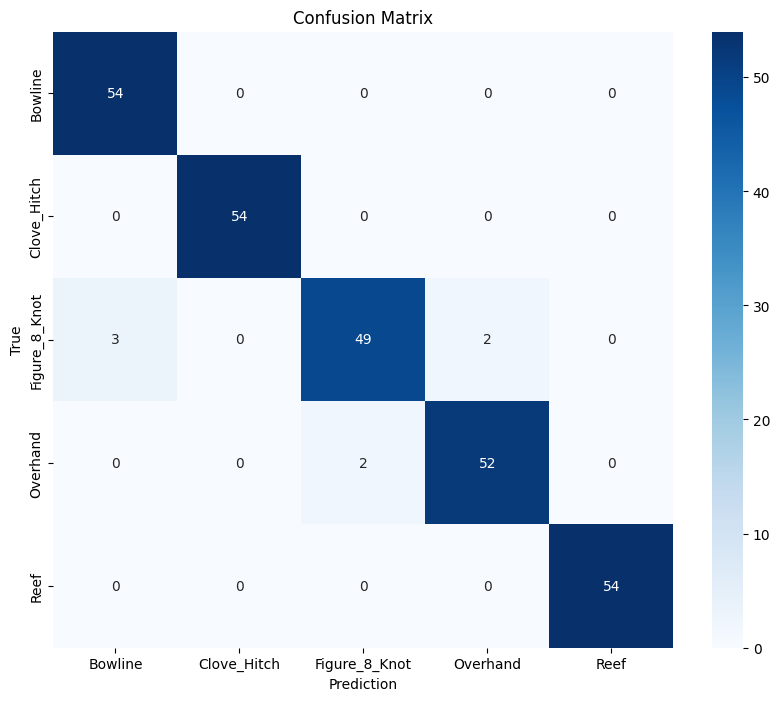

In [ ]:
# Define knot types
knot_types = ['Bowline', 'Clove_Hitch', 'Figure_8_Knot', 'Overhand', 'Reef']

# Plot confusion matrix
confusion_mtx = confusion_matrix(best_labels, best_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=knot_types, yticklabels=knot_types)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

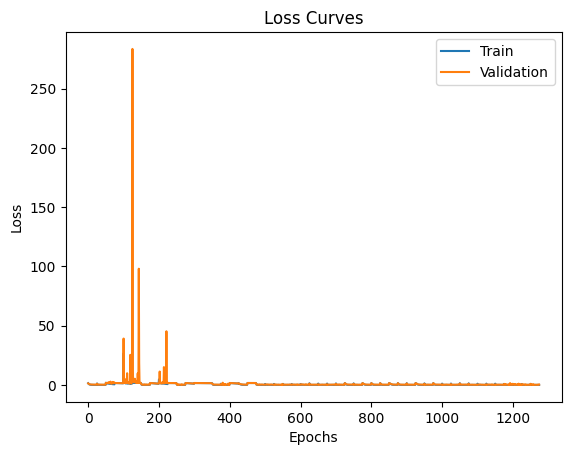

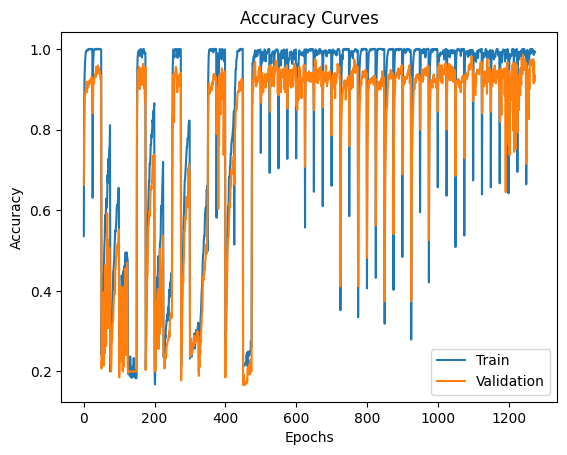

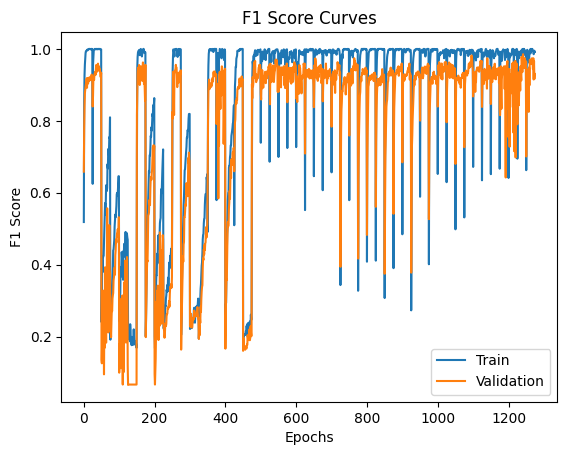

In [ ]:
# Plot loss curves
plt.figure()
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy curves
plt.figure()
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot F1 Score curves
plt.figure()
plt.plot(train_f1_scores, label='Train')
plt.plot(val_f1_scores, label='Validation')
plt.title('F1 Score Curves')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Runing on GPU
CUDA device count:  1


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


Epoch 0/24
----------
train Loss: 0.84804  Acc: 0.70247   F1_Score: 0.70179
val Loss: 0.68101  Acc: 0.79259   F1_Score: 0.78871

Epoch 1/24
----------
train Loss: 0.27536  Acc: 0.91852   F1_Score: 0.91866
val Loss: 0.32831  Acc: 0.88519   F1_Score: 0.88272

Epoch 2/24
----------
train Loss: 0.08316  Acc: 0.98148   F1_Score: 0.98147
val Loss: 0.28481  Acc: 0.89259   F1_Score: 0.89237

Epoch 3/24
----------
train Loss: 0.07829  Acc: 0.97654   F1_Score: 0.97657
val Loss: 0.17444  Acc: 0.95926   F1_Score: 0.95925

Epoch 4/24
----------
train Loss: 0.04693  Acc: 0.98395   F1_Score: 0.98390
val Loss: 0.28474  Acc: 0.92963   F1_Score: 0.92986

Epoch 5/24
----------
train Loss: 0.04148  Acc: 0.98765   F1_Score: 0.98764
val Loss: 0.13994  Acc: 0.95926   F1_Score: 0.95923

Epoch 6/24
----------
train Loss: 0.04013  Acc: 0.98889   F1_Score: 0.98890
val Loss: 0.73052  Acc: 0.81852   F1_Score: 0.78567

Epoch 7/24
----------
train Loss: 0.09538  Acc: 0.97531   F1_Score: 0.97520
val Loss: 0.16185  Ac

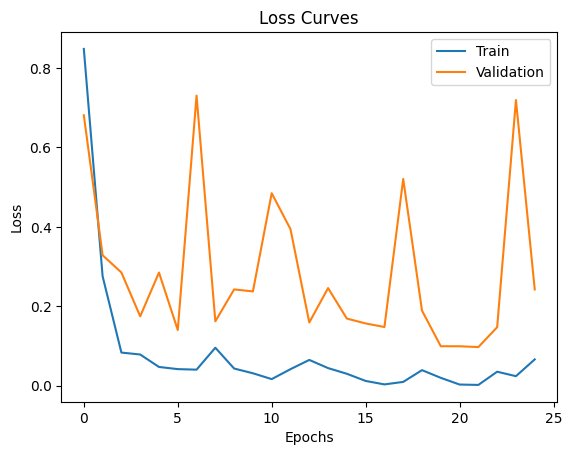

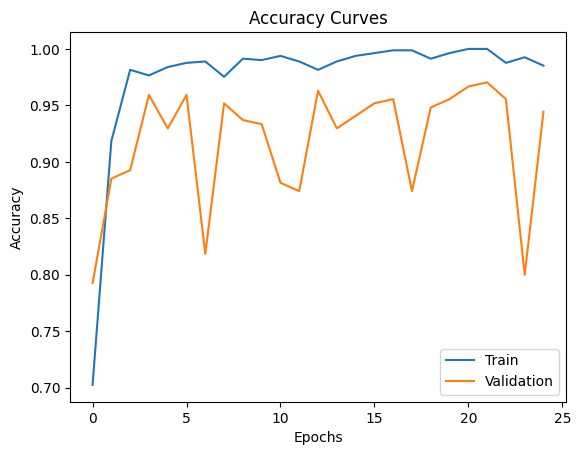

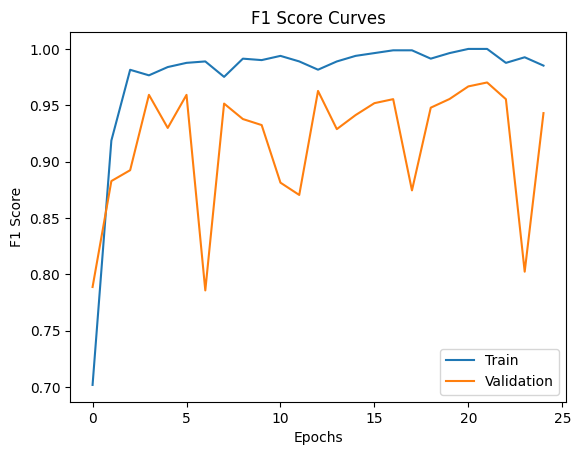

In [ ]:
# Use EfficientNet(tf_efficientnet_b5_ns) draw the curves with best hyperparameters
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import time
import copy
from torch.utils.data import Dataset
from torchvision.io import read_image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import random
import timm

# Connect to the google conlab
drive.mount('/content/drive')

# Use transforms to do data augmentation and preprocess
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(45),  # Rotate randomly between 0 and 45 degrees
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and scale to 224x224 size
    transforms.Grayscale(num_output_channels=3),  # Grayscale
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalization
])

class Knots_Dataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.data = []
        self.labels = []
        self.label_encoder = LabelEncoder()

        # Loop over all conditions
        for knot_type in os.listdir(img_dir):
            for light_condition in os.listdir(os.path.join(img_dir, knot_type)):
                for tension_condition in os.listdir(os.path.join(img_dir, knot_type, light_condition)):
                    images = os.listdir(os.path.join(img_dir, knot_type, light_condition, tension_condition))
                    random.shuffle(images)  # Shuffle the images
                    for image in images:
                        self.data.append(os.path.join(img_dir, knot_type, light_condition, tension_condition, image))
                        self.labels.append(knot_type)

        # Fit the label encoder and transform the labels
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path)
        image = image.convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Create a custom data set
dataset = Knots_Dataset("/content/drive/My Drive/MSc Project/rawdata", transform=data_transforms)

# Split the dataset into training set and validation set
train_dataset = []
val_dataset = []
for i in range(len(dataset)):
    if i % 4 == 0:  # Put 25% of the images in the validation set
        val_dataset.append(dataset[i])
    else:  # Put the rest in the training set
        train_dataset.append(dataset[i])

# Create a Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Check if model can be trained on GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Runing on GPU")
    print("CUDA device count: ", torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print("Runing on CPU")

# Save the model results
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []

def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_preds = None
    best_labels = None

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_preds = []
            running_labels = []

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero(clean) the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_preds.extend(preds.cpu().numpy())
                running_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_acc = epoch_acc.cpu().numpy()  # Move tensor to CPU and convert to numpy(debug)
            epoch_f1_score = f1_score(running_labels, running_preds, average='macro')
            epoch_f1_score = torch.tensor(epoch_f1_score).cpu().numpy()  # Move tensor to CPU and convert to numpy(debug)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                train_f1_scores.append(epoch_f1_score)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                val_f1_scores.append(epoch_f1_score)

            print('{} Loss: {:.5f}  Acc: {:.5f}   F1_Score: {:.5f}'.format(
                phase, epoch_loss, epoch_acc, epoch_f1_score))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_preds = running_preds
                best_labels = running_labels

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:5f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, best_preds, best_labels



# [I 2023-07-18 19:35:10,874] Trial 49 finished with value: 0.9851851851851853
# and parameters: {'lr': 0.00021305939437836783, 'optimizer': 'RMSprop', 'weight_decay': 2.0510689201040282e-10}. Best is trial 49 with value: 0.9851851851851853.
# Use the best hyperparameters to train the model
best_lr = 0.00021305939437836783
best_optimizer_name = 'RMSprop'
best_weight_decay = 2.0510689201040282e-10

# Load a pretrained model(EfficientNet)
model = timm.create_model('tf_efficientnet_b5_ns', pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 5)  # Change the classifier layer to 5
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Use the best optimizer
if best_optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
elif best_optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
else:
    optimizer = optim.RMSprop(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)


# Train and evaluate the best model
model, best_preds, best_labels = train_model(model, criterion, optimizer, num_epochs=25)




# Plot loss curves
plt.figure()
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy curves
plt.figure()
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot F1 Score curves
plt.figure()
plt.plot(train_f1_scores, label='Train')
plt.plot(val_f1_scores, label='Validation')
plt.title('F1 Score Curves')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()